# Import and Setting

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from scipy.optimize import leastsq
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler

In [4]:
#場所
region_list = ["utsunomiya", "chiba", "tokyo"]
#座標
latitude = [36.559444, 35.525312, 35.730062]
longtude = [139.882689, 140.068465, 139.516689]
#年
year_list = [2017, 2018, 2019, 2020]

# Data

In [5]:
#元データ
df_train = pd.read_csv("train_v2.csv")
df_test = pd.read_csv("test_v2.csv")

In [6]:
#欠損処理
# "欠測"を近い値か前後の平均値に置き換え
df_train["precipitation_tokyo"][11867] = df_train["precipitation_tokyo"][11866]
df_train["precipitation_tokyo"][11868] = df_train["precipitation_tokyo"][11869]

df_train["temperature_chiba"][11218] =df_train["temperature_chiba"][11217] 
df_train["temperature_chiba"][11219] =(float(df_train["temperature_chiba"][11217])+ float(df_train["temperature_chiba"][11221]))/2
df_train["temperature_chiba"][11220] =df_train["temperature_chiba"][11221] 

df_train["temperature_tokyo"][11866] =df_train["temperature_tokyo"][11865] 
df_train["temperature_tokyo"][11867] =(float(df_train["temperature_tokyo"][11865])+ float(df_train["temperature_tokyo"][11869]))/2
df_train["temperature_tokyo"][11868] =df_train["temperature_tokyo"][11869] 

df_train['winddirection_chiba'][11218] =df_train['winddirection_chiba'][11217]
df_train['winddirection_chiba'][11219] =df_train['winddirection_chiba'][11217]
df_train['winddirection_chiba'][11220] =df_train['winddirection_chiba'][11221]

df_train['winddirection_tokyo'][11866] =df_train['winddirection_tokyo'][11865]
df_train['winddirection_tokyo'][11867] =df_train['winddirection_tokyo'][11865]
df_train['winddirection_tokyo'][11868] =df_train['winddirection_tokyo'][11869]

df_train['windspeed_chiba'][11218] =df_train['windspeed_chiba'][11217]
df_train['windspeed_chiba'][11219] =(float(df_train['windspeed_chiba'][11217]) + float(df_train['windspeed_chiba'][11221]))/2
df_train['windspeed_chiba'][11220] =df_train['windspeed_chiba'][11221]

df_train['windspeed_tokyo'][11866] =df_train['windspeed_tokyo'][11865]
df_train['windspeed_tokyo'][11867] =(float(df_train['windspeed_tokyo'][11865]) + float(df_train['windspeed_tokyo'][11869]))/2
df_train['windspeed_tokyo'][11868] =df_train['windspeed_tokyo'][11869]


df_train['precipitation_tokyo'] = df_train['precipitation_tokyo'].astype(float, errors = 'raise')
df_train['temperature_chiba'] = df_train['temperature_chiba'].astype(float, errors = 'raise')
df_train['temperature_tokyo'] = df_train['temperature_tokyo'].astype(float, errors = 'raise')
df_train['winddirection_chiba'] = df_train['winddirection_chiba'].astype("int64", errors = 'raise')
df_train['winddirection_tokyo'] = df_train['winddirection_tokyo'].astype("int64", errors = 'raise')
df_train['windspeed_chiba'] = df_train['windspeed_chiba'].astype(float, errors = 'raise')
df_train['windspeed_tokyo'] = df_train['windspeed_tokyo'].astype(float, errors = 'raise')

#pollenの欠測データの前処理
kessoku_list = [-9996,-9997,-9998]
region_list = ["utsunomiya", "chiba", "tokyo"]
for k in range(len(kessoku_list)):
    # 欠測の置き換え
    for r in range(len(region_list)):
        df_train["pollen_" + region_list[r]][df_train["pollen_" + region_list[r]] == kessoku_list[k]] = 0

In [7]:
# 日付の変換
def date(df):    
    for i in range(len(df)):
        if str(df["datetime"][i])[8:] == '24':
            df["datetime"][i] = str(df["datetime"][i])[:8] + '00'

    df["datetime"] = pd.to_datetime(df["datetime"], format = '%Y%m%d%H')

    for i in range(len(df)):
        if str(df["datetime"][i])[11:13] == '00':
            df["datetime"][i] = df["datetime"][i] + datetime.timedelta(days=1)

    #年
    df["year"] = df["datetime"].dt.year
    #月
    df["month"] = df["datetime"].dt.month
    #日
    df["day"] = df["datetime"].dt.day
    #時
    df["hour"] = df["datetime"].dt.hour

In [8]:
date(df_train)
date(df_test)

# 基本特徴量作成

In [9]:
df_train_fe = df_train.copy()
df_test_fe = df_test.copy()

In [10]:
#風向きを南北軸と東西軸に分ける

def wind_xy(df):
    for r in range(3):
        df["winddirection_ns_"+region_list[r]] = 0
        df["winddirection_ew_"+region_list[r]] = 0
        for i in range(len(df)):
            if df["winddirection_"+region_list[r]][i] == 0:
                df["winddirection_ns_"+region_list[r]][i] = 0
                df["winddirection_ew_"+region_list[r]][i] = 0
            elif df["winddirection_"+region_list[r]][i] != 0:
                df["winddirection_ns_"+region_list[r]][i] = -np.cos(2*np.pi*(df["winddirection_"+region_list[r]][i])/16)
                df["winddirection_ew_"+region_list[r]][i] = -np.sin(2*np.pi*(df["winddirection_"+region_list[r]][i])/16)

In [11]:
wind_xy(df_train_fe)
wind_xy(df_test_fe)

In [12]:
#風向きを考慮した風速の特徴量を作る

#風速の正規化
for r in range(len(region_list)):
    #最小値の計算
    min = np.min(df_train_fe["windspeed_" + region_list[r]])
    #最大値の計算
    max = np.max(df_train_fe["windspeed_" + region_list[r]])
    #正規化の計算(testはtrainの式で)
    df_train_fe["windspeed2_" + region_list[r]] = (df_train_fe["windspeed_" + region_list[r]] - min) / (max - min)
    df_test_fe["windspeed2_" + region_list[r]] = (df_test_fe["windspeed_" + region_list[r]] - min) / (max - min)

#風向き*風速
for r in range(len(region_list)):    
    df_train_fe["winddirection_ns*speed_"+region_list[r]] = df_train_fe["winddirection_ns_"+region_list[r]] * df_train_fe["windspeed2_"+region_list[r]]
    df_train_fe["winddirection_ew*speed_"+region_list[r]] = df_train_fe["winddirection_ew_"+region_list[r]] * df_train_fe["windspeed2_"+region_list[r]]
    
for r in range(len(region_list)):
    df_test_fe["winddirection_ns*speed_"+region_list[r]] = df_test_fe["winddirection_ns_"+region_list[r]] * df_test_fe["windspeed2_"+region_list[r]]
    df_test_fe["winddirection_ew*speed_"+region_list[r]] = df_test_fe["winddirection_ew_"+region_list[r]] * df_test_fe["windspeed2_"+region_list[r]]

# 累積気温から計算した飛散量予測値算出

In [13]:
#sum_temp_pred:stp
df_train_stp = df_train.copy()
df_test_stp = df_test.copy()

In [14]:
#花粉の積算値を作成

#カラム作成
for r in range(3):
    df_train_stp["sum_pollen_" + region_list[r]] = 0

#データ入力
for r in range(3):
    for y in range(4):
        df_train_stp["sum_pollen_" + region_list[r]][df_train_stp["year"] == year_list[y]] = df_train_stp["pollen_" + region_list[r]][df_train_stp["year"] == year_list[y]].cumsum()

In [15]:
#気温の積算値を作成

#カラム作成
for r in range(3):
    df_train_stp["sum_temperature_" + region_list[r]] = 0

#データ入力
for r in range(3):
    for y in range(4):
        df_train_stp["sum_temperature_" + region_list[r]][df_train_stp["year"] == year_list[y]] = df_train_stp["temperature_" + region_list[r]][df_train_stp["year"] == year_list[y]].cumsum()

In [16]:
#その年の累積値で割って、相対値にする

#各年・場所の累積値の取得(2020年は累積値不明なので、後で予測して変更する)
df_sum_pollen = pd.DataFrame()
df_sum_pollen["year"] = [2017,2018,2019,2020]

#カラム作成
for r in range(3):
    df_sum_pollen["sum_pollen_"+region_list[r]] = 0

for r in range(3):
    for y in range(4):
        df_sum_pollen["sum_pollen_"+region_list[r]][df_sum_pollen["year"] == year_list[y]] = np.max(df_train_stp["sum_pollen_"+region_list[r]][df_train_stp["year"]==year_list[y]])

#sum_pollenを累積値で割って、relative_sum_pollenに

#カラム作成
for r in range(3):
    df_train_stp["relative_sum_pollen_" + region_list[r]] = 0

for r in range(3):
    for y in range(3):   #2020年以外
        df_train_stp["relative_sum_pollen_" + region_list[r]][df_train_stp["year"] == year_list[y]] = df_train_stp["sum_pollen_" + region_list[r]][df_train_stp["year"] == year_list[y]] / float(df_sum_pollen["sum_pollen_" + region_list[r]][df_sum_pollen["year"] == year_list[y]])

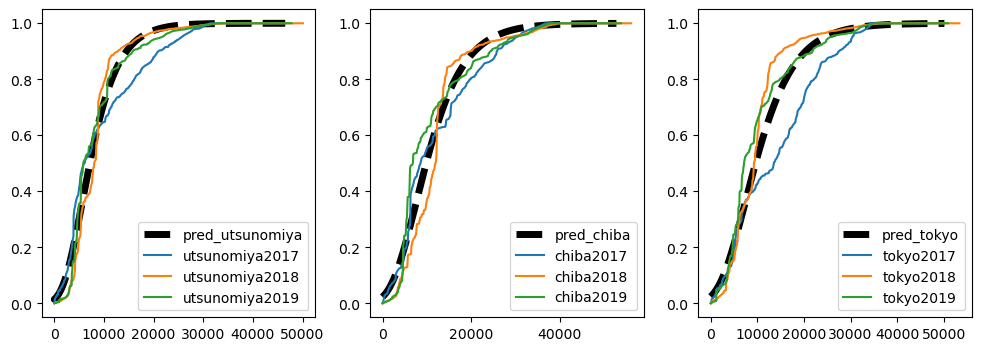

In [17]:
#地域ごとに予測モデルを作成する(モデル式は切片0の3次関数)

plt.figure(figsize=(12,4))
a=[]
b=[]
for r in range(3):
    plt.subplot(1,3,r+1)
    y=[]
    x=[]
    y = df_train_stp["relative_sum_pollen_" + region_list[r]][df_train_stp["year"] <= 2019]
    x = df_train_stp["sum_temperature_" + region_list[r]][df_train_stp["year"] <= 2019]

    #Antoine式
    def theoreticalValue(beta):
        ycal = np.exp(beta[0]*np.exp(beta[1]*x))
        return ycal

    #残差
    def objectiveFunction(beta):
        r = y - theoreticalValue(beta)
        return r

    #Levenberg-Marquardt法の実行
    initialValue = np.array([-0.001, -0.001])
    betaL = leastsq(objectiveFunction,initialValue,maxfev=1000)

    a = np.append(a,betaL[0][0])
    b = np.append(b,betaL[0][1])
    X = df_train_stp["sum_temperature_" + region_list[r]][df_train_stp["year"] == 2017]
    y = np.exp(a[r]*np.exp(b[r] * X))
    plt.plot(df_train_stp["sum_temperature_" + region_list[r]][df_train_stp["year"] == 2017], y, label = "pred_"+region_list[r],c="black", linewidth=5,linestyle="dashed")
#気温の積算値に対して、花粉の積算値の"相対値"をプロット
for r in range(3):
    plt.subplot(1,3,r+1)
    for y in range(3):
        plt.plot(df_train_stp["sum_temperature_" + region_list[r]][df_train_stp["year"] == year_list[y]], df_train_stp["relative_sum_pollen_" + region_list[r]][df_train_stp["year"] == year_list[y]], label = region_list[r] + str(year_list[y]))
        plt.legend()

In [18]:
# trainデータの予測

for r in range(3):
    #relative_sum_pollenの予測
    df_train_stp["pred_relative_sum_pollen_" + region_list[r]] = 0
    X = df_train_stp["sum_temperature_" + region_list[r]]
    df_train_stp["pred_relative_sum_pollen_" + region_list[r]] = np.exp(a[r]*np.exp(b[r] * X))
    
    #sum_pollenの予測(2020年以外)
    df_train_stp["pred_sum_pollen_" + region_list[r]] = 0
    for y in range(3):
        df_train_stp["pred_sum_pollen_" + region_list[r]][df_train_stp["year"] == year_list[y]] = df_train_stp["pred_relative_sum_pollen_" + region_list[r]] * float(df_sum_pollen["sum_pollen_" + region_list[r]][df_sum_pollen["year"] == year_list[y]])
        
    #pollenの予測(2020年以外)
    df_train_stp["pred_pollen_" + region_list[r]] = 0
    for y in range(3):
        for i in range(len(df_train_stp[df_train_stp["year"] == year_list[y]]) - 1):
            j = len(df_train_stp[df_train_stp["year"] < year_list[y]])
            df_train_stp["pred_pollen_" + region_list[r]][j+i+1] = df_train_stp["pred_sum_pollen_" + region_list[r]][j+i+1] - df_train_stp["pred_sum_pollen_" + region_list[r]][j+i]

utsunomiya積算花粉量：[[50890.47781378]]
chiba積算花粉量：[[37039.74828167]]
tokyo積算花粉量：[[32907.74790704]]


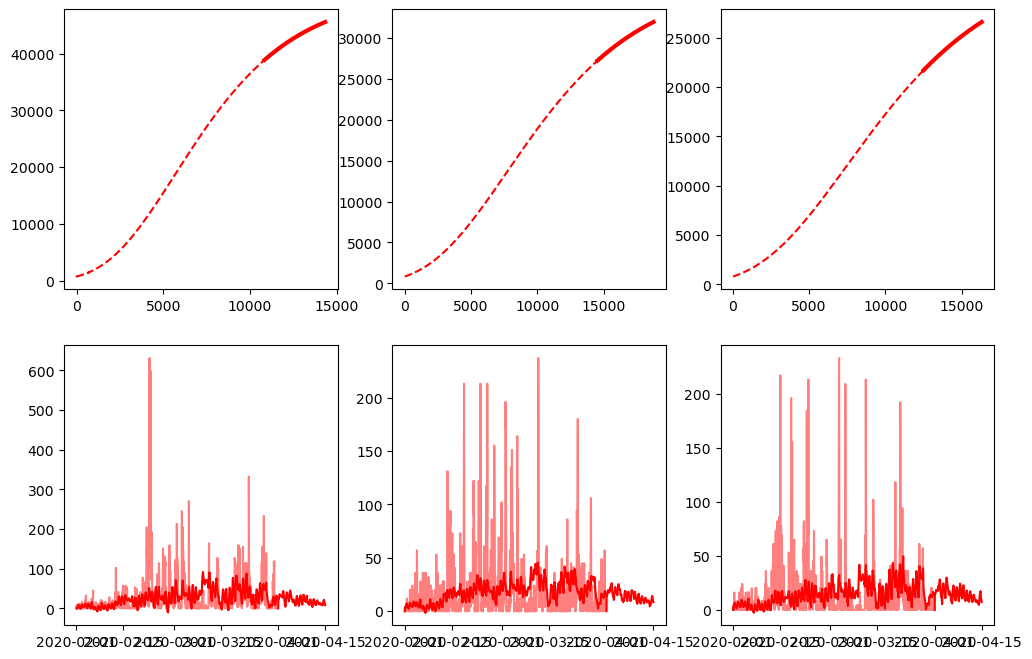

In [19]:
# testデータの予測

#y=exp{a*exp(bx)}をtestデータに当てはめる
j = len(df_train_stp[df_train_stp["year"] < 2020])
plt.figure(figsize=(12,8))
for r in range(3):
    plt.subplot(2,3,r+1)
    y_p = np.exp(a[r]*np.exp(b[r]*df_train_stp["sum_temperature_"+region_list[r]][df_train_stp["year"] == 2020]))

    #積算花粉量の予測(予測と実測の係数が積算花粉量)
    model = LinearRegression(fit_intercept = False)

    y_lr = np.array(df_train_stp["sum_pollen_"+region_list[r]][df_train_stp["year"] == 2020])
    y_lr = np.array(y_lr).reshape(-1,1)
    y_p=np.array(y_p)
    x_lr = np.array(y_p).reshape(-1,1)
    
    model.fit(x_lr,y_lr)
    
    df_test_stp["sum_temperature_"+region_list[r]] = df_test_stp["temperature_"+region_list[r]].cumsum()
    #途中からなので、trainの2020年のsum_tempを足す
    df_test_stp["sum_temperature_"+region_list[r]] = df_test_stp["sum_temperature_"+region_list[r]] + np.max(df_train_stp["sum_temperature_"+region_list[r]][df_train_stp["year"] == 2020])

    y_test_p = np.exp(a[r]*np.exp(b[r]*df_test_stp["sum_temperature_"+region_list[r]]))

    plt.plot(df_train_stp["sum_temperature_"+region_list[r]][df_train_stp["year"] == 2020], y_p*float(model.coef_), c="red", linestyle="dashed")
    plt.plot(df_test_stp["sum_temperature_"+region_list[r]], y_test_p*float(model.coef_), c="red", linewidth = 3)
    print(region_list[r]+"積算花粉量："+str(model.coef_))
    
    #df_sum_pollenに2020の予測値を更新
    df_sum_pollen["sum_pollen_" + region_list[r]][df_sum_pollen["year"] == 2020] = model.coef_
    
    #2020年のtrainデータの予測
    df_train_stp["pred_sum_pollen_" + region_list[r]][df_train_stp["year"] == 2020] = df_train_stp["pred_relative_sum_pollen_" + region_list[r]] * float(df_sum_pollen["sum_pollen_" + region_list[r]][df_sum_pollen["year"] == 2020])
    for i in range(len(df_train_stp[df_train_stp["year"] == 2020]) - 1):
        j = len(df_train_stp[df_train_stp["year"] < 2020])
        df_train_stp["pred_pollen_" + region_list[r]][j+i+1] = df_train_stp["pred_sum_pollen_" + region_list[r]][j+i+1] - df_train_stp["pred_sum_pollen_" + region_list[r]][j+i]
    
    #元の形に戻す
    df_test_stp["sum_pollen_"+region_list[r]] = y_test_p*float(model.coef_)
    df_test_stp["pred_pollen_"+region_list[r]] = 0 #カラム作成
    for i in range(len(df_test_stp)-1):
        df_test_stp["pred_pollen_"+region_list[r]][i+1] = df_test_stp["sum_pollen_"+region_list[r]][i+1] - df_test_stp["sum_pollen_"+region_list[r]][i]
    plt.subplot(2,3,r+4)
    plt.plot(df_train_stp["datetime"][df_train_stp["year"] == 2020],df_train_stp["pollen_"+region_list[r]][df_train_stp["year"] == 2020], c="red",alpha = 0.5)
    plt.plot(df_test_stp["datetime"],df_test_stp["pred_pollen_"+region_list[r]], c="red")
    plt.plot(df_train_stp["datetime"][df_train_stp["year"] == 2020],df_train_stp["pred_pollen_"+region_list[r]][df_train_stp["year"] == 2020], c="red")

In [20]:
# 各年の積算量(2020年は予測)
display(df_sum_pollen)

year  sum_pollen_utsunomiya  sum_pollen_chiba  sum_pollen_tokyo
0  2017          160265.000000      82793.000000      99023.000000
1  2018          477174.000000     130669.000000     143971.000000
2  2019          379773.000000     122643.000000      63458.000000
3  2020           50890.477814      37039.748282      32907.747907

In [21]:
#pollenの補正(年によって飛散量が異なるので、2020年の値に合わせる)
for r in range(3):
    for y in range(4):
        df_train_stp["pollen_" + region_list[r]][df_train_stp["year"] == year_list[y]] = df_train_stp["pollen_" + region_list[r]][df_train_stp["year"] == year_list[y]] / (df_sum_pollen["sum_pollen_" + region_list[r]][y]/df_sum_pollen["sum_pollen_" + region_list[r]][3])

In [22]:
#pred_pollenも補正(2020年の値に合わせる)
for r in range(3):
    df_test_stp["pred_pollen_" + region_list[r]] = df_test_stp["pred_pollen_" + region_list[r]]
    for y in range(4):
        df_train_stp["pred_pollen_" + region_list[r]][df_train_stp["year"] == year_list[y]] = df_train_stp["pred_pollen_" + region_list[r]][df_train_stp["year"] == year_list[y]] / (df_sum_pollen["sum_pollen_" + region_list[r]][y]/df_sum_pollen["sum_pollen_" + region_list[r]][3])

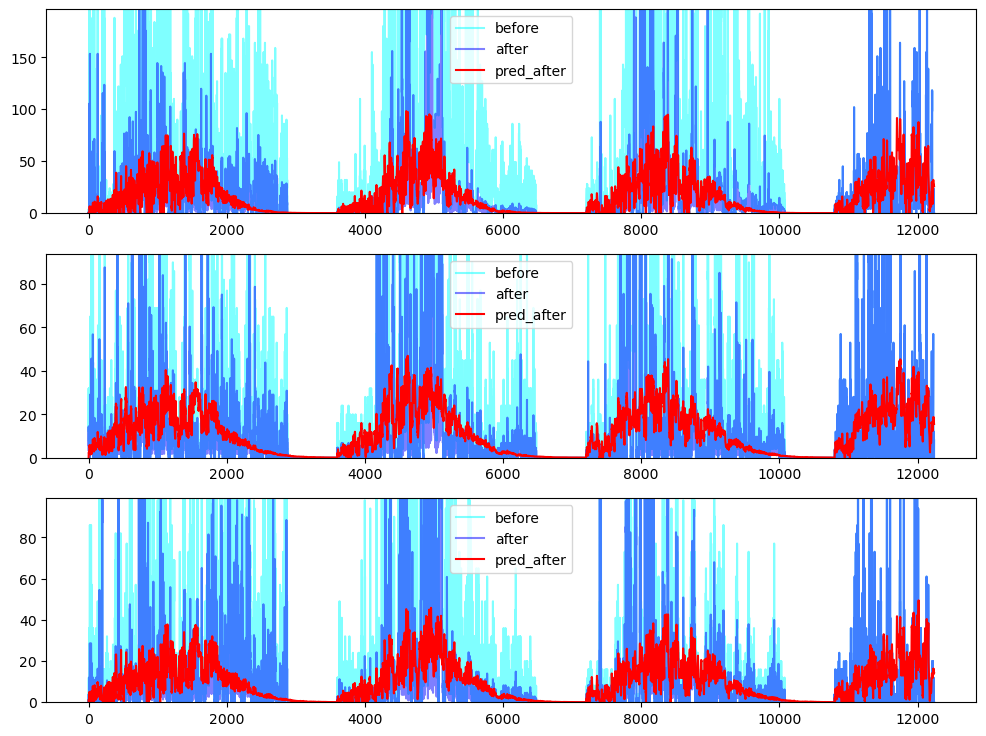

In [23]:
plt.figure(figsize=(12,9))
for r in range(3):
    plt.subplot(3,1,r+1)
    plt.plot(df_train["pollen_" + region_list[r]], alpha=0.5, color = "cyan", label = "before")
    plt.plot(df_train_stp["pollen_" + region_list[r]], alpha=0.5, color = "blue", label = "after")
    plt.plot(df_train_stp["pred_pollen_" + region_list[r]], alpha=1, color = "red", label = "pred_after")
    plt.ylim(0,np.max(df_train_stp["pred_pollen_" + region_list[r]])*2)
    plt.legend()

In [24]:
df_train_fe_pred = pd.concat([df_train_fe, df_train_stp[{"pred_pollen_utsunomiya", "pred_pollen_chiba", "pred_pollen_tokyo",
                                                         "sum_temperature_utsunomiya", "sum_temperature_chiba", "sum_temperature_tokyo"}]], axis =1)
for r in range(len(region_list)):
    df_train_fe_pred["pollen_" + region_list[r]] = df_train_stp["pollen_" + region_list[r]]
    
df_test_fe_pred = pd.concat([df_test_fe, df_test_stp[{"pred_pollen_utsunomiya", "pred_pollen_chiba", "pred_pollen_tokyo",
                                                      "sum_temperature_utsunomiya", "sum_temperature_chiba", "sum_temperature_tokyo"}]], axis =1)

# 特徴量エンジニアリング

In [2820]:
df_train_fe_2 = df_train_fe_pred.copy()
df_test_fe_2 = df_test_fe_pred.copy()

In [2821]:
# ragやrolling特徴量作るときにtestにNaNを発生させたくないのでtestの頭にtrainのデータを結合　　24時間分
df_test_fe_2 = pd.concat([df_train_fe_2[-24:], df_test_fe_2], axis=0)
df_test_fe_2 = df_test_fe_2.reset_index()
df_test_fe_2 = df_test_fe_2.drop("index", axis=1)

In [2822]:
#降水量ゼロカウンター
def zero_count(df,alpha=0.05):
    for r in range(3):
        df_count = []
        n_count = 0
        for i in range(len(df)):
            if df["precipitation_" + region_list[r]][i] == 0:
                n_count += 1
            else:
                n_count = 0
            df_count.append(n_count)
        df["rain_zero_count_" + region_list[r]] = np.tanh(np.array(df_count)*alpha)

zero_count(df_train_fe_2)
zero_count(df_test_fe_2)

In [2823]:
# 時刻を三角関数で、円状に配置
# 24時間を、0から1までの値に変換
clock24_train = df_train_fe_2["hour"]/24
clock24_test = df_test_fe_2["hour"]/24

# 三角関数で変換
df_train_fe_2['sin'] = np.sin(2 * np.pi * clock24_train)
df_train_fe_2['cos'] = np.cos(2 * np.pi * clock24_train)
df_test_fe_2['sin'] = np.sin(2 * np.pi * clock24_test)
df_test_fe_2['cos'] = np.cos(2 * np.pi * clock24_test)

In [2824]:
# 日の出時間と日の入り時間の追加 (各地域で差がないのでutsunomiyaを代表値として採用)
import ephem

def sun_date(df):
    for r in range(1):
        df[region_list[r] + "_sunrise"] = 0
        df[region_list[r] + "_sunset"] = 0
        df[region_list[r] + "_sun_hurf"] = 0 #太陽がピークの位置にいる時間hour
        for i in range(len(df)):
            sun_region = ephem.Observer()
            sun_region.lat = str(latitude[r])
            sun_region.lon = str(longtude[r])
            sun_region.date = datetime.datetime(year = df["datetime"][i].year, month = df["datetime"][i].month, day = df["datetime"][i].day)
            sun = ephem.Sun()

            sunrise = ephem.localtime(sun_region.previous_rising(sun))
            sunset = ephem.localtime(sun_region.next_setting(sun))

            df[region_list[r] + "_sunrise"][i] = sunrise
            df[region_list[r] + "_sunset"][i] = sunset
            df[region_list[r] + "_sun_hurf"][i] = (df[region_list[r] + "_sunrise"][i].hour+df[region_list[r] + "_sunrise"][i].minute/60 + df[region_list[r] + "_sunset"][i].hour+df[region_list[r] + "_sunset"][i].minute/60)/2

sun_date(df_train_fe_2)
sun_date(df_test_fe_2)

#太陽の位置
def sun_cat(df):
    for r in range(1):
        df[region_list[r] + "_sun"] = 0
        df[region_list[r] + "_sun_posi"] = 0

        #太陽が出ているか
        for i in range(len(df)):
            if (df["datetime"][i] > df[region_list[r] + "_sunrise"][i]) & (df["datetime"][i] < df[region_list[r] + "_sunset"][i]) & (df["precipitation_" + region_list[r]][i] < 0.5):
                df[region_list[r] + "_sun"][i] = 1
                
        #太陽がどれぐらい出ているか(どれぐらいの位置にいるか)
        for i in range(len(df)):
            if (df[region_list[r] + "_sun"][i] == 1) & (df["datetime"][i].hour < df[region_list[r] + "_sun_hurf"][i]):
                df[region_list[r] + "_sun_posi"][i] = df["datetime"][i].hour - df[region_list[r] + "_sunrise"][i].hour
            elif (df[region_list[r] + "_sun"][i] == 1) & (df["datetime"][i].hour > df[region_list[r] + "_sun_hurf"][i]):
                df[region_list[r] + "_sun_posi"][i] = df[region_list[r] + "_sunset"][i].hour - df["datetime"][i].hour
                
sun_cat(df_train_fe_2)
sun_cat(df_test_fe_2)

#sunriseとsunsetのdrop
df_train_fe_2 = df_train_fe_2.drop({"utsunomiya_sunrise", "utsunomiya_sunset", "utsunomiya_sun_hurf", "utsunomiya_sun"}, axis = 1)
df_test_fe_2 = df_test_fe_2.drop({"utsunomiya_sunrise", "utsunomiya_sunset", "utsunomiya_sun_hurf", "utsunomiya_sun"}, axis = 1)

In [2825]:
#lag
def lag(df, lag, feature):
    for r in range(len(region_list)):
        for i in range(lag):
            df[feature + region_list[r] + "_lag" +  str(i+1)] =  df[feature + region_list[r]].shift(i+1)

#ma
def ma_h(df, hour, feature):
    for r in range(len(region_list)):
        df[feature + region_list[r] + "_ma"+str(hour)] = df["precipitation_" + region_list[r]].rolling(window=hour).mean()
        
#max
def max_h(df, hour, feature):
    for r in range(len(region_list)):
        df[feature + region_list[r] + "_max"+str(hour)] = df["precipitation_" + region_list[r]].rolling(window=hour).max()
        
#min
def min_h(df, hour, feature):
    for r in range(len(region_list)):
        df[feature + region_list[r] + "_min"+str(hour)] = df["precipitation_" + region_list[r]].rolling(window=hour).min()
        
def deruta(df,feature):#t-1,t-2,…t-6との差
    for r in range(len(region_list)):
        df[feature + region_list[r] + "_deruta1"] = df[feature + region_list[r]].diff(1)
        df[feature + region_list[r] + "_deruta2"] = df[feature + region_list[r]].diff(2)
        df[feature + region_list[r] + "_deruta2"] = df[feature + region_list[r]].diff(3)
        df[feature + region_list[r] + "_deruta2"] = df[feature + region_list[r]].diff(4)
        df[feature + region_list[r] + "_deruta2"] = df[feature + region_list[r]].diff(5)
        df[feature + region_list[r] + "_deruta2"] = df[feature + region_list[r]].diff(6)
        
def kougosayou(df,feature1,feature2):
    for r in range(len(region_list)):
        df[feature1+"*"+feature2+"_"+region_list[r]] = df[feature1+"_"+region_list[r]] * df[feature2+"_"+region_list[r]] 

In [2826]:
lag_time = 6

In [2827]:
#降水量のma,max,min
for i in range(lag_time):
    ma_h(df_train_fe_2,i+1, "precipitation_")
    ma_h(df_test_fe_2,i+1, "precipitation_")
#不採用    max_h(df_train_fe_2,i+1, "precipitation_")
#不採用    max_h(df_test_fe_2,i+1, "precipitation_")
#不採用    min_h(df_train_fe_2,i+1, "precipitation_")
#不採用    min_h(df_test_fe_2,i+1, "precipitation_")

In [2828]:
# 気温*風速ベクトル
kougosayou(df_train_fe_2, "temperature", "winddirection_ns*speed")
kougosayou(df_train_fe_2, "temperature", "winddirection_ew*speed")
kougosayou(df_test_fe_2, "temperature", "winddirection_ns*speed")
kougosayou(df_test_fe_2, "temperature", "winddirection_ew*speed")

In [2829]:
# precipitationの逆数のカラムを作成(雨が降ってないとき大きく、雨が降ると小さくなる(交互作用項に使えそう))
for r in range(len(region_list)):
    df_train_fe_2["precipitation_gyaku_" + region_list[r]] = 1/(df_train_fe_2["precipitation_" + region_list[r]]+1)
    df_test_fe_2["precipitation_gyaku_" + region_list[r]] = 1/(df_test_fe_2["precipitation_" + region_list[r]]+1)

In [2830]:
# 1/雨*風速ベクトル
kougosayou(df_train_fe_2, "precipitation_gyaku", "winddirection_ns*speed")
kougosayou(df_train_fe_2, "precipitation_gyaku", "winddirection_ew*speed")
kougosayou(df_test_fe_2, "precipitation_gyaku", "winddirection_ns*speed")
kougosayou(df_test_fe_2, "precipitation_gyaku", "winddirection_ew*speed")

In [2831]:
# 気温の差分(雨や曇りで気温下がったあとに、晴れて気温上がったら飛散しそう)
deruta(df_train_fe_2, "temperature_")
deruta(df_test_fe_2, "temperature_")

In [2832]:
#風速のlag
lag(df_train_fe_2, lag_time, "winddirection_ns*speed_")
lag(df_test_fe_2, lag_time, "winddirection_ns*speed_")

lag(df_train_fe_2, lag_time, "winddirection_ew*speed_")
lag(df_test_fe_2, lag_time, "winddirection_ew*speed_")

In [2833]:
#風速のderuta
deruta(df_train_fe_2, "winddirection_ns*speed_")
deruta(df_test_fe_2, "winddirection_ns*speed_")

deruta(df_train_fe_2, "winddirection_ew*speed_")
deruta(df_test_fe_2, "winddirection_ew*speed_")

In [2834]:
#temperature*winddirection_ns*speedのlag
lag(df_train_fe_2, lag_time, "temperature*winddirection_ns*speed_")
lag(df_train_fe_2, lag_time, "temperature*winddirection_ew*speed_")
lag(df_test_fe_2, lag_time, "temperature*winddirection_ns*speed_")
lag(df_test_fe_2, lag_time, "temperature*winddirection_ew*speed_")

In [2835]:
#temperature*winddirection_ns*speedのderuta
deruta(df_train_fe_2, "temperature*winddirection_ns*speed_")
deruta(df_test_fe_2, "temperature*winddirection_ns*speed_")

deruta(df_train_fe_2, "temperature*winddirection_ew*speed_")
deruta(df_test_fe_2, "temperature*winddirection_ew*speed_")

In [2836]:
#tprecipitation_gyaku*winddirection_ns*speedのlag
lag(df_train_fe_2, lag_time, "precipitation_gyaku*winddirection_ns*speed_")
lag(df_train_fe_2, lag_time, "precipitation_gyaku*winddirection_ew*speed_")
lag(df_test_fe_2, lag_time, "precipitation_gyaku*winddirection_ns*speed_")
lag(df_test_fe_2, lag_time, "precipitation_gyaku*winddirection_ew*speed_")

In [2837]:
# trainのNaN削除とtestデータの先頭のtrainデータ削除
df_train_lgbm = df_train_fe_2[24:]
df_train_lgbm = df_train_lgbm.reset_index()
df_train_lgbm = df_train_lgbm.drop("index", axis=1)

df_test_lgbm = df_test_fe_2[24:]
df_test_lgbm = df_test_lgbm.reset_index()
df_test_lgbm = df_test_lgbm.drop("index", axis=1)

In [2838]:
#6月はすべてゼロなのでdrop
drop_index = df_train_lgbm.index[df_train_lgbm['month'] >= 6]
df_train_lgbm = df_train_lgbm.drop(drop_index)
df_train_lgbm = df_train_lgbm.reset_index()
df_train_lgbm = df_train_lgbm.drop("index", axis=1)

In [2839]:
df_train_lgbm.shape, df_test_lgbm.shape

((10053, 218), (336, 218))

# 特徴量選択

In [2844]:
#train_travalをtrainとvalidに分割
df_traval_y = df_train_lgbm[{"pollen_utsunomiya","pollen_chiba","pollen_tokyo"}]
df_traval_x = df_train_lgbm.drop({"pollen_utsunomiya","pollen_chiba","pollen_tokyo", 
                                 "datetime", "year", "day", "hour",
                                 "month",     
                                 "winddirection_utsunomiya", "winddirection_chiba", "winddirection_tokyo",
                                }, axis=1)

#交互作用作成(数が多すぎて計算できない)
#from sklearn.preprocessing import PolynomialFeatures
#poly2d_io = PolynomialFeatures(2, interaction_only=True)
#df_traval_x = poly2d_io.fit_transform(df_traval_x)

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x, df_traval_y, test_size=0.3, random_state=1234)

#予測格納用
df_sub = pd.DataFrame()
df_pred = pd.DataFrame()

In [2845]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((7037, 207), (3016, 207), (7037, 3), (3016, 3))

In [2846]:
#特徴量選択用

def get_feature_importances(region, x_t, x_v, y_t, y_v, shuffle=False):
    # 必要ならば目的変数をシャッフル
    if shuffle:
        y_t = pd.DataFrame(np.random.permutation(y_t["pollen_"+region]), columns=["pollen_"+region])
        y_v = pd.DataFrame(np.random.permutation(y_v["pollen_"+region]), columns=["pollen_"+region])
    
# モデルの学習
    lgb_train=lgb.Dataset(x_t, np.log(y_t["pollen_"+region]+0.5))
    lgb_valid=lgb.Dataset(x_v, np.log(y_v["pollen_"+region]+0.5))

    params = {
        'boosting_type': 'gbdt',
        'objective': 'huber',
        'metric': 'huber',
        'max_depth': 50,#50
        'num_leaves': 200,#200
        'learning_rate': 0.5,
        'feature_fraction': 1.0,#0.6
        'bagging_fraction': 1.0,#0.8
        'bagging_freq': 5,
        'verbose': -1,
        'seed':1234,
#        'lambda_l1':3,#3
#        'lambda_l2':3,#3
    }

    #学習
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    num_boost_round = 5000,
                    early_stopping_rounds=1000,#1000
                    verbose_eval = -1
                   )

    # 特徴量の重要度を含むデータフレームを作成
    imp_df = pd.DataFrame()
    imp_df["feature"] = x_t.columns
    imp_df["importance"] = gbm.feature_importance(importance_type='gain')
    return imp_df.sort_values("importance", ascending=False)

def feature_select(region, train_x, valid_x, train_y, valid_y, THRESHOLD):
    # 実際の目的変数でモデルを学習し、特徴量の重要度を含むデータフレームを作成
    actual_imp_df = get_feature_importances(region, train_x, valid_x, train_y, valid_y, shuffle=False)

    # 目的変数をシャッフルした状態でモデルを学習し、特徴量の重要度を含むデータフレームを作成
    N_RUNS = 100
    null_imp_df = pd.DataFrame()
    for i in tqdm(range(N_RUNS)):
        imp_df = get_feature_importances(region, train_x, valid_x, train_y, valid_y, shuffle=True)
        imp_df["run"] = i + 1
        null_imp_df = pd.concat([null_imp_df, imp_df])
        
    # 閾値を超える特徴量を取得
    imp_features = []
    for feature in actual_imp_df["feature"]:
        actual_value = actual_imp_df.query(f"feature=='{feature}'")["importance"].values
        null_value = null_imp_df.query(f"feature=='{feature}'")["importance"].values
        percentage = (null_value < actual_value).sum() / null_value.size * 100
        if percentage >= THRESHOLD:
            imp_features.append(feature)

    return(imp_features)

In [2847]:
imp_features_u = feature_select("utsunomiya", x_train, x_valid, y_train, y_valid, 100)
len(imp_features_u)

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[10]	training's huber: 0.0872006	valid_1's huber: 0.374112


  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.760664	valid_1's huber: 0.819694
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.76012	valid_1's huber: 0.821473
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.762853	valid_1's huber: 0.821367
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.762743	valid_1's huber: 0.821501
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.762098	valid_1's huber: 0.824504
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.763685	valid_1's huber: 0.819657
Training until validation scores don't improve for 1000 rounds
Early st

Early stopping, best iteration is:
[1]	training's huber: 0.763247	valid_1's huber: 0.826693
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.762613	valid_1's huber: 0.826019
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.76276	valid_1's huber: 0.823831
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.764755	valid_1's huber: 0.821006
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.761447	valid_1's huber: 0.827693
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.761979	valid_1's huber: 0.828701
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.760715	valid

83

In [2848]:
imp_features_c = feature_select("chiba", x_train, x_valid, y_train, y_valid, 100)
len(imp_features_c)

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[9]	training's huber: 0.122763	valid_1's huber: 0.435723


  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.656546	valid_1's huber: 0.746127
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.655675	valid_1's huber: 0.744188
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.658443	valid_1's huber: 0.741281
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.65785	valid_1's huber: 0.741163
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.65774	valid_1's huber: 0.74167
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.657818	valid_1's huber: 0.741564
Training until validation scores don't improve for 1000 rounds
Early stop

Early stopping, best iteration is:
[1]	training's huber: 0.657496	valid_1's huber: 0.744618
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.658284	valid_1's huber: 0.743019
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.657236	valid_1's huber: 0.74337
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.657768	valid_1's huber: 0.743651
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.657725	valid_1's huber: 0.741304
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.659271	valid_1's huber: 0.744359
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.659044	valid

107

In [2849]:
imp_features_t = feature_select("tokyo", x_train, x_valid, y_train, y_valid, 100)
len(imp_features_t)

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[12]	training's huber: 0.0796557	valid_1's huber: 0.450079


  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.712516	valid_1's huber: 0.778382
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.711931	valid_1's huber: 0.777313
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.711099	valid_1's huber: 0.778914
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.712642	valid_1's huber: 0.7799
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.712097	valid_1's huber: 0.777643
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.712891	valid_1's huber: 0.775776
Training until validation scores don't improve for 1000 rounds
Early sto

Early stopping, best iteration is:
[1]	training's huber: 0.712111	valid_1's huber: 0.779437
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.712061	valid_1's huber: 0.774718
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.713191	valid_1's huber: 0.776791
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.711876	valid_1's huber: 0.777925
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.712236	valid_1's huber: 0.777308
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.710177	valid_1's huber: 0.783064
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1]	training's huber: 0.71199	valid

128

In [2850]:
#特徴量を限定
df_train_lgbm_u = pd.concat([df_train_lgbm[imp_features_u], df_train_lgbm[{"pollen_utsunomiya", "month", "day"}]], axis=1)
df_test_lgbm_u = pd.concat([df_test_lgbm[imp_features_u], df_test_lgbm[{"pollen_utsunomiya", "month", "day"}]], axis=1)

df_train_lgbm_c = pd.concat([df_train_lgbm[imp_features_c], df_train_lgbm[{"pollen_chiba", "month", "day"}]], axis=1)
df_test_lgbm_c = pd.concat([df_test_lgbm[imp_features_c], df_test_lgbm[{"pollen_chiba", "month", "day"}]], axis=1)

df_train_lgbm_t = pd.concat([df_train_lgbm[imp_features_t], df_train_lgbm[{"pollen_tokyo", "month", "day"}]], axis=1)
df_test_lgbm_t = pd.concat([df_test_lgbm[imp_features_t], df_test_lgbm[{"pollen_tokyo", "month", "day"}]], axis=1)

# 学習

In [2851]:
# カテゴリーの設定(大きい値(異常値？)が少ないので、小さいデータのみ分割して、分割したデータに同じ大きいデータを結合して大きいデータを予測しやすくする)
cat_no = [0,1,2,3,4,5,6,7]
cat = [0,1,2,3,4,5,6,7]

def target_cat(df, region):
    
    # データフレームを新たに作成
    df_train_lgbm_cat = df.copy()
    df_train_lgbm_cat = df_train_lgbm_cat.reset_index()
    df_train_lgbm_cat = df_train_lgbm_cat.drop("index", axis=1)

    # カテゴリーカラムの作成
    df_train_lgbm_cat["pollen_"+region+"_cat"] = 0

    #カテゴリー化
    for c in range(len(cat)):
        for i in range(len(df_train_lgbm_cat)):
            if (np.log(df_train_lgbm_cat["pollen_"+region][i]+0.5) > cat[c]):
                df_train_lgbm_cat["pollen_"+region+"_cat"][i] = cat_no[c]
    
    return df_train_lgbm_cat

In [2852]:
df_train_lgbm_cat_u = target_cat(df_train_lgbm_u, "utsunomiya")
df_train_lgbm_cat_c = target_cat(df_train_lgbm_c, "chiba")
df_train_lgbm_cat_t = target_cat(df_train_lgbm_t, "tokyo")

In [2853]:
#各年の4/1～15をテストデータとする
df_train_test_u = df_train_lgbm_cat_u[(df_train_lgbm_cat_u["month"] == 4) & (df_train_lgbm_cat_u["day"] <= 15)]
df_train_traval_u = df_train_lgbm_cat_u[~((df_train_lgbm_cat_u["month"] == 4) & (df_train_lgbm_cat_u["day"] <= 15))] 

df_train_test_c = df_train_lgbm_cat_c[(df_train_lgbm_cat_c["month"] == 4) & (df_train_lgbm_cat_c["day"] <= 15)]
df_train_traval_c = df_train_lgbm_cat_c[~((df_train_lgbm_cat_c["month"] == 4) & (df_train_lgbm_cat_c["day"] <= 15))] 

df_train_test_t = df_train_lgbm_cat_t[(df_train_lgbm_cat_t["month"] == 4) & (df_train_lgbm_cat_t["day"] <= 15)]
df_train_traval_t = df_train_lgbm_cat_t[~((df_train_lgbm_cat_t["month"] == 4) & (df_train_lgbm_cat_t["day"] <= 15))] 

In [2854]:
# 閾値3で分ける
THRESHOLD_u = 3
THRESHOLD_c = 3
THRESHOLD_t = 3

### utsunomiya
df_train_traval_u_over = df_train_traval_u[df_train_traval_u["pollen_utsunomiya_cat"] >= THRESHOLD_u] 
df_train_traval_u_under = df_train_traval_u[df_train_traval_u["pollen_utsunomiya_cat"] < THRESHOLD_u] 
df_train_traval_u_over = df_train_traval_u_over.reset_index()
df_train_traval_u_over = df_train_traval_u_over.drop("index", axis=1)
df_train_traval_u_under = df_train_traval_u_under.reset_index()
df_train_traval_u_under = df_train_traval_u_under.drop("index", axis=1)

### chiba
df_train_traval_c_over = df_train_traval_c[df_train_traval_c["pollen_chiba_cat"] >= THRESHOLD_c] 
df_train_traval_c_under = df_train_traval_c[df_train_traval_c["pollen_chiba_cat"] < THRESHOLD_c] 
df_train_traval_c_over = df_train_traval_c_over.reset_index()
df_train_traval_c_over = df_train_traval_c_over.drop("index", axis=1)
df_train_traval_c_under = df_train_traval_c_under.reset_index()
df_train_traval_c_under = df_train_traval_c_under.drop("index", axis=1)

### tokyo
df_train_traval_t_over = df_train_traval_t[df_train_traval_t["pollen_tokyo_cat"] >= THRESHOLD_t] 
df_train_traval_t_under = df_train_traval_t[df_train_traval_t["pollen_tokyo_cat"] < THRESHOLD_t] 
df_train_traval_t_over = df_train_traval_t_over.reset_index()
df_train_traval_t_over = df_train_traval_t_over.drop("index", axis=1)
df_train_traval_t_under = df_train_traval_t_under.reset_index()
df_train_traval_t_under = df_train_traval_t_under.drop("index", axis=1)


print(len(df_train_traval_u_over), len(df_train_traval_u_under))
print(len(df_train_traval_c_over), len(df_train_traval_c_under))
print(len(df_train_traval_t_over), len(df_train_traval_t_under))

2005 6967
1513 7459
1370 7602


In [2855]:
#lgbmスクリーニング用
def lgbm_s(region,df_train_x,df_train_y,df_test_x,log_plus, x_train, x_valid, y_train, y_valid, label): #地域、予測用trainデータ、予測用train_yデータ、予測用testデータ、log_plus
    lgb_train=lgb.Dataset(x_train, np.log(y_train["pollen_"+region]+log_plus))
    lgb_valid=lgb.Dataset(x_valid, np.log(y_valid["pollen_"+region]+log_plus))
        
    params = {
        'boosting_type': 'gbdt',
        'objective': 'huber',
        'metric': 'huber',
        'max_depth': 50,#50
        'num_leaves': 200,#200
        'learning_rate': 0.1,
        'feature_fraction': 1,#1
        'bagging_fraction': 1,#1
        'bagging_freq': 5,
        'verbose': -1,
        'seed':1234,
        'lambda_l1':3,#3
        'lambda_l2':3,#3
    }

    #学習
    result_data = {}
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    num_boost_round = 5000,
                    early_stopping_rounds=1000,#1000
                    evals_result = result_data,
                    verbose_eval = -1)
    
    lgb.plot_importance(gbm, max_num_features=30, importance_type='gain')#

    plt.figure(figsize=(8, 4))#
    pred = gbm.predict(df_train_x)    
     
    plt.subplot(1,2,1)#
    plt.scatter(np.exp(pred)-log_plus, df_train_y["pollen_" + region])#

#    plt.subplot(1,2,2)#
#    plt.plot(result_data["training"]["huber"], color = "red", label = "train")#
#    plt.plot(result_data["valid_1"]["huber"], color = "blue", label = "valid")#
#    plt.legend()#
#    plt.show()#
    
    #テストデータ予測
    pred_test =  gbm.predict(df_test_x)
     
    #結果をテストデータに追加
    df_sub["pollen_" + region + label] = np.exp(pred_test)-log_plus
    df_pred["pollen_"+region + label] = np.exp(pred)-log_plus
    
    # feature importanceを表示
    importance = pd.DataFrame(gbm.feature_importance(importance_type='gain'), index=x_train.columns, columns=['importance'])
    importance = importance.sort_values('importance', ascending=False)
    
    #CVのmaeを表示
    print("MAE", mean_absolute_error(np.exp(gbm.predict(df_train_x))-log_plus, df_train_y["pollen_"+region]))    
    
    return importance,gbm

In [3008]:
# optuna
from optuna.integration import lightgbm as gbm

def lgbm_o(region,df_train_x,df_train_y,df_test_x,log_plus, x_train, x_valid, y_train, y_valid, label, seed=1234): #地域、予測用trainデータ、予測用train_yデータ、予測用testデータ、log_plus
    lgb_train=lgb.Dataset(x_train, np.log(y_train["pollen_"+region]+log_plus))
    lgb_valid=lgb.Dataset(x_valid, np.log(y_valid["pollen_"+region]+log_plus))
        
    # 固定するパラメータ
    params = {
        "boosting_type": "gbdt",
        'objective': 'huber',
        'metric': 'huber',
        'seed':seed,
        "verbosity": -1,
    }

    # Optunaでのパラメータ探索
    result_data = {}
    model = gbm.train(params, lgb_train, 
                      valid_sets=[lgb_train, lgb_valid],
                      verbose_eval=-1,
                      early_stopping_rounds=100,
                      evals_result = result_data
                     )
    
    # 最適なパラメータの表示
    best_params = model.params
    print("Best params:", best_params)
    
    gbm.plot_importance(model, max_num_features=30, importance_type='gain')

    pred = model.predict(df_train_x)    
     
    plt.scatter(np.exp(pred)-log_plus, df_train_y["pollen_" + region])
    
    #テストデータ予測
    pred_test =  model.predict(df_test_x)
     
    #結果をテストデータに追加
    df_sub["pollen_" + region + str(label)] = np.exp(pred_test)-log_plus
    df_pred["pollen_"+region + str(label)] = np.exp(pred)-log_plus

    # feature importanceを表示
    importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=x_train.columns, columns=['importance'])
    importance = importance.sort_values('importance', ascending=False)
    
    #CVのmaeを表示
    print("MAE", mean_absolute_error(np.exp(model.predict(df_train_x))-log_plus, df_train_y["pollen_"+region]))    
    
    return importance, model, best_params

## utsunomiya

In [2930]:
# 閾値3以下を分割(Statified k-fold)
X = df_train_traval_u_under.copy()
y= df_train_traval_u_under["pollen_utsunomiya_cat"]
skf = StratifiedKFold(n_splits=3, random_state=1234, shuffle=True)
skf.get_n_splits(X, y)

df_train_idx = pd.DataFrame()
df_valid_idx = pd.DataFrame()

print(skf)
for i, (train_index) in enumerate(skf.split(X, y)):
    df_train_idx[i] = train_index

StratifiedKFold(n_splits=3, random_state=1234, shuffle=True)


In [2944]:
df_train_traval_u_0 = df_train_traval_u_under.loc[df_train_idx[0][1].tolist()]
df_train_traval_u_1 = df_train_traval_u_under.loc[df_train_idx[1][1].tolist()]
df_train_traval_u_2 = df_train_traval_u_under.loc[df_train_idx[2][1].tolist()]

df_train_traval_u_0 =pd.concat([df_train_traval_u_0, df_train_traval_u_1, df_train_traval_u_over], axis = 0)
df_train_traval_u_1 =pd.concat([df_train_traval_u_1, df_train_traval_u_2, df_train_traval_u_over], axis = 0)
df_train_traval_u_2 =pd.concat([df_train_traval_u_2, df_train_traval_u_0, df_train_traval_u_over], axis = 0)

### ---0

In [2945]:
#train_travalをtrainとvalidに分割
df_traval_y_u_0 = df_train_traval_u_0[{"pollen_utsunomiya", "pollen_utsunomiya_cat"}]
df_traval_x_u_0 = df_train_traval_u_0.drop({"pollen_utsunomiya" ,"pollen_utsunomiya_cat", 
                                 "day", "month" 
                                }, axis=1)

df_test_x_u = df_test_lgbm_u.drop({"pollen_utsunomiya",
                                 "day", "month",
                                }, axis=1)
df_train_test_y_u = df_train_test_u[{"pollen_utsunomiya", "pollen_utsunomiya_cat"}]
df_train_test_x_u = df_train_test_u.drop({"pollen_utsunomiya", "pollen_utsunomiya_cat",
                                 "day", "month",
                                }, axis=1)

#交互作用作成
from sklearn.preprocessing import PolynomialFeatures

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_u_0)
interaction_features = poly.get_feature_names(df_traval_x_u_0.columns)
df_traval_x_u_0 = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_test_x_u)
interaction_features = poly.get_feature_names(df_test_x_u.columns)
df_test_x_u = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_train_test_x_u)
interaction_features = poly.get_feature_names(df_train_test_x_u.columns)
df_train_test_x_u = pd.DataFrame(X_poly, columns=interaction_features)

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_u_0, df_traval_y_u_0, test_size=0.3, random_state=1234)

In [2946]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((4655, 3486), (1995, 3486), (4655, 2), (1995, 2))

[I 2023-01-08 00:25:43,799] A new study created in memory with name: no-name-7156a7b2-c105-46cb-abd8-7fa050309256

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.344526:  14%|######4                                      | 1/7 [00:23<02:20, 23.50s/it][I 2023-01-08 00:26:07,316] Trial 0 finished with value: 0.34452585259885443 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.34452585259885443.

feature_fraction, val_score: 0.344526:  14%|######4                                      | 1/7 [00:23<02:20, 23.50s/it]

Early stopping, best iteration is:
[470]	valid_0's huber: 0.00103676	valid_1's huber: 0.344526
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.334137:  29%|############8                                | 2/7 [01:19<03:32, 42.59s/it][I 2023-01-08 00:27:03,270] Trial 1 finished with value: 0.33413675476291205 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.33413675476291205.

feature_fraction, val_score: 0.334137:  29%|############8                                | 2/7 [01:19<03:32, 42.59s/it]

Early stopping, best iteration is:
[755]	valid_0's huber: 3.52591e-05	valid_1's huber: 0.334137
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.334137:  43%|###################2                         | 3/7 [02:13<03:11, 47.84s/it][I 2023-01-08 00:27:57,372] Trial 2 finished with value: 0.3418931924717971 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.33413675476291205.

feature_fraction, val_score: 0.334137:  43%|###################2                         | 3/7 [02:13<03:11, 47.84s/it]

Early stopping, best iteration is:
[527]	valid_0's huber: 0.000387226	valid_1's huber: 0.341893
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.334137:  57%|#########################7                   | 4/7 [02:56<02:17, 45.88s/it][I 2023-01-08 00:28:40,243] Trial 3 finished with value: 0.33990506711148327 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.33413675476291205.

feature_fraction, val_score: 0.334137:  57%|#########################7                   | 4/7 [02:56<02:17, 45.88s/it]

Early stopping, best iteration is:
[587]	valid_0's huber: 0.000216678	valid_1's huber: 0.339905
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.334137:  71%|################################1            | 5/7 [04:08<01:50, 55.32s/it][I 2023-01-08 00:29:52,305] Trial 4 finished with value: 0.33728477567384724 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.33413675476291205.

feature_fraction, val_score: 0.334137:  71%|################################1            | 5/7 [04:08<01:50, 55.32s/it]

Early stopping, best iteration is:
[840]	valid_0's huber: 8.17305e-06	valid_1's huber: 0.337285
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.334137:  86%|######################################5      | 6/7 [04:34<00:45, 45.23s/it][I 2023-01-08 00:30:17,933] Trial 5 finished with value: 0.34222083485524624 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.33413675476291205.

feature_fraction, val_score: 0.334137:  86%|######################################5      | 6/7 [04:34<00:45, 45.23s/it]

Early stopping, best iteration is:
[412]	valid_0's huber: 0.00229928	valid_1's huber: 0.342221
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.334137: 100%|#############################################| 7/7 [04:48<00:00, 41.24s/it]


Early stopping, best iteration is:
[262]	valid_0's huber: 0.0204036	valid_1's huber: 0.33846



num_leaves, val_score: 0.334137:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.334137:   5%|##5                                               | 1/20 [00:30<09:33, 30.19s/it][I 2023-01-08 00:31:02,680] Trial 7 finished with value: 0.33924433051696573 and parameters: {'num_leaves': 39}. Best is trial 7 with value: 0.33924433051696573.

num_leaves, val_score: 0.334137:   5%|##5                                               | 1/20 [00:30<09:33, 30.19s/it]

Early stopping, best iteration is:
[179]	valid_0's huber: 0.024525	valid_1's huber: 0.339244
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's huber: 0.00237829	valid_1's huber: 0.338049



num_leaves, val_score: 0.334137:  10%|#####                                             | 2/20 [01:50<17:49, 59.42s/it][I 2023-01-08 00:32:22,563] Trial 8 finished with value: 0.33804895639502136 and parameters: {'num_leaves': 218}. Best is trial 8 with value: 0.33804895639502136.

num_leaves, val_score: 0.334137:  10%|#####                                             | 2/20 [01:50<17:49, 59.42s/it]

Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.334137:  15%|#######5                                          | 3/20 [02:40<15:44, 55.54s/it][I 2023-01-08 00:33:13,476] Trial 9 finished with value: 0.34185973883786 and parameters: {'num_leaves': 54}. Best is trial 8 with value: 0.33804895639502136.

num_leaves, val_score: 0.334137:  15%|#######5                                          | 3/20 [02:41<15:44, 55.54s/it]

Early stopping, best iteration is:
[336]	valid_0's huber: 0.000273279	valid_1's huber: 0.34186
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's huber: 0.00237829	valid_1's huber: 0.338049



num_leaves, val_score: 0.334137:  20%|##########                                        | 4/20 [03:55<16:48, 63.05s/it][I 2023-01-08 00:34:28,042] Trial 10 finished with value: 0.33804895639502136 and parameters: {'num_leaves': 193}. Best is trial 8 with value: 0.33804895639502136.

num_leaves, val_score: 0.334137:  20%|##########                                        | 4/20 [03:55<16:48, 63.05s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[153]	valid_0's huber: 0.00176311	valid_1's huber: 0.338195



num_leaves, val_score: 0.334137:  25%|############5                                     | 5/20 [05:12<17:01, 68.08s/it][I 2023-01-08 00:35:45,038] Trial 11 finished with value: 0.3381948638073869 and parameters: {'num_leaves': 192}. Best is trial 8 with value: 0.33804895639502136.

num_leaves, val_score: 0.334137:  25%|############5                                     | 5/20 [05:12<17:01, 68.08s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[146]	valid_0's huber: 0.00198364	valid_1's huber: 0.33763



num_leaves, val_score: 0.334137:  30%|###############                                   | 6/20 [06:27<16:23, 70.25s/it][I 2023-01-08 00:36:59,499] Trial 12 finished with value: 0.3376295721271859 and parameters: {'num_leaves': 185}. Best is trial 12 with value: 0.3376295721271859.

num_leaves, val_score: 0.334137:  30%|###############                                   | 6/20 [06:27<16:23, 70.25s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's huber: 0.00237829	valid_1's huber: 0.338049



num_leaves, val_score: 0.334137:  35%|#################5                                | 7/20 [07:40<15:26, 71.29s/it][I 2023-01-08 00:38:12,940] Trial 13 finished with value: 0.33804895639502136 and parameters: {'num_leaves': 251}. Best is trial 12 with value: 0.3376295721271859.

num_leaves, val_score: 0.334137:  35%|#################5                                | 7/20 [07:40<15:26, 71.29s/it]

Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.334137:  40%|####################                              | 8/20 [08:29<12:50, 64.23s/it][I 2023-01-08 00:39:02,039] Trial 14 finished with value: 0.3390659567210915 and parameters: {'num_leaves': 92}. Best is trial 12 with value: 0.3376295721271859.

num_leaves, val_score: 0.334137:  40%|####################                              | 8/20 [08:29<12:50, 64.23s/it]

Early stopping, best iteration is:
[165]	valid_0's huber: 0.00171985	valid_1's huber: 0.339066
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.334137:  45%|######################5                           | 9/20 [09:30<11:36, 63.29s/it][I 2023-01-08 00:40:03,258] Trial 15 finished with value: 0.33883482621076005 and parameters: {'num_leaves': 93}. Best is trial 12 with value: 0.3376295721271859.

num_leaves, val_score: 0.334137:  45%|######################5                           | 9/20 [09:30<11:36, 63.29s/it]

Early stopping, best iteration is:
[237]	valid_0's huber: 0.000382466	valid_1's huber: 0.338835
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's huber: 0.00237829	valid_1's huber: 0.338049



num_leaves, val_score: 0.334137:  50%|########################5                        | 10/20 [10:43<11:02, 66.28s/it][I 2023-01-08 00:41:16,247] Trial 16 finished with value: 0.33804895639502136 and parameters: {'num_leaves': 247}. Best is trial 12 with value: 0.3376295721271859.

num_leaves, val_score: 0.334137:  50%|########################5                        | 10/20 [10:43<11:02, 66.28s/it]

Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.334137:  55%|##########################9                      | 11/20 [11:42<09:36, 64.03s/it][I 2023-01-08 00:42:15,195] Trial 17 finished with value: 0.3391308381365319 and parameters: {'num_leaves': 147}. Best is trial 12 with value: 0.3376295721271859.


Early stopping, best iteration is:
[122]	valid_0's huber: 0.00345187	valid_1's huber: 0.339131



num_leaves, val_score: 0.334137:  55%|##########################9                      | 11/20 [11:42<09:36, 64.03s/it]

Training until validation scores don't improve for 100 rounds


Early stopping, best iteration is:
[113]	valid_0's huber: 0.00479084	valid_1's huber: 0.338205


num_leaves, val_score: 0.334137:  60%|#############################4                   | 12/20 [12:46<08:32, 64.07s/it][I 2023-01-08 00:43:19,336] Trial 18 finished with value: 0.3382048036009285 and parameters: {'num_leaves': 189}. Best is trial 12 with value: 0.3376295721271859.

num_leaves, val_score: 0.334137:  60%|#############################4                   | 12/20 [12:46<08:32, 64.07s/it]

Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.334137:  65%|###############################8                 | 13/20 [13:50<07:27, 63.93s/it][I 2023-01-08 00:44:22,930] Trial 19 finished with value: 0.3391897445607918 and parameters: {'num_leaves': 153}. Best is trial 12 with value: 0.3376295721271859.


Early stopping, best iteration is:
[134]	valid_0's huber: 0.0025345	valid_1's huber: 0.33919



num_leaves, val_score: 0.334137:  65%|###############################8                 | 13/20 [13:50<07:27, 63.93s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's huber: 0.00237829	valid_1's huber: 0.338049



num_leaves, val_score: 0.334137:  70%|##################################3              | 14/20 [15:02<06:38, 66.43s/it][I 2023-01-08 00:45:35,136] Trial 20 finished with value: 0.33804895639502136 and parameters: {'num_leaves': 206}. Best is trial 12 with value: 0.3376295721271859.

num_leaves, val_score: 0.334137:  70%|##################################3              | 14/20 [15:02<06:38, 66.43s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's huber: 0.00237829	valid_1's huber: 0.338049



num_leaves, val_score: 0.334137:  75%|####################################7            | 15/20 [16:14<05:41, 68.21s/it][I 2023-01-08 00:46:47,470] Trial 21 finished with value: 0.33804895639502136 and parameters: {'num_leaves': 222}. Best is trial 12 with value: 0.3376295721271859.

num_leaves, val_score: 0.334137:  75%|####################################7            | 15/20 [16:14<05:41, 68.21s/it]

Training until validation scores don't improve for 100 rounds


Early stopping, best iteration is:
[131]	valid_0's huber: 0.00266854	valid_1's huber: 0.333976


num_leaves, val_score: 0.333976:  80%|#######################################2         | 16/20 [17:17<04:26, 66.58s/it][I 2023-01-08 00:47:50,281] Trial 22 finished with value: 0.3339763637629398 and parameters: {'num_leaves': 151}. Best is trial 22 with value: 0.3339763637629398.

num_leaves, val_score: 0.333976:  80%|#######################################2         | 16/20 [17:17<04:26, 66.58s/it]

Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.333976:  85%|#########################################6       | 17/20 [18:08<03:05, 61.70s/it][I 2023-01-08 00:48:40,618] Trial 23 finished with value: 0.3361988884914647 and parameters: {'num_leaves': 117}. Best is trial 22 with value: 0.3339763637629398.


Early stopping, best iteration is:
[121]	valid_0's huber: 0.00405781	valid_1's huber: 0.336199



num_leaves, val_score: 0.333976:  85%|#########################################6       | 17/20 [18:08<03:05, 61.70s/it]

Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.333976:  90%|############################################1    | 18/20 [18:59<01:57, 58.68s/it][I 2023-01-08 00:49:32,278] Trial 24 finished with value: 0.3354265045428466 and parameters: {'num_leaves': 110}. Best is trial 22 with value: 0.3339763637629398.

num_leaves, val_score: 0.333976:  90%|############################################1    | 18/20 [18:59<01:57, 58.68s/it]

Early stopping, best iteration is:
[145]	valid_0's huber: 0.00212616	valid_1's huber: 0.335427
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.333976:  95%|##############################################5  | 19/20 [19:17<00:46, 46.52s/it][I 2023-01-08 00:49:50,475] Trial 25 finished with value: 0.3592849137902333 and parameters: {'num_leaves': 9}. Best is trial 22 with value: 0.3339763637629398.

num_leaves, val_score: 0.333976:  95%|##############################################5  | 19/20 [19:18<00:46, 46.52s/it]

Early stopping, best iteration is:
[815]	valid_0's huber: 0.0427381	valid_1's huber: 0.359285


feature_fraction, val_score: inf:   0%|                                                          | 0/7 [54:53<?, ?it/s]


Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.333976: 100%|#################################################| 20/20 [20:20<00:00, 51.45s/it]

Early stopping, best iteration is:
[187]	valid_0's huber: 0.000787819	valid_1's huber: 0.336892


[I 2023-01-08 00:50:53,483] Trial 26 finished with value: 0.3368915757177919 and parameters: {'num_leaves': 115}. Best is trial 22 with value: 0.3339763637629398.
bagging, val_score: 0.333976:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	valid_0's huber: 0.00797015	valid_1's huber: 0.372541


bagging, val_score: 0.333976:  10%|#####3                                               | 1/10 [00:44<06:39, 44.44s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.333976:  10%|#####3                                               | 1/10 [01:56<06:39, 44.44s/it]

Early stopping, best iteration is:
[230]	valid_0's huber: 0.00168298	valid_1's huber: 0.351442


bagging, val_score: 0.333976:  20%|##########6                                          | 2/10 [01:56<08:03, 60.49s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.333976:  30%|###############9                                     | 3/10 [02:49<06:40, 57.19s/it]

Early stopping, best iteration is:
[97]	valid_0's huber: 0.00780928	valid_1's huber: 0.336559
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.333976:  30%|###############9                                     | 3/10 [03:46<06:40, 57.19s/it]

Early stopping, best iteration is:
[278]	valid_0's huber: 0.00330522	valid_1's huber: 0.36283


bagging, val_score: 0.333976:  40%|#####################2                               | 4/10 [03:46<05:42, 57.06s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.333976:  40%|#####################2                               | 4/10 [04:49<05:42, 57.06s/it]

Early stopping, best iteration is:
[140]	valid_0's huber: 0.0034002	valid_1's huber: 0.343206


bagging, val_score: 0.333976:  50%|##########################5                          | 5/10 [04:49<04:55, 59.16s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.333976:  50%|##########################5                          | 5/10 [06:00<04:55, 59.16s/it]

Early stopping, best iteration is:
[185]	valid_0's huber: 0.00202271	valid_1's huber: 0.349438


bagging, val_score: 0.333976:  60%|###############################8                     | 6/10 [06:00<04:12, 63.15s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.333976:  60%|###############################8                     | 6/10 [07:10<04:12, 63.15s/it]

Early stopping, best iteration is:
[172]	valid_0's huber: 0.00175234	valid_1's huber: 0.342981


bagging, val_score: 0.333976:  70%|#####################################                | 7/10 [07:10<03:16, 65.43s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.333976:  70%|#####################################                | 7/10 [08:15<03:16, 65.43s/it]

Early stopping, best iteration is:
[268]	valid_0's huber: 0.00217734	valid_1's huber: 0.355384


bagging, val_score: 0.333976:  80%|##########################################4          | 8/10 [08:15<02:10, 65.32s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.333976:  80%|##########################################4          | 8/10 [09:39<02:10, 65.32s/it]

Early stopping, best iteration is:
[250]	valid_0's huber: 0.000601072	valid_1's huber: 0.338093


bagging, val_score: 0.333976:  90%|###############################################7     | 9/10 [09:39<01:11, 71.26s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.333976:  90%|###############################################7     | 9/10 [10:49<01:11, 71.26s/it]

Early stopping, best iteration is:
[362]	valid_0's huber: 0.00168134	valid_1's huber: 0.3662


feature_fraction_stage2, val_score: 0.333976:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.333976:   0%|                                              | 0/6 [00:55<?, ?it/s]

Early stopping, best iteration is:
[116]	valid_0's huber: 0.00426156	valid_1's huber: 0.341828


feature_fraction_stage2, val_score: 0.333976:  17%|######3                               | 1/6 [00:55<04:36, 55.29s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's huber: 0.00164254	valid_1's huber: 0.338604


feature_fraction_stage2, val_score: 0.333976:  33%|############6                         | 2/6 [02:07<04:21, 65.28s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's huber: 0.00233074	valid_1's huber: 0.342425


feature_fraction_stage2, val_score: 0.333976:  50%|###################                   | 3/6 [03:47<04:02, 80.93s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's huber: 0.00152769	valid_1's huber: 0.340049


feature_fraction_stage2, val_score: 0.333976:  67%|#########################3            | 4/6 [05:36<03:04, 92.19s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	valid_0's huber: 0.00371234	valid_1's huber: 0.334909


feature_fraction_stage2, val_score: 0.333976:  83%|###############################6      | 5/6 [07:16<01:35, 95.09s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	valid_0's huber: 0.00319807	valid_1's huber: 0.340853


regularization_factors, val_score: 0.333976:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	valid_0's huber: 0.00195812	valid_1's huber: 0.334202


regularization_factors, val_score: 0.333976:   5%|#8                                   | 1/20 [01:49<34:40, 109.48s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[182]	valid_0's huber: 0.000866496	valid_1's huber: 0.333559


regularization_factors, val_score: 0.333559:  10%|###7                                 | 2/20 [03:55<35:42, 119.04s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[187]	valid_0's huber: 0.00156151	valid_1's huber: 0.338304


regularization_factors, val_score: 0.333559:  15%|#####5                               | 3/20 [05:46<32:41, 115.36s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[215]	valid_0's huber: 0.000395942	valid_1's huber: 0.340368


regularization_factors, val_score: 0.333559:  20%|#######4                             | 4/20 [07:09<27:21, 102.61s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	valid_0's huber: 0.000580051	valid_1's huber: 0.331738


regularization_factors, val_score: 0.331738:  25%|#########2                           | 5/20 [09:20<28:12, 112.85s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	valid_0's huber: 0.00169866	valid_1's huber: 0.342041


regularization_factors, val_score: 0.331738:  30%|###########1                         | 6/20 [10:49<24:29, 104.97s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's huber: 0.00227071	valid_1's huber: 0.334939


regularization_factors, val_score: 0.331738:  35%|############9                        | 7/20 [12:35<22:46, 105.10s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	valid_0's huber: 0.00133062	valid_1's huber: 0.336212


regularization_factors, val_score: 0.331738:  40%|##############8                      | 8/20 [14:27<21:28, 107.38s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's huber: 0.00266854	valid_1's huber: 0.333976


regularization_factors, val_score: 0.331738:  45%|################6                    | 9/20 [16:07<19:15, 105.06s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[278]	valid_0's huber: 0.0015004	valid_1's huber: 0.335349


regularization_factors, val_score: 0.331738:  50%|##################5                  | 10/20 [16:42<13:55, 83.51s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's huber: 0.00420985	valid_1's huber: 0.33854


regularization_factors, val_score: 0.331738:  55%|####################3                | 11/20 [18:15<12:56, 86.30s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	valid_0's huber: 0.000553254	valid_1's huber: 0.337585


regularization_factors, val_score: 0.331738:  60%|#####################5              | 12/20 [20:28<13:24, 100.59s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's huber: 0.00262502	valid_1's huber: 0.340017


regularization_factors, val_score: 0.331738:  65%|#######################4            | 13/20 [22:15<11:57, 102.54s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[146]	valid_0's huber: 0.00193782	valid_1's huber: 0.335703


regularization_factors, val_score: 0.331738:  70%|#########################2          | 14/20 [24:03<10:24, 104.08s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	valid_0's huber: 0.00109328	valid_1's huber: 0.336493


regularization_factors, val_score: 0.331738:  75%|###########################         | 15/20 [25:56<08:53, 106.66s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's huber: 0.00184677	valid_1's huber: 0.332264


regularization_factors, val_score: 0.331738:  80%|############################8       | 16/20 [27:45<07:10, 107.59s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's huber: 0.00266856	valid_1's huber: 0.333976


regularization_factors, val_score: 0.331738:  85%|##############################6     | 17/20 [29:24<05:15, 105.04s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	valid_0's huber: 0.00129768	valid_1's huber: 0.331798


regularization_factors, val_score: 0.331738:  90%|################################4   | 18/20 [31:15<03:33, 106.65s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's huber: 0.0043865	valid_1's huber: 0.336429


regularization_factors, val_score: 0.331738:  95%|##################################1 | 19/20 [32:46<01:42, 102.01s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's huber: 0.0030411	valid_1's huber: 0.336044


min_data_in_leaf, val_score: 0.331738:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's huber: 0.00889827	valid_1's huber: 0.347329


min_data_in_leaf, val_score: 0.331738:  20%|#########                                    | 1/5 [00:48<03:14, 48.69s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	valid_0's huber: 0.000296296	valid_1's huber: 0.339998


min_data_in_leaf, val_score: 0.331738:  40%|##################                           | 2/5 [02:50<04:35, 91.71s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	valid_0's huber: 0.00191371	valid_1's huber: 0.337834


min_data_in_leaf, val_score: 0.331738:  60%|###########################                  | 3/5 [04:38<03:18, 99.28s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's huber: 0.00162884	valid_1's huber: 0.338985


min_data_in_leaf, val_score: 0.331738:  80%|####################################         | 4/5 [05:59<01:32, 92.00s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	valid_0's huber: 3.64456e-07	valid_1's huber: 0.341694


min_data_in_leaf, val_score: 0.331738: 100%|############################################| 5/5 [08:55<00:00, 107.15s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.00034168661518649637, 'lambda_l2': 0.002305883469982646, 'num_leaves': 151, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 15.422931079680989


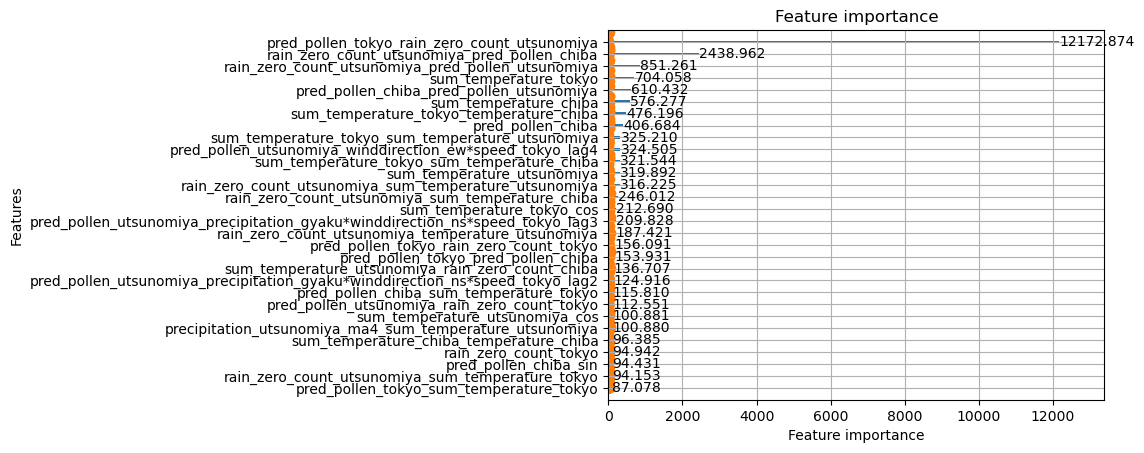

In [2947]:
#lgb_utsunomiya_0 = lgbm_s("utsunomiya",df_train_test_x_u,df_train_test_y_u,df_test_x_u,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_u_0" )
lgb_utsunomiya_0 = lgbm_o("utsunomiya",df_train_test_x_u,df_train_test_y_u,df_test_x_u,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_u_0" )

### ---1

In [2948]:
#train_travalをtrainとvalidに分割
df_traval_y_u_1 = df_train_traval_u_1[{"pollen_utsunomiya", "pollen_utsunomiya_cat"}]
df_traval_x_u_1 = df_train_traval_u_1.drop({"pollen_utsunomiya" ,"pollen_utsunomiya_cat", 
                                 "day", "month" 
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_u_1)
interaction_features = poly.get_feature_names(df_traval_x_u_1.columns)
df_traval_x_u_1 = pd.DataFrame(X_poly, columns=interaction_features)

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_u_1, df_traval_y_u_1, test_size=0.3, random_state=1234)

[I 2023-01-08 01:54:06,860] A new study created in memory with name: no-name-4fcfb5fb-653c-4cf1-93bb-005e8a22b3ce
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.85281e-07	valid_1's huber: 0.345855


feature_fraction, val_score: 0.345855:  14%|######2                                     | 1/7 [01:56<11:36, 116.03s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.345855:  29%|############8                                | 2/7 [02:40<06:09, 74.00s/it][I 2023-01-08 01:56:47,494] Trial 1 finished with value: 0.3477583096102346 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.34585481887630976.


Early stopping, best iteration is:
[350]	valid_0's huber: 0.00433974	valid_1's huber: 0.347758


feature_fraction, val_score: 0.345855:  29%|############8                                | 2/7 [02:40<06:09, 74.00s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[703]	valid_0's huber: 4.50458e-05	valid_1's huber: 0.351715


feature_fraction, val_score: 0.345855:  43%|###################2                         | 3/7 [03:39<04:28, 67.08s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	valid_0's huber: 0.000375403	valid_1's huber: 0.347285


feature_fraction, val_score: 0.345855:  57%|#########################7                   | 4/7 [04:35<03:08, 62.80s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[762]	valid_0's huber: 2.34309e-05	valid_1's huber: 0.346812


feature_fraction, val_score: 0.345855:  71%|################################1            | 5/7 [05:28<01:58, 59.22s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[544]	valid_0's huber: 0.000314077	valid_1's huber: 0.349937


feature_fraction, val_score: 0.345855:  86%|######################################5      | 6/7 [06:36<01:02, 62.02s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.345855:  86%|######################################5      | 6/7 [07:01<01:02, 62.02s/it]

Early stopping, best iteration is:
[412]	valid_0's huber: 0.00232106	valid_1's huber: 0.348536


num_leaves, val_score: 0.345855:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's huber: 0.00204201	valid_1's huber: 0.34068


num_leaves, val_score: 0.340680:   5%|##5                                               | 1/20 [01:32<29:24, 92.87s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[205]	valid_0's huber: 0.0006711	valid_1's huber: 0.350406


num_leaves, val_score: 0.340680:  10%|####9                                            | 2/20 [04:14<40:04, 133.58s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	valid_0's huber: 0.00148963	valid_1's huber: 0.35101


num_leaves, val_score: 0.340680:  15%|#######3                                         | 3/20 [06:03<34:34, 122.01s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[279]	valid_0's huber: 0.000356164	valid_1's huber: 0.350193


num_leaves, val_score: 0.340680:  20%|#########8                                       | 4/20 [07:57<31:40, 118.78s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	valid_0's huber: 0.000530633	valid_1's huber: 0.35047


num_leaves, val_score: 0.340680:  25%|############2                                    | 5/20 [10:18<31:45, 127.07s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's huber: 2.64077e-05	valid_1's huber: 0.347949


num_leaves, val_score: 0.340680:  30%|##############7                                  | 6/20 [12:16<28:52, 123.78s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[205]	valid_0's huber: 0.0006711	valid_1's huber: 0.350406


num_leaves, val_score: 0.340680:  35%|#################1                               | 7/20 [14:57<29:27, 135.96s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[205]	valid_0's huber: 0.0006711	valid_1's huber: 0.350406


num_leaves, val_score: 0.340680:  40%|###################6                             | 8/20 [17:37<28:46, 143.85s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[205]	valid_0's huber: 0.0006711	valid_1's huber: 0.350406


num_leaves, val_score: 0.340680:  45%|######################                           | 9/20 [20:19<27:22, 149.29s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.340680:  50%|########################                        | 10/20 [20:49<18:46, 112.64s/it]

Early stopping, best iteration is:
[394]	valid_0's huber: 0.0594889	valid_1's huber: 0.362042
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	valid_0's huber: 0.00291369	valid_1's huber: 0.352338


num_leaves, val_score: 0.340680:  55%|##########################4                     | 11/20 [22:40<16:49, 112.19s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[505]	valid_0's huber: 2.90858e-05	valid_1's huber: 0.342504


num_leaves, val_score: 0.340680:  60%|############################8                   | 12/20 [24:29<14:47, 110.98s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.340680:  60%|############################8                   | 12/20 [25:21<14:47, 110.98s/it]

Early stopping, best iteration is:
[105]	valid_0's huber: 0.021309	valid_1's huber: 0.346507


num_leaves, val_score: 0.340680:  65%|###############################8                 | 13/20 [25:21<10:51, 93.09s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.340680:  65%|###############################8                 | 13/20 [25:53<10:51, 93.09s/it]

Early stopping, best iteration is:
[545]	valid_0's huber: 0.0553527	valid_1's huber: 0.363911


num_leaves, val_score: 0.340680:  70%|##################################3              | 14/20 [25:53<07:28, 74.83s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's huber: 0.00161983	valid_1's huber: 0.348025


num_leaves, val_score: 0.340680:  75%|####################################7            | 15/20 [27:22<06:35, 79.11s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[563]	valid_0's huber: 2.89541e-05	valid_1's huber: 0.349569


num_leaves, val_score: 0.340680:  80%|#######################################2         | 16/20 [29:10<05:51, 87.79s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	valid_0's huber: 0.000333842	valid_1's huber: 0.346331


num_leaves, val_score: 0.340680:  85%|#########################################6       | 17/20 [31:17<04:58, 99.55s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	valid_0's huber: 0.00393315	valid_1's huber: 0.35366


num_leaves, val_score: 0.340680:  90%|###########################################2    | 18/20 [33:10<03:26, 103.43s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.340680:  90%|###########################################2    | 18/20 [34:08<03:26, 103.43s/it]

Early stopping, best iteration is:
[368]	valid_0's huber: 0.00266084	valid_1's huber: 0.344846


num_leaves, val_score: 0.340680:  95%|##############################################5  | 19/20 [34:08<01:30, 90.05s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	valid_0's huber: 0.000865143	valid_1's huber: 0.344004


bagging, val_score: 0.340680:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	valid_0's huber: 0.00482652	valid_1's huber: 0.366765


bagging, val_score: 0.340680:  10%|#####3                                               | 1/10 [01:35<14:21, 95.67s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	valid_0's huber: 0.00705945	valid_1's huber: 0.375433


bagging, val_score: 0.340680:  20%|##########6                                          | 2/10 [02:56<11:34, 86.85s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[348]	valid_0's huber: 0.00182429	valid_1's huber: 0.368473


bagging, val_score: 0.340680:  30%|###############6                                    | 3/10 [05:09<12:36, 108.08s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's huber: 0.0154998	valid_1's huber: 0.368401


bagging, val_score: 0.340680:  40%|#####################2                               | 4/10 [06:19<09:17, 92.91s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	valid_0's huber: 0.00215887	valid_1's huber: 0.35213


bagging, val_score: 0.340680:  50%|##########################5                          | 5/10 [07:55<07:50, 94.04s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[197]	valid_0's huber: 0.00878613	valid_1's huber: 0.370168


bagging, val_score: 0.340680:  60%|###############################8                     | 6/10 [09:16<05:58, 89.56s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	valid_0's huber: 0.00958075	valid_1's huber: 0.361171


bagging, val_score: 0.340680:  70%|#####################################                | 7/10 [10:33<04:16, 85.44s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	valid_0's huber: 0.00774666	valid_1's huber: 0.365926


bagging, val_score: 0.340680:  80%|##########################################4          | 8/10 [11:56<02:49, 84.90s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	valid_0's huber: 0.00246736	valid_1's huber: 0.356368


bagging, val_score: 0.340680:  90%|###############################################7     | 9/10 [13:34<01:28, 88.97s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's huber: 0.0163547	valid_1's huber: 0.36385


feature_fraction_stage2, val_score: 0.340680:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	valid_0's huber: 0.00159389	valid_1's huber: 0.350869


feature_fraction_stage2, val_score: 0.340680:  33%|############6                         | 1/3 [01:35<03:11, 95.72s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's huber: 0.000187371	valid_1's huber: 0.346912


feature_fraction_stage2, val_score: 0.340680:  67%|########################6            | 2/3 [03:56<02:02, 122.04s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	valid_0's huber: 0.00140659	valid_1's huber: 0.349531


regularization_factors, val_score: 0.340680:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	valid_0's huber: 0.00156255	valid_1's huber: 0.347847


regularization_factors, val_score: 0.340680:   5%|#8                                   | 1/20 [01:52<35:44, 112.89s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[235]	valid_0's huber: 0.000981976	valid_1's huber: 0.347839


regularization_factors, val_score: 0.340680:  10%|###8                                  | 2/20 [02:39<22:05, 73.61s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	valid_0's huber: 0.000483817	valid_1's huber: 0.338469


regularization_factors, val_score: 0.338469:  15%|#####5                               | 3/20 [04:56<29:06, 102.75s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[195]	valid_0's huber: 0.0006661	valid_1's huber: 0.348171


regularization_factors, val_score: 0.338469:  20%|#######6                              | 4/20 [06:04<23:42, 88.88s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[198]	valid_0's huber: 0.00085861	valid_1's huber: 0.347151


regularization_factors, val_score: 0.338469:  25%|#########2                           | 5/20 [08:10<25:37, 102.52s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	valid_0's huber: 0.000745154	valid_1's huber: 0.347607


regularization_factors, val_score: 0.338469:  30%|###########1                         | 6/20 [10:15<25:40, 110.07s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's huber: 0.00204201	valid_1's huber: 0.34068


regularization_factors, val_score: 0.338469:  35%|############9                        | 7/20 [11:55<23:07, 106.72s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[621]	valid_0's huber: 1.68042e-05	valid_1's huber: 0.343264


regularization_factors, val_score: 0.338469:  40%|##############8                      | 8/20 [15:37<28:40, 143.35s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	valid_0's huber: 0.000723771	valid_1's huber: 0.341887


regularization_factors, val_score: 0.338469:  45%|################6                    | 9/20 [17:41<25:11, 137.39s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[359]	valid_0's huber: 0.000155955	valid_1's huber: 0.343946


regularization_factors, val_score: 0.338469:  50%|##################                  | 10/20 [18:44<19:05, 114.54s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[443]	valid_0's huber: 0.000100628	valid_1's huber: 0.345657


regularization_factors, val_score: 0.338469:  55%|###################8                | 11/20 [22:12<21:28, 143.16s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's huber: 0.00204201	valid_1's huber: 0.34068


regularization_factors, val_score: 0.338469:  60%|#####################5              | 12/20 [23:55<17:27, 130.97s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	valid_0's huber: 0.000405948	valid_1's huber: 0.349877


regularization_factors, val_score: 0.338469:  65%|#######################4            | 13/20 [26:19<15:43, 134.85s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's huber: 0.00204201	valid_1's huber: 0.34068


regularization_factors, val_score: 0.338469:  70%|#########################2          | 14/20 [28:00<12:26, 124.44s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	valid_0's huber: 0.000572706	valid_1's huber: 0.348393


regularization_factors, val_score: 0.338469:  75%|###########################         | 15/20 [30:11<10:32, 126.47s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[467]	valid_0's huber: 7.26369e-05	valid_1's huber: 0.344649


regularization_factors, val_score: 0.338469:  80%|############################8       | 16/20 [33:59<10:28, 157.14s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	valid_0's huber: 0.0010661	valid_1's huber: 0.344741


regularization_factors, val_score: 0.338469:  85%|##############################6     | 17/20 [35:53<07:12, 144.01s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's huber: 0.00204201	valid_1's huber: 0.34068


regularization_factors, val_score: 0.338469:  90%|################################4   | 18/20 [37:32<04:21, 130.61s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	valid_0's huber: 0.00143228	valid_1's huber: 0.348338


regularization_factors, val_score: 0.338469:  95%|##################################1 | 19/20 [39:26<02:05, 125.69s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[212]	valid_0's huber: 0.000646491	valid_1's huber: 0.348127


min_data_in_leaf, val_score: 0.338469:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	valid_0's huber: 0.000550486	valid_1's huber: 0.3464


min_data_in_leaf, val_score: 0.338469:  20%|########8                                   | 1/5 [02:10<08:40, 130.22s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	valid_0's huber: 7.31484e-08	valid_1's huber: 0.346438


min_data_in_leaf, val_score: 0.338469:  40%|#################6                          | 2/5 [05:29<08:31, 170.60s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's huber: 0.00715823	valid_1's huber: 0.348819


min_data_in_leaf, val_score: 0.338469:  60%|##########################4                 | 3/5 [06:53<04:22, 131.38s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[484]	valid_0's huber: 0.00337562	valid_1's huber: 0.35247


min_data_in_leaf, val_score: 0.338469:  80%|###################################2        | 4/5 [08:05<01:47, 107.82s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.39608e-08	valid_1's huber: 0.34803


min_data_in_leaf, val_score: 0.338469: 100%|############################################| 5/5 [15:09<00:00, 181.84s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 1.2340568644540987e-05, 'lambda_l2': 0.11733672593957066, 'num_leaves': 108, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 16.50188881659851


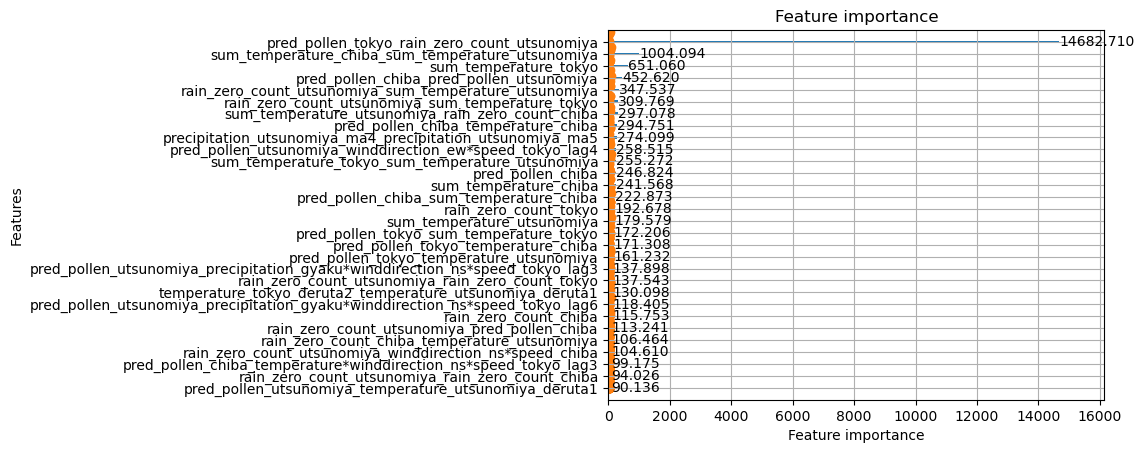

In [2949]:
#lgb_utsunomiya_1 = lgbm_s("utsunomiya",df_train_test_x_u,df_train_test_y_u,df_test_x_u,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_u_1" )
lgb_utsunomiya_1 = lgbm_o("utsunomiya",df_train_test_x_u,df_train_test_y_u,df_test_x_u,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_u_1" )

### ---2

In [2950]:
#train_travalをtrainとvalidに分割
df_traval_y_u_2 = df_train_traval_u_2[{"pollen_utsunomiya", "pollen_utsunomiya_cat"}]
df_traval_x_u_2 = df_train_traval_u_2.drop({"pollen_utsunomiya" ,"pollen_utsunomiya_cat", 
                                 "day", "month" 
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_u_2)
interaction_features = poly.get_feature_names(df_traval_x_u_2.columns)
df_traval_x_u_2 = pd.DataFrame(X_poly, columns=interaction_features)

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_u_2, df_traval_y_u_2, test_size=0.3, random_state=1234)

[I 2023-01-08 03:53:53,017] A new study created in memory with name: no-name-397a32ac-9fe7-41a1-9cdc-6e785dc17f06
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 7.13296e-05	valid_1's huber: 0.235946


feature_fraction, val_score: 0.235946:  14%|######4                                      | 1/7 [01:23<08:18, 83.01s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 7.29417e-05	valid_1's huber: 0.237703


feature_fraction, val_score: 0.235946:  29%|############5                               | 2/7 [03:31<09:07, 109.57s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.11228e-05	valid_1's huber: 0.237735


feature_fraction, val_score: 0.235946:  43%|##################8                         | 3/7 [05:14<07:07, 106.76s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 8.85078e-05	valid_1's huber: 0.238507


feature_fraction, val_score: 0.235946:  57%|#########################1                  | 4/7 [06:48<05:04, 101.66s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.18534e-05	valid_1's huber: 0.239908


feature_fraction, val_score: 0.235946:  71%|###############################4            | 5/7 [08:45<03:34, 107.29s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.14966e-05	valid_1's huber: 0.237406


feature_fraction, val_score: 0.235946:  86%|######################################5      | 6/7 [09:41<01:29, 89.79s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.606e-05	valid_1's huber: 0.237901


num_leaves, val_score: 0.235946:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.30535e-07	valid_1's huber: 0.240382


num_leaves, val_score: 0.235946:   5%|##3                                            | 1/20 [03:10<1:00:25, 190.84s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.61497e-05	valid_1's huber: 0.234777


num_leaves, val_score: 0.234777:  10%|####9                                            | 2/20 [04:34<38:17, 127.63s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	valid_0's huber: 5.81067e-05	valid_1's huber: 0.242401


num_leaves, val_score: 0.234777:  15%|#######3                                         | 3/20 [09:15<56:00, 197.69s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[440]	valid_0's huber: 6.54938e-05	valid_1's huber: 0.238648


num_leaves, val_score: 0.234777:  20%|#########8                                       | 4/20 [11:18<44:50, 168.14s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[419]	valid_0's huber: 8.08542e-05	valid_1's huber: 0.23855


num_leaves, val_score: 0.234777:  25%|############2                                    | 5/20 [13:56<41:09, 164.62s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.37796e-06	valid_1's huber: 0.24203


num_leaves, val_score: 0.234777:  30%|##############1                                | 6/20 [21:44<1:02:28, 267.77s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.38884e-05	valid_1's huber: 0.239377


num_leaves, val_score: 0.234777:  35%|#################1                               | 7/20 [23:25<46:13, 213.38s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.70654e-06	valid_1's huber: 0.23798


num_leaves, val_score: 0.234777:  40%|###################6                             | 8/20 [25:55<38:35, 193.00s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[770]	valid_0's huber: 7.65745e-06	valid_1's huber: 0.237555


num_leaves, val_score: 0.234777:  45%|######################                           | 9/20 [29:38<37:05, 202.29s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[359]	valid_0's huber: 9.7107e-05	valid_1's huber: 0.243875


num_leaves, val_score: 0.234777:  50%|########################                        | 10/20 [32:34<32:24, 194.45s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[418]	valid_0's huber: 7.01061e-05	valid_1's huber: 0.237183


num_leaves, val_score: 0.234777:  55%|##########################4                     | 11/20 [35:43<28:54, 192.70s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	valid_0's huber: 0.000145433	valid_1's huber: 0.239741


num_leaves, val_score: 0.234777:  60%|############################8                   | 12/20 [38:24<24:23, 182.97s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000811646	valid_1's huber: 0.243125


num_leaves, val_score: 0.234777:  65%|###############################2                | 13/20 [39:29<17:09, 147.13s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[449]	valid_0's huber: 4.40738e-05	valid_1's huber: 0.238657


num_leaves, val_score: 0.234777:  70%|#################################5              | 14/20 [42:45<16:11, 161.99s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.234777:  75%|####################################            | 15/20 [43:02<09:52, 118.45s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.275771	valid_1's huber: 0.370143
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[601]	valid_0's huber: 1.26505e-05	valid_1's huber: 0.236476


num_leaves, val_score: 0.234777:  80%|######################################4         | 16/20 [46:38<09:51, 147.81s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[408]	valid_0's huber: 8.30953e-05	valid_1's huber: 0.239839


num_leaves, val_score: 0.234777:  85%|########################################8       | 17/20 [49:08<07:25, 148.49s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.71916e-06	valid_1's huber: 0.237566


num_leaves, val_score: 0.234777:  90%|###########################################2    | 18/20 [51:32<04:53, 146.99s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.48552e-07	valid_1's huber: 0.238651


num_leaves, val_score: 0.234777:  95%|#############################################5  | 19/20 [56:47<03:17, 197.56s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[317]	valid_0's huber: 0.000164156	valid_1's huber: 0.244293


bagging, val_score: 0.234777:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.49968e-05	valid_1's huber: 0.238982


bagging, val_score: 0.234777:  10%|#####3                                               | 1/10 [01:28<13:19, 88.79s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.9451e-05	valid_1's huber: 0.251688


bagging, val_score: 0.234777:  20%|##########6                                          | 2/10 [02:53<11:30, 86.34s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.60355e-05	valid_1's huber: 0.241203


bagging, val_score: 0.234777:  30%|###############9                                     | 3/10 [04:20<10:07, 86.76s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.82454e-05	valid_1's huber: 0.237077


bagging, val_score: 0.234777:  40%|#####################2                               | 4/10 [05:45<08:35, 85.85s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.93398e-05	valid_1's huber: 0.240958


bagging, val_score: 0.234777:  50%|##########################5                          | 5/10 [07:12<07:11, 86.24s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.58488e-05	valid_1's huber: 0.240857


bagging, val_score: 0.234777:  60%|###############################8                     | 6/10 [08:38<05:45, 86.41s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.34805e-05	valid_1's huber: 0.24615


bagging, val_score: 0.234777:  70%|#####################################                | 7/10 [10:06<04:20, 86.73s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.38409e-05	valid_1's huber: 0.241943


bagging, val_score: 0.234777:  80%|##########################################4          | 8/10 [11:31<02:52, 86.32s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 8.21315e-05	valid_1's huber: 0.244175


bagging, val_score: 0.234777:  90%|###############################################7     | 9/10 [12:58<01:26, 86.46s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.317e-05	valid_1's huber: 0.248062


feature_fraction_stage2, val_score: 0.234777:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.62493e-05	valid_1's huber: 0.233271


feature_fraction_stage2, val_score: 0.233271:  17%|######3                               | 1/6 [01:22<06:51, 82.35s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.28028e-05	valid_1's huber: 0.240911


feature_fraction_stage2, val_score: 0.233271:  33%|############6                         | 2/6 [02:58<06:00, 90.21s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.05475e-05	valid_1's huber: 0.240478


feature_fraction_stage2, val_score: 0.233271:  50%|###################                   | 3/6 [04:29<04:31, 90.60s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.5885e-05	valid_1's huber: 0.238985


feature_fraction_stage2, val_score: 0.233271:  67%|#########################3            | 4/6 [05:55<02:57, 88.94s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 8.13363e-05	valid_1's huber: 0.238514


feature_fraction_stage2, val_score: 0.233271:  83%|###############################6      | 5/6 [07:13<01:25, 85.03s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.74392e-05	valid_1's huber: 0.240427


regularization_factors, val_score: 0.233271:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.62493e-05	valid_1's huber: 0.233271


regularization_factors, val_score: 0.233271:   5%|#9                                    | 1/20 [01:28<28:02, 88.55s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.0506e-05	valid_1's huber: 0.240343


regularization_factors, val_score: 0.233271:  10%|###8                                  | 2/20 [03:02<27:27, 91.51s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.47699e-05	valid_1's huber: 0.238092


regularization_factors, val_score: 0.233271:  15%|#####7                                | 3/20 [04:36<26:14, 92.61s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 7.57588e-05	valid_1's huber: 0.2377


regularization_factors, val_score: 0.233271:  20%|#######6                              | 4/20 [06:07<24:31, 91.96s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[731]	valid_0's huber: 0.00760578	valid_1's huber: 0.244029


regularization_factors, val_score: 0.233271:  25%|#########5                            | 5/20 [06:54<18:58, 75.90s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.03884e-05	valid_1's huber: 0.233655


regularization_factors, val_score: 0.233271:  30%|###########4                          | 6/20 [08:25<18:53, 80.98s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.74918e-05	valid_1's huber: 0.233861


regularization_factors, val_score: 0.233271:  35%|#############3                        | 7/20 [09:54<18:07, 83.63s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.65535e-05	valid_1's huber: 0.239818


regularization_factors, val_score: 0.233271:  40%|###############2                      | 8/20 [11:20<16:52, 84.37s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[804]	valid_0's huber: 0.00343641	valid_1's huber: 0.240069


regularization_factors, val_score: 0.233271:  45%|#################1                    | 9/20 [12:14<13:43, 74.85s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.04932e-05	valid_1's huber: 0.236579


regularization_factors, val_score: 0.233271:  50%|##################5                  | 10/20 [13:47<13:25, 80.54s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.61881e-05	valid_1's huber: 0.233944


regularization_factors, val_score: 0.233271:  55%|####################3                | 11/20 [15:19<12:35, 83.97s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.67417e-05	valid_1's huber: 0.233443


regularization_factors, val_score: 0.233271:  60%|######################2              | 12/20 [16:49<11:26, 85.85s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.62493e-05	valid_1's huber: 0.233271


regularization_factors, val_score: 0.233271:  65%|########################             | 13/20 [18:18<10:08, 86.90s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.62493e-05	valid_1's huber: 0.233271


regularization_factors, val_score: 0.233271:  70%|#########################9           | 14/20 [19:46<08:43, 87.18s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.62494e-05	valid_1's huber: 0.233271


regularization_factors, val_score: 0.233271:  75%|###########################7         | 15/20 [21:16<07:19, 87.96s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.62494e-05	valid_1's huber: 0.233271


regularization_factors, val_score: 0.233271:  80%|#############################6       | 16/20 [22:47<05:55, 88.96s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.61875e-05	valid_1's huber: 0.233944


regularization_factors, val_score: 0.233271:  85%|###############################4     | 17/20 [24:18<04:28, 89.56s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.93348e-05	valid_1's huber: 0.233524


regularization_factors, val_score: 0.233271:  90%|#################################3   | 18/20 [25:51<03:01, 90.70s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000135811	valid_1's huber: 0.240545


regularization_factors, val_score: 0.233271:  95%|###################################1 | 19/20 [27:27<01:32, 92.21s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.66312e-05	valid_1's huber: 0.233332


min_data_in_leaf, val_score: 0.233271:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.0835e-05	valid_1's huber: 0.235336


min_data_in_leaf, val_score: 0.233271:  20%|#########                                    | 1/5 [01:24<05:37, 84.37s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 7.77436e-05	valid_1's huber: 0.24082


min_data_in_leaf, val_score: 0.233271:  40%|##################                           | 2/5 [02:45<04:08, 82.70s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.65113e-05	valid_1's huber: 0.236125


min_data_in_leaf, val_score: 0.233271:  60%|###########################                  | 3/5 [04:14<02:50, 85.38s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000426909	valid_1's huber: 0.241907


min_data_in_leaf, val_score: 0.233271:  80%|####################################         | 4/5 [05:33<01:23, 83.02s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000219619	valid_1's huber: 0.240158


min_data_in_leaf, val_score: 0.233271: 100%|#############################################| 5/5 [06:54<00:00, 82.86s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 32, 'feature_fraction': 0.584, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 14.825879610919367


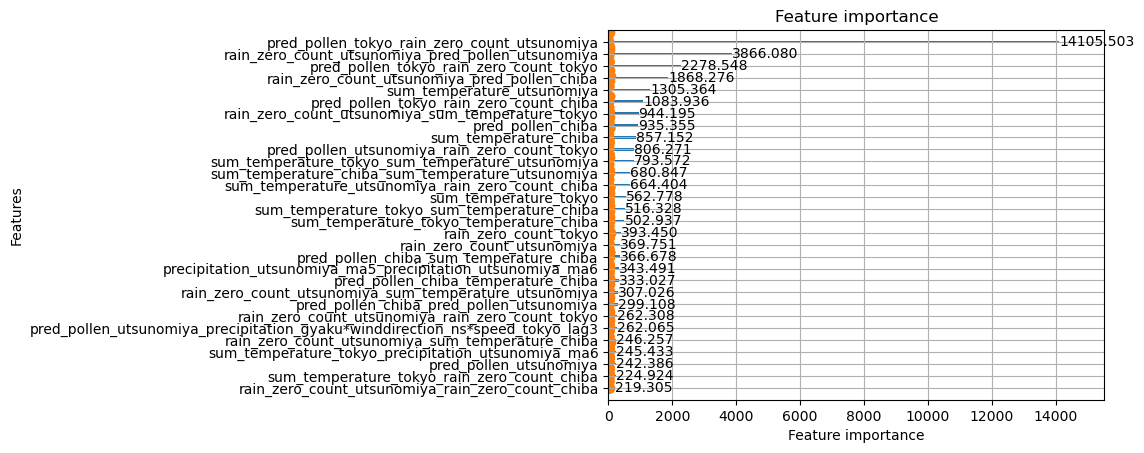

In [2951]:
#lgb_utsunomiya_2 = lgbm_s("utsunomiya",df_train_test_x_u,df_train_test_y_u,df_test_x_u,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_u_2" )
lgb_utsunomiya_2 = lgbm_o("utsunomiya",df_train_test_x_u,df_train_test_y_u,df_test_x_u,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_u_2" )

### ---Ave. CV

MAE
lgbm 15.16292773142887


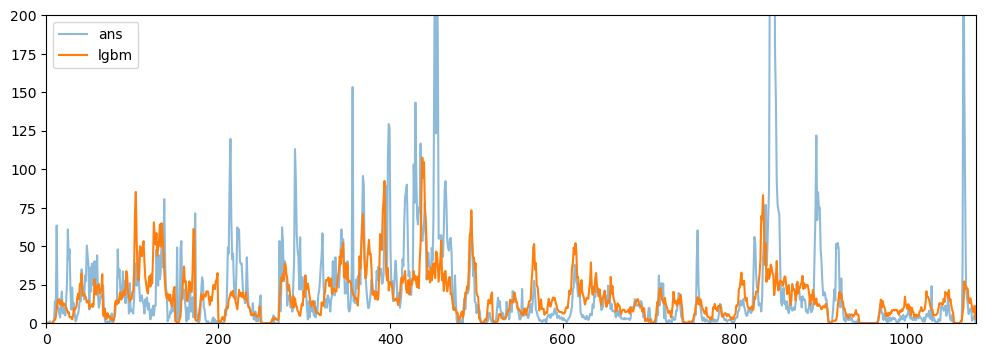

In [2952]:
r = 0

df_pred["pollen_"+region_list[r]+"_lgbm"] = (df_pred["pollen_"+region_list[r]+"_lgbm_u_0"]+df_pred["pollen_"+region_list[r]+"_lgbm_u_1"]+df_pred["pollen_"+region_list[r]+"_lgbm_u_2"])/3

plt.figure(figsize=(12,4))
plt.plot(np.array(df_train_test_y_u["pollen_"+region_list[r]]), alpha=0.5, label="ans")
plt.plot(df_pred["pollen_"+region_list[r]+"_lgbm"], label="lgbm")
plt.legend()
plt.xlim(0,len(df_pred))
plt.ylim(0,200)

print("MAE")
print("lgbm",mean_absolute_error(df_pred["pollen_"+region_list[r]+"_lgbm"], np.array(df_train_test_y_u["pollen_"+region_list[r]])))

In [2953]:
df_submission = pd.read_csv("sample_submission.csv")

In [2954]:
#sub
r = 0

### lgbm 
df_submission["pollen_"+region_list[r]] = (df_sub["pollen_"+region_list[r]+"_lgbm_u_0"]+df_sub["pollen_"+region_list[r]+"_lgbm_u_1"]+df_sub["pollen_"+region_list[r]+"_lgbm_u_2"])/3

#4の倍数にそろえる
for i in range(1000):
    df_submission["pollen_utsunomiya"][(df_submission["pollen_utsunomiya"] > i*4-2) & (df_submission["pollen_utsunomiya"] <= i*4+2)] = i*4

## chiba

In [2956]:
# 閾値3以下を分割(Statified k-fold)
X = df_train_traval_c_under.copy()
y= df_train_traval_c_under["pollen_chiba_cat"]
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

df_train_idx = pd.DataFrame()
df_valid_idx = pd.DataFrame()

print(skf)
for i, (train_index) in enumerate(skf.split(X, y)):
    df_train_idx[i] = train_index

StratifiedKFold(n_splits=3, random_state=42, shuffle=True)


In [2957]:
df_train_traval_c_0 = df_train_traval_c_under.loc[df_train_idx[0][1].tolist()]
df_train_traval_c_1 = df_train_traval_c_under.loc[df_train_idx[1][1].tolist()]
df_train_traval_c_2 = df_train_traval_c_under.loc[df_train_idx[2][1].tolist()]

df_train_traval_c_0 =pd.concat([df_train_traval_c_0, df_train_traval_c_1, df_train_traval_c_over], axis = 0)
df_train_traval_c_1 =pd.concat([df_train_traval_c_1, df_train_traval_c_2, df_train_traval_c_over], axis = 0)
df_train_traval_c_2 =pd.concat([df_train_traval_c_2, df_train_traval_c_0, df_train_traval_c_over], axis = 0)

### ---0

In [2958]:
#train_travalをtrainとvalidに分割
df_traval_y_c_0 = df_train_traval_c_0[{"pollen_chiba", "pollen_chiba_cat"}]
df_traval_x_c_0 = df_train_traval_c_0.drop({"pollen_chiba" ,"pollen_chiba_cat", 
                                 "day", "month" 
                                }, axis=1)

df_test_x_c = df_test_lgbm_c.drop({"pollen_chiba",
                                 "day", "month",
                                }, axis=1)
df_train_test_y_c = df_train_test_c[{"pollen_chiba", "pollen_chiba_cat"}]
df_train_test_x_c = df_train_test_c.drop({"pollen_chiba", "pollen_chiba_cat",
                                 "day", "month",
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_c_0)
interaction_features = poly.get_feature_names(df_traval_x_c_0.columns)
df_traval_x_c_0 = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_test_x_c)
interaction_features = poly.get_feature_names(df_test_x_c.columns)
df_test_x_c = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_train_test_x_c)
interaction_features = poly.get_feature_names(df_train_test_x_c.columns)
df_train_test_x_c = pd.DataFrame(X_poly, columns=interaction_features)

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_c_0, df_traval_y_c_0, test_size=0.3, random_state=42)

[I 2023-01-08 06:03:29,812] A new study created in memory with name: no-name-cf38b854-c4dd-434c-897e-08ffc8be54b4
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.426410:   0%|                                                     | 0/7 [00:27<?, ?it/s]

Early stopping, best iteration is:
[151]	valid_0's huber: 0.06981	valid_1's huber: 0.42641


feature_fraction, val_score: 0.426410:  14%|######4                                      | 1/7 [00:27<02:43, 27.18s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.426410:  29%|############8                                | 2/7 [01:19<03:30, 42.02s/it]

Early stopping, best iteration is:
[137]	valid_0's huber: 0.0768395	valid_1's huber: 0.429168


[I 2023-01-08 06:04:49,497] Trial 1 finished with value: 0.4291683693958904 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.42640996838742895.
feature_fraction, val_score: 0.426410:  29%|############8                                | 2/7 [01:19<03:30, 42.02s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.426410:  29%|############8                                | 2/7 [01:58<03:30, 42.02s/it]

Early stopping, best iteration is:
[199]	valid_0's huber: 0.0346604	valid_1's huber: 0.426842


feature_fraction, val_score: 0.426410:  43%|###################2                         | 3/7 [01:58<02:42, 40.53s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	valid_0's huber: 0.0360172	valid_1's huber: 0.431606


feature_fraction, val_score: 0.426410:  57%|#########################7                   | 4/7 [02:48<02:13, 44.45s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.426410:  57%|#########################7                   | 4/7 [03:25<02:13, 44.45s/it]

Early stopping, best iteration is:
[132]	valid_0's huber: 0.0852836	valid_1's huber: 0.428377


feature_fraction, val_score: 0.426410:  71%|################################1            | 5/7 [03:25<01:23, 41.69s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.426410:  71%|################################1            | 5/7 [04:12<01:23, 41.69s/it]

Early stopping, best iteration is:
[127]	valid_0's huber: 0.0876745	valid_1's huber: 0.430885


feature_fraction, val_score: 0.426410:  86%|######################################5      | 6/7 [04:12<00:43, 43.59s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.423194: 100%|#############################################| 7/7 [05:01<00:00, 45.24s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468431	valid_1's huber: 0.423194


[I 2023-01-08 06:08:31,374] Trial 6 finished with value: 0.42319390521153416 and parameters: {'feature_fraction': 0.8}. Best is trial 6 with value: 0.42319390521153416.
num_leaves, val_score: 0.423194:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	valid_0's huber: 0.00154522	valid_1's huber: 0.431711


num_leaves, val_score: 0.423194:   5%|##4                                              | 1/20 [02:47<53:05, 167.66s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	valid_0's huber: 0.00154522	valid_1's huber: 0.431711


num_leaves, val_score: 0.423194:  10%|####9                                            | 2/20 [05:41<51:20, 171.11s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	valid_0's huber: 0.0307332	valid_1's huber: 0.432095


num_leaves, val_score: 0.423194:  15%|#######3                                         | 3/20 [06:47<34:51, 123.06s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's huber: 0.00922147	valid_1's huber: 0.436643


num_leaves, val_score: 0.423194:  20%|#########8                                       | 4/20 [08:46<32:26, 121.64s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's huber: 0.00544482	valid_1's huber: 0.436383


num_leaves, val_score: 0.423194:  25%|############2                                    | 5/20 [10:56<31:10, 124.70s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	valid_0's huber: 0.00154522	valid_1's huber: 0.431711


num_leaves, val_score: 0.423194:  30%|##############7                                  | 6/20 [13:45<32:37, 139.84s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	valid_0's huber: 0.00154522	valid_1's huber: 0.431711


num_leaves, val_score: 0.423194:  35%|#################1                               | 7/20 [16:33<32:15, 148.89s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	valid_0's huber: 0.00176138	valid_1's huber: 0.426807


num_leaves, val_score: 0.423194:  40%|###################6                             | 8/20 [18:55<29:20, 146.71s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	valid_0's huber: 0.00113466	valid_1's huber: 0.428239


num_leaves, val_score: 0.423194:  45%|######################                           | 9/20 [21:33<27:34, 150.39s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	valid_0's huber: 0.00117222	valid_1's huber: 0.429978


num_leaves, val_score: 0.423194:  50%|########################                        | 10/20 [23:08<22:11, 133.13s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	valid_0's huber: 0.0117766	valid_1's huber: 0.424229


num_leaves, val_score: 0.423194:  55%|##########################4                     | 11/20 [24:44<18:15, 121.77s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	valid_0's huber: 0.000620539	valid_1's huber: 0.430672


num_leaves, val_score: 0.423194:  60%|############################8                   | 12/20 [27:00<16:48, 126.10s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's huber: 0.00313799	valid_1's huber: 0.428639


num_leaves, val_score: 0.423194:  65%|###############################2                | 13/20 [28:51<14:09, 121.40s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	valid_0's huber: 0.00202452	valid_1's huber: 0.429204


num_leaves, val_score: 0.423194:  70%|#################################5              | 14/20 [30:48<12:01, 120.21s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	valid_0's huber: 0.00164223	valid_1's huber: 0.429857


num_leaves, val_score: 0.423194:  75%|####################################            | 15/20 [32:58<10:16, 123.24s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.423194:  80%|#######################################2         | 16/20 [33:30<06:22, 95.58s/it][I 2023-01-08 06:42:01,526] Trial 22 finished with value: 0.43302077688080276 and parameters: {'num_leaves': 13}. Best is trial 17 with value: 0.42422878714177775.


Early stopping, best iteration is:
[249]	valid_0's huber: 0.145273	valid_1's huber: 0.433021


num_leaves, val_score: 0.423194:  80%|#######################################2         | 16/20 [33:30<06:22, 95.58s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's huber: 0.0900116	valid_1's huber: 0.429525


num_leaves, val_score: 0.423194:  85%|#########################################6       | 17/20 [34:23<04:08, 82.79s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	valid_0's huber: 0.00696023	valid_1's huber: 0.429099


num_leaves, val_score: 0.423194:  90%|############################################1    | 18/20 [35:50<02:48, 84.03s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	valid_0's huber: 0.00176138	valid_1's huber: 0.426807


num_leaves, val_score: 0.423194:  95%|#############################################5  | 19/20 [38:11<01:41, 101.15s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.0504136	valid_1's huber: 0.43832


bagging, val_score: 0.423194:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.423194:   0%|                                                             | 0/10 [00:39<?, ?it/s]

Early stopping, best iteration is:
[98]	valid_0's huber: 0.157013	valid_1's huber: 0.454054


bagging, val_score: 0.423194:  10%|#####3                                               | 1/10 [00:39<05:53, 39.29s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.423194:  10%|#####3                                               | 1/10 [01:30<05:53, 39.29s/it]

Early stopping, best iteration is:
[181]	valid_0's huber: 0.0417058	valid_1's huber: 0.429002


bagging, val_score: 0.423194:  20%|##########6                                          | 2/10 [01:30<06:11, 46.47s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.423194:  20%|##########6                                          | 2/10 [02:22<06:11, 46.47s/it]

Early stopping, best iteration is:
[179]	valid_0's huber: 0.0462655	valid_1's huber: 0.44823


bagging, val_score: 0.423194:  30%|###############9                                     | 3/10 [02:22<05:40, 48.65s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.423194:  30%|###############9                                     | 3/10 [03:04<05:40, 48.65s/it]

Early stopping, best iteration is:
[126]	valid_0's huber: 0.110074	valid_1's huber: 0.450555


bagging, val_score: 0.423194:  40%|#####################2                               | 4/10 [03:04<04:37, 46.22s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.423194:  40%|#####################2                               | 4/10 [03:46<04:37, 46.22s/it]

Early stopping, best iteration is:
[115]	valid_0's huber: 0.134367	valid_1's huber: 0.459217


bagging, val_score: 0.423194:  50%|##########################5                          | 5/10 [03:46<03:42, 44.55s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.423194:  50%|##########################5                          | 5/10 [04:34<03:42, 44.55s/it]

Early stopping, best iteration is:
[158]	valid_0's huber: 0.0610272	valid_1's huber: 0.436028


bagging, val_score: 0.423194:  60%|###############################8                     | 6/10 [04:34<03:03, 45.92s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.423194:  60%|###############################8                     | 6/10 [05:29<03:03, 45.92s/it]

Early stopping, best iteration is:
[192]	valid_0's huber: 0.0342174	valid_1's huber: 0.430038


bagging, val_score: 0.423194:  70%|#####################################                | 7/10 [05:29<02:26, 48.84s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.423194:  80%|##########################################4          | 8/10 [06:20<01:39, 49.62s/it]

Early stopping, best iteration is:
[166]	valid_0's huber: 0.0543055	valid_1's huber: 0.442872


[I 2023-01-08 06:53:50,898] Trial 34 finished with value: 0.44287152808796443 and parameters: {'bagging_fraction': 0.6514582670218025, 'bagging_freq': 4}. Best is trial 28 with value: 0.42900203025982375.
bagging, val_score: 0.423194:  80%|##########################################4          | 8/10 [06:20<01:39, 49.62s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.423194:  80%|##########################################4          | 8/10 [07:05<01:39, 49.62s/it]

Early stopping, best iteration is:
[116]	valid_0's huber: 0.112291	valid_1's huber: 0.442029


bagging, val_score: 0.423194:  90%|###############################################7     | 9/10 [07:05<00:48, 48.18s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.423194: 100%|####################################################| 10/10 [07:45<00:00, 45.64s/it]

Early stopping, best iteration is:
[101]	valid_0's huber: 0.132852	valid_1's huber: 0.443126


[I 2023-01-08 06:55:15,860] Trial 36 finished with value: 0.44312639017511046 and parameters: {'bagging_fraction': 0.7397253569320131, 'bagging_freq': 5}. Best is trial 28 with value: 0.42900203025982375.
feature_fraction_stage2, val_score: 0.423194:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.423194:   0%|                                              | 0/6 [00:40<?, ?it/s]

Early stopping, best iteration is:
[96]	valid_0's huber: 0.136776	valid_1's huber: 0.428155


feature_fraction_stage2, val_score: 0.423194:  17%|######3                               | 1/6 [00:40<03:21, 40.23s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.423194:  17%|######3                               | 1/6 [01:28<03:21, 40.23s/it]

Early stopping, best iteration is:
[177]	valid_0's huber: 0.0440804	valid_1's huber: 0.429006


feature_fraction_stage2, val_score: 0.423194:  33%|############6                         | 2/6 [01:28<02:59, 44.96s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.423194:  33%|############6                         | 2/6 [02:10<02:59, 44.96s/it]

Early stopping, best iteration is:
[125]	valid_0's huber: 0.0937199	valid_1's huber: 0.432493


feature_fraction_stage2, val_score: 0.423194:  50%|###################                   | 3/6 [02:10<02:11, 43.68s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.423194:  67%|#########################3            | 4/6 [02:56<01:29, 44.72s/it]

Early stopping, best iteration is:
[146]	valid_0's huber: 0.0698947	valid_1's huber: 0.431082


[I 2023-01-08 06:58:12,882] Trial 40 finished with value: 0.4310821149275268 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.42815456027959753.
feature_fraction_stage2, val_score: 0.423194:  67%|#########################3            | 4/6 [02:57<01:29, 44.72s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.423194:  67%|#########################3            | 4/6 [04:03<01:29, 44.72s/it]

Early stopping, best iteration is:
[250]	valid_0's huber: 0.0141779	valid_1's huber: 0.429143


feature_fraction_stage2, val_score: 0.423194:  83%|###############################6      | 5/6 [04:03<00:52, 52.44s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.423194: 100%|######################################| 6/6 [04:46<00:00, 49.51s/it]

Early stopping, best iteration is:
[131]	valid_0's huber: 0.0847201	valid_1's huber: 0.428248


[I 2023-01-08 07:00:02,838] Trial 42 finished with value: 0.4282478553858612 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 0.42815456027959753.
regularization_factors, val_score: 0.423194:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:   0%|                                              | 0/20 [00:59<?, ?it/s]

Early stopping, best iteration is:
[180]	valid_0's huber: 0.0427313	valid_1's huber: 0.429816


regularization_factors, val_score: 0.423194:   5%|#9                                    | 1/20 [00:59<18:45, 59.23s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:   5%|#9                                    | 1/20 [02:00<18:45, 59.23s/it]

Early stopping, best iteration is:
[183]	valid_0's huber: 0.0398013	valid_1's huber: 0.428384


regularization_factors, val_score: 0.423194:  10%|###8                                  | 2/20 [02:00<18:03, 60.20s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  10%|###8                                  | 2/20 [02:47<18:03, 60.20s/it]

Early stopping, best iteration is:
[275]	valid_0's huber: 0.038849	valid_1's huber: 0.427663


regularization_factors, val_score: 0.423194:  15%|#####7                                | 3/20 [02:47<15:23, 54.32s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  15%|#####7                                | 3/20 [03:33<15:23, 54.32s/it]

Early stopping, best iteration is:
[104]	valid_0's huber: 0.126989	valid_1's huber: 0.435234


regularization_factors, val_score: 0.423194:  20%|#######6                              | 4/20 [03:33<13:36, 51.05s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  20%|#######6                              | 4/20 [04:29<13:36, 51.05s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468432	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  25%|#########5                            | 5/20 [04:29<13:12, 52.83s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  25%|#########5                            | 5/20 [05:12<13:12, 52.83s/it]

Early stopping, best iteration is:
[147]	valid_0's huber: 0.092777	valid_1's huber: 0.428653


regularization_factors, val_score: 0.423194:  30%|###########4                          | 6/20 [05:12<11:32, 49.44s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  30%|###########4                          | 6/20 [06:06<11:32, 49.44s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468431	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  35%|#############3                        | 7/20 [06:06<11:03, 51.07s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	valid_0's huber: 0.059288	valid_1's huber: 0.427659


regularization_factors, val_score: 0.423194:  40%|###############2                      | 8/20 [07:01<10:27, 52.26s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  40%|###############2                      | 8/20 [07:53<10:27, 52.26s/it]

Early stopping, best iteration is:
[130]	valid_0's huber: 0.0911928	valid_1's huber: 0.425492


regularization_factors, val_score: 0.423194:  45%|#################1                    | 9/20 [07:53<09:35, 52.28s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  45%|#################1                    | 9/20 [08:50<09:35, 52.28s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468452	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  50%|##################5                  | 10/20 [08:50<08:55, 53.50s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  50%|##################5                  | 10/20 [09:46<08:55, 53.50s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468431	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  55%|####################3                | 11/20 [09:46<08:08, 54.32s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  55%|####################3                | 11/20 [10:41<08:08, 54.32s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468431	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  60%|######################2              | 12/20 [10:41<07:15, 54.47s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  60%|######################2              | 12/20 [11:34<07:15, 54.47s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468431	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  65%|########################             | 13/20 [11:34<06:19, 54.22s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  65%|########################             | 13/20 [12:31<06:19, 54.22s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468431	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  70%|#########################9           | 14/20 [12:31<05:29, 54.90s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  70%|#########################9           | 14/20 [13:29<05:29, 54.90s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468431	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  75%|###########################7         | 15/20 [13:29<04:39, 55.91s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  75%|###########################7         | 15/20 [14:24<04:39, 55.91s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468436	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  80%|#############################6       | 16/20 [14:24<03:42, 55.75s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  80%|#############################6       | 16/20 [15:19<03:42, 55.75s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468431	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  85%|###############################4     | 17/20 [15:19<02:46, 55.39s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194:  85%|###############################4     | 17/20 [16:15<02:46, 55.39s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468434	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  90%|#################################3   | 18/20 [16:15<01:51, 55.66s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468437	valid_1's huber: 0.423194


regularization_factors, val_score: 0.423194:  95%|###################################1 | 19/20 [17:11<00:55, 55.83s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.423194: 100%|#####################################| 20/20 [18:07<00:00, 55.69s/it]

Early stopping, best iteration is:
[174]	valid_0's huber: 0.0468432	valid_1's huber: 0.423194


[I 2023-01-08 07:18:10,175] Trial 62 finished with value: 0.42319391655012284 and parameters: {'lambda_l1': 1.788984506471936e-05, 'lambda_l2': 2.2899529375477607e-07}. Best is trial 56 with value: 0.42319390532405265.
min_data_in_leaf, val_score: 0.423194:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.423194:   0%|                                                     | 0/5 [00:40<?, ?it/s]

Early stopping, best iteration is:
[138]	valid_0's huber: 0.0828919	valid_1's huber: 0.432365


min_data_in_leaf, val_score: 0.423194:  20%|#########                                    | 1/5 [00:40<02:42, 40.69s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.423194:  40%|##################                           | 2/5 [01:23<02:05, 41.97s/it]

Early stopping, best iteration is:
[104]	valid_0's huber: 0.120556	valid_1's huber: 0.432879


[I 2023-01-08 07:19:33,792] Trial 64 finished with value: 0.4328788237253721 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.43236468409637124.
min_data_in_leaf, val_score: 0.423194:  40%|##################                           | 2/5 [01:23<02:05, 41.97s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.423194:  40%|##################                           | 2/5 [02:05<02:05, 41.97s/it]

Early stopping, best iteration is:
[122]	valid_0's huber: 0.0973306	valid_1's huber: 0.428844


min_data_in_leaf, val_score: 0.423194:  60%|###########################                  | 3/5 [02:05<01:24, 42.12s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.423194:  60%|###########################                  | 3/5 [03:12<01:24, 42.12s/it]

Early stopping, best iteration is:
[247]	valid_0's huber: 0.0139773	valid_1's huber: 0.431688


min_data_in_leaf, val_score: 0.423194:  80%|####################################         | 4/5 [03:12<00:51, 51.76s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.423194: 100%|#############################################| 5/5 [03:59<00:00, 50.22s/it]

Early stopping, best iteration is:
[195]	valid_0's huber: 0.047902	valid_1's huber: 0.435427


[I 2023-01-08 07:22:10,156] Trial 67 finished with value: 0.4354273049918527 and parameters: {'min_child_samples': 100}. Best is trial 65 with value: 0.42884407485128967.
min_data_in_leaf, val_score: 0.423194: 100%|#############################################| 5/5 [03:59<00:00, 48.00s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 10.174582210093604


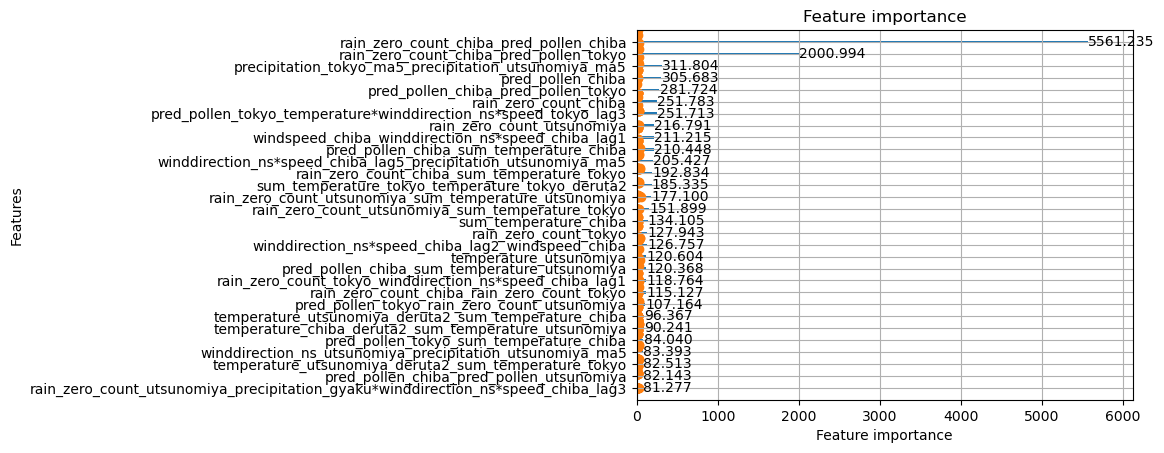

In [2959]:
#lgb_chiba_0 = lgbm_s("chiba",df_train_test_x_c,df_train_test_y_c,df_test_x_c,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_c_0" )
lgb_chiba_0 = lgbm_o("chiba",df_train_test_x_c,df_train_test_y_c,df_test_x_c,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_c_0" )

### ---1

In [2960]:
#train_travalをtrainとvalidに分割
df_traval_y_c_1 = df_train_traval_c_1[{"pollen_chiba", "pollen_chiba_cat"}]
df_traval_x_c_1 = df_train_traval_c_1.drop({"pollen_chiba" ,"pollen_chiba_cat", 
                                 "day", "month" 
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_c_1)
interaction_features = poly.get_feature_names(df_traval_x_c_1.columns)
df_traval_x_c_1 = pd.DataFrame(X_poly, columns=interaction_features)

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_c_1, df_traval_y_c_1, test_size=0.3, random_state=42)

[I 2023-01-08 07:22:11,587] A new study created in memory with name: no-name-d3bc4f7d-14ce-4bd4-8d46-446bdd306f89
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[253]	valid_0's huber: 0.0137226	valid_1's huber: 0.407001


feature_fraction, val_score: 0.407001:  14%|######4                                      | 1/7 [00:51<05:08, 51.35s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.407001:  14%|######4                                      | 1/7 [01:21<05:08, 51.35s/it]

Early stopping, best iteration is:
[172]	valid_0's huber: 0.052963	valid_1's huber: 0.407052


feature_fraction, val_score: 0.407001:  29%|############8                                | 2/7 [01:21<03:15, 39.10s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.407001:  29%|############8                                | 2/7 [02:06<03:15, 39.10s/it]

Early stopping, best iteration is:
[136]	valid_0's huber: 0.0780867	valid_1's huber: 0.409865


feature_fraction, val_score: 0.407001:  43%|###################2                         | 3/7 [02:06<02:46, 41.51s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.404293:  43%|###################2                         | 3/7 [03:05<02:46, 41.51s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.0412123	valid_1's huber: 0.404293


feature_fraction, val_score: 0.404293:  57%|#########################7                   | 4/7 [03:05<02:25, 48.34s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.404293:  57%|#########################7                   | 4/7 [03:47<02:25, 48.34s/it]

Early stopping, best iteration is:
[148]	valid_0's huber: 0.0671201	valid_1's huber: 0.408492


feature_fraction, val_score: 0.404293:  71%|################################1            | 5/7 [03:47<01:32, 46.27s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	valid_0's huber: 0.0299835	valid_1's huber: 0.405332


feature_fraction, val_score: 0.404293:  86%|######################################5      | 6/7 [04:49<00:51, 51.56s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.404293:  86%|######################################5      | 6/7 [05:31<00:51, 51.56s/it]

Early stopping, best iteration is:
[226]	valid_0's huber: 0.0224864	valid_1's huber: 0.40961


num_leaves, val_score: 0.404293:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	valid_0's huber: 0.00765473	valid_1's huber: 0.406955


num_leaves, val_score: 0.404293:   5%|##5                                               | 1/20 [01:36<30:34, 96.54s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's huber: 0.0111028	valid_1's huber: 0.407823


num_leaves, val_score: 0.404293:  10%|#####                                             | 2/20 [03:07<27:54, 93.06s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	valid_0's huber: 0.0122899	valid_1's huber: 0.41875


num_leaves, val_score: 0.404293:  15%|#######3                                         | 3/20 [04:59<28:54, 102.05s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	valid_0's huber: 0.000775694	valid_1's huber: 0.4154


num_leaves, val_score: 0.404293:  20%|#########8                                       | 4/20 [08:46<40:20, 151.25s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	valid_0's huber: 0.00219064	valid_1's huber: 0.418162


num_leaves, val_score: 0.404293:  25%|############2                                    | 5/20 [11:55<41:12, 164.85s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	valid_0's huber: 0.0022991	valid_1's huber: 0.405934


num_leaves, val_score: 0.404293:  30%|##############7                                  | 6/20 [13:42<33:50, 145.05s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's huber: 0.00285693	valid_1's huber: 0.418717


num_leaves, val_score: 0.404293:  35%|#################1                               | 7/20 [16:00<30:54, 142.69s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's huber: 0.0120193	valid_1's huber: 0.412144


num_leaves, val_score: 0.404293:  40%|###################6                             | 8/20 [17:34<25:27, 127.32s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	valid_0's huber: 0.000775694	valid_1's huber: 0.4154


num_leaves, val_score: 0.404293:  45%|######################                           | 9/20 [21:19<28:57, 157.97s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	valid_0's huber: 0.00050529	valid_1's huber: 0.415365


num_leaves, val_score: 0.404293:  50%|########################                        | 10/20 [25:28<31:00, 186.07s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.404293:  50%|########################                        | 10/20 [26:25<31:00, 186.07s/it]

Early stopping, best iteration is:
[344]	valid_0's huber: 0.0373523	valid_1's huber: 0.406514


num_leaves, val_score: 0.404293:  55%|##########################4                     | 11/20 [26:25<21:58, 146.48s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.404293:  55%|##########################4                     | 11/20 [27:15<21:58, 146.48s/it]

Early stopping, best iteration is:
[370]	valid_0's huber: 0.0648936	valid_1's huber: 0.408294


num_leaves, val_score: 0.404293:  60%|############################8                   | 12/20 [27:15<15:36, 117.12s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.404293:  65%|###############################8                 | 13/20 [27:34<10:11, 87.42s/it][I 2023-01-08 07:55:17,477] Trial 19 finished with value: 0.4575853151351028 and parameters: {'num_leaves': 2}. Best is trial 12 with value: 0.40593431941577945.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.392763	valid_1's huber: 0.457585


num_leaves, val_score: 0.404293:  65%|###############################8                 | 13/20 [27:34<10:11, 87.42s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.404293:  65%|###############################8                 | 13/20 [28:33<10:11, 87.42s/it]

Early stopping, best iteration is:
[97]	valid_0's huber: 0.0790357	valid_1's huber: 0.411445


num_leaves, val_score: 0.404293:  70%|##################################3              | 14/20 [28:33<07:53, 78.93s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.404293:  70%|##################################3              | 14/20 [29:32<07:53, 78.93s/it]

Early stopping, best iteration is:
[143]	valid_0's huber: 0.0553862	valid_1's huber: 0.406759


num_leaves, val_score: 0.404293:  75%|####################################7            | 15/20 [29:32<06:03, 72.73s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's huber: 0.000864311	valid_1's huber: 0.415928


num_leaves, val_score: 0.404293:  80%|######################################4         | 16/20 [32:41<07:11, 107.83s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's huber: 0.00146564	valid_1's huber: 0.414038


num_leaves, val_score: 0.404293:  85%|########################################8       | 17/20 [34:58<05:49, 116.62s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.404293:  85%|########################################8       | 17/20 [35:59<05:49, 116.62s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.0412123	valid_1's huber: 0.404293


num_leaves, val_score: 0.404293:  90%|############################################1    | 18/20 [35:59<03:19, 99.74s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's huber: 0.00284556	valid_1's huber: 0.418768


num_leaves, val_score: 0.404293:  95%|#############################################5  | 19/20 [38:31<01:55, 115.61s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	valid_0's huber: 0.0220375	valid_1's huber: 0.408105


bagging, val_score: 0.404293:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.404293:   0%|                                                             | 0/10 [00:52<?, ?it/s]

Early stopping, best iteration is:
[128]	valid_0's huber: 0.090344	valid_1's huber: 0.419511


bagging, val_score: 0.404293:  10%|#####3                                               | 1/10 [00:52<07:51, 52.43s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.404293:  10%|#####3                                               | 1/10 [01:48<07:51, 52.43s/it]

Early stopping, best iteration is:
[164]	valid_0's huber: 0.0670283	valid_1's huber: 0.431976


bagging, val_score: 0.404293:  20%|##########6                                          | 2/10 [01:48<07:16, 54.56s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.404293:  20%|##########6                                          | 2/10 [02:46<07:16, 54.56s/it]

Early stopping, best iteration is:
[155]	valid_0's huber: 0.0589441	valid_1's huber: 0.410319


bagging, val_score: 0.404293:  30%|###############9                                     | 3/10 [02:46<06:34, 56.30s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.404293:  30%|###############9                                     | 3/10 [03:40<06:34, 56.30s/it]

Early stopping, best iteration is:
[135]	valid_0's huber: 0.0853112	valid_1's huber: 0.422446


bagging, val_score: 0.404293:  40%|#####################2                               | 4/10 [03:40<05:31, 55.17s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.404293:  50%|##########################5                          | 5/10 [04:39<04:44, 56.80s/it]

Early stopping, best iteration is:
[171]	valid_0's huber: 0.0463612	valid_1's huber: 0.410115


[I 2023-01-08 08:12:14,207] Trial 31 finished with value: 0.4101154794899851 and parameters: {'bagging_fraction': 0.8947053397684951, 'bagging_freq': 4}. Best is trial 31 with value: 0.4101154794899851.
bagging, val_score: 0.404293:  50%|##########################5                          | 5/10 [04:40<04:44, 56.80s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.404293:  50%|##########################5                          | 5/10 [05:38<04:44, 56.80s/it]

Early stopping, best iteration is:
[165]	valid_0's huber: 0.056523	valid_1's huber: 0.424639


bagging, val_score: 0.404293:  60%|###############################8                     | 6/10 [05:38<03:49, 57.50s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.404293:  60%|###############################8                     | 6/10 [06:38<03:49, 57.50s/it]

Early stopping, best iteration is:
[175]	valid_0's huber: 0.0529627	valid_1's huber: 0.422546


bagging, val_score: 0.404293:  70%|#####################################                | 7/10 [06:38<02:54, 58.19s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.404293:  70%|#####################################                | 7/10 [07:28<02:54, 58.19s/it]

Early stopping, best iteration is:
[116]	valid_0's huber: 0.10885	valid_1's huber: 0.417823


bagging, val_score: 0.404293:  80%|##########################################4          | 8/10 [07:28<01:50, 55.46s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.404293:  80%|##########################################4          | 8/10 [08:22<01:50, 55.46s/it]

Early stopping, best iteration is:
[140]	valid_0's huber: 0.0727821	valid_1's huber: 0.407718


bagging, val_score: 0.404293:  90%|###############################################7     | 9/10 [08:22<00:55, 55.17s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.404293: 100%|####################################################| 10/10 [09:05<00:00, 51.32s/it]

Early stopping, best iteration is:
[83]	valid_0's huber: 0.19837	valid_1's huber: 0.443909


[I 2023-01-08 08:16:39,521] Trial 36 finished with value: 0.4439085312836951 and parameters: {'bagging_fraction': 0.4177976080425268, 'bagging_freq': 6}. Best is trial 35 with value: 0.4077182850954179.
feature_fraction_stage2, val_score: 0.404293:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.404293:  33%|############6                         | 1/3 [00:45<01:31, 45.59s/it]

Early stopping, best iteration is:
[102]	valid_0's huber: 0.125405	valid_1's huber: 0.410473


[I 2023-01-08 08:17:25,191] Trial 37 finished with value: 0.41047253675443385 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.41047253675443385.
feature_fraction_stage2, val_score: 0.404293:  33%|############6                         | 1/3 [00:45<01:31, 45.59s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.404293:  33%|############6                         | 1/3 [01:39<01:31, 45.59s/it]

Early stopping, best iteration is:
[165]	valid_0's huber: 0.0516438	valid_1's huber: 0.411033


feature_fraction_stage2, val_score: 0.404293:  67%|#########################3            | 2/3 [01:39<00:50, 50.45s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.404293:  67%|#########################3            | 2/3 [02:42<00:50, 50.45s/it]

Early stopping, best iteration is:
[192]	valid_0's huber: 0.0339566	valid_1's huber: 0.406361


regularization_factors, val_score: 0.404293:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:   0%|                                              | 0/20 [00:58<?, ?it/s]

Early stopping, best iteration is:
[135]	valid_0's huber: 0.0774429	valid_1's huber: 0.40531


regularization_factors, val_score: 0.404293:   5%|#9                                    | 1/20 [00:58<18:30, 58.45s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:   5%|#9                                    | 1/20 [02:00<18:30, 58.45s/it]

Early stopping, best iteration is:
[140]	valid_0's huber: 0.0729982	valid_1's huber: 0.408518


regularization_factors, val_score: 0.404293:  10%|###8                                  | 2/20 [02:00<18:05, 60.31s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  10%|###8                                  | 2/20 [03:05<18:05, 60.31s/it]

Early stopping, best iteration is:
[154]	valid_0's huber: 0.0616604	valid_1's huber: 0.40839


regularization_factors, val_score: 0.404293:  15%|#####7                                | 3/20 [03:05<17:43, 62.56s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  15%|#####7                                | 3/20 [04:04<17:43, 62.56s/it]

Early stopping, best iteration is:
[135]	valid_0's huber: 0.0774425	valid_1's huber: 0.40531


regularization_factors, val_score: 0.404293:  20%|#######6                              | 4/20 [04:04<16:19, 61.22s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[283]	valid_0's huber: 0.00810145	valid_1's huber: 0.408278


regularization_factors, val_score: 0.404293:  25%|#########5                            | 5/20 [05:29<17:27, 69.84s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	valid_0's huber: 0.00313085	valid_1's huber: 0.407483


regularization_factors, val_score: 0.404293:  30%|###########4                          | 6/20 [07:16<19:13, 82.36s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  30%|###########4                          | 6/20 [08:23<19:13, 82.36s/it]

Early stopping, best iteration is:
[170]	valid_0's huber: 0.0472084	valid_1's huber: 0.406502


regularization_factors, val_score: 0.404293:  35%|#############3                        | 7/20 [08:23<16:45, 77.37s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  35%|#############3                        | 7/20 [09:29<16:45, 77.37s/it]

Early stopping, best iteration is:
[173]	valid_0's huber: 0.0456902	valid_1's huber: 0.408187


regularization_factors, val_score: 0.404293:  40%|###############2                      | 8/20 [09:29<14:46, 73.89s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  40%|###############2                      | 8/20 [10:34<14:46, 73.89s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.0412124	valid_1's huber: 0.404293


regularization_factors, val_score: 0.404293:  45%|#################1                    | 9/20 [10:34<12:59, 70.88s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  45%|#################1                    | 9/20 [11:37<12:59, 70.88s/it]

Early stopping, best iteration is:
[156]	valid_0's huber: 0.0576344	valid_1's huber: 0.406841


regularization_factors, val_score: 0.404293:  50%|##################5                  | 10/20 [11:37<11:25, 68.56s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  50%|##################5                  | 10/20 [12:46<11:25, 68.56s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.0412123	valid_1's huber: 0.404293


regularization_factors, val_score: 0.404293:  55%|####################3                | 11/20 [12:46<10:17, 68.64s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  60%|######################2              | 12/20 [13:55<09:09, 68.71s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.0412124	valid_1's huber: 0.404293


[I 2023-01-08 08:33:17,618] Trial 51 finished with value: 0.4042929713812163 and parameters: {'lambda_l1': 1.4581846860646411e-08, 'lambda_l2': 3.970540440878735e-05}. Best is trial 50 with value: 0.4042929690644072.
regularization_factors, val_score: 0.404293:  60%|######################2              | 12/20 [13:55<09:09, 68.71s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  60%|######################2              | 12/20 [15:03<09:09, 68.71s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.0412124	valid_1's huber: 0.404293


regularization_factors, val_score: 0.404293:  65%|########################             | 13/20 [15:03<07:59, 68.54s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  65%|########################             | 13/20 [16:10<07:59, 68.54s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.0412123	valid_1's huber: 0.404293


regularization_factors, val_score: 0.404293:  70%|#########################9           | 14/20 [16:10<06:49, 68.17s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  70%|#########################9           | 14/20 [17:16<06:49, 68.17s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.0412123	valid_1's huber: 0.404293


regularization_factors, val_score: 0.404293:  75%|###########################7         | 15/20 [17:16<05:37, 67.45s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  75%|###########################7         | 15/20 [18:24<05:37, 67.45s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.0412123	valid_1's huber: 0.404293


regularization_factors, val_score: 0.404293:  80%|#############################6       | 16/20 [18:25<04:31, 67.80s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  80%|#############################6       | 16/20 [19:31<04:31, 67.80s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.0412123	valid_1's huber: 0.404293


regularization_factors, val_score: 0.404293:  85%|###############################4     | 17/20 [19:32<03:22, 67.54s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  85%|###############################4     | 17/20 [20:39<03:22, 67.54s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.0412123	valid_1's huber: 0.404293


regularization_factors, val_score: 0.404293:  90%|#################################3   | 18/20 [20:39<02:14, 67.45s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  90%|#################################3   | 18/20 [21:41<02:14, 67.45s/it]

Early stopping, best iteration is:
[146]	valid_0's huber: 0.0676803	valid_1's huber: 0.410681


regularization_factors, val_score: 0.404293:  95%|###################################1 | 19/20 [21:41<01:05, 65.88s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.404293:  95%|###################################1 | 19/20 [22:51<01:05, 65.88s/it]

Early stopping, best iteration is:
[184]	valid_0's huber: 0.0379976	valid_1's huber: 0.410132


min_data_in_leaf, val_score: 0.404293:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[550]	valid_0's huber: 0.00011455	valid_1's huber: 0.411805


min_data_in_leaf, val_score: 0.404293:  20%|########8                                   | 1/5 [02:14<08:58, 134.62s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.404293:  20%|########8                                   | 1/5 [03:16<08:58, 134.62s/it]

Early stopping, best iteration is:
[179]	valid_0's huber: 0.0426824	valid_1's huber: 0.409264


min_data_in_leaf, val_score: 0.404293:  40%|##################                           | 2/5 [03:16<04:36, 92.04s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.404293:  40%|##################                           | 2/5 [04:11<04:36, 92.04s/it]

Early stopping, best iteration is:
[187]	valid_0's huber: 0.0498635	valid_1's huber: 0.415802


min_data_in_leaf, val_score: 0.404293:  60%|###########################                  | 3/5 [04:11<02:29, 74.85s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.404293:  60%|###########################                  | 3/5 [05:40<02:29, 74.85s/it]

Early stopping, best iteration is:
[282]	valid_0's huber: 0.00676729	valid_1's huber: 0.410812


min_data_in_leaf, val_score: 0.404293:  80%|####################################         | 4/5 [05:40<01:20, 80.35s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.404293:  80%|####################################         | 4/5 [06:27<01:20, 80.35s/it]

Early stopping, best iteration is:
[129]	valid_0's huber: 0.0912132	valid_1's huber: 0.407664


min_data_in_leaf, val_score: 0.404293: 100%|#############################################| 5/5 [06:27<00:00, 77.60s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 9.873093871582034


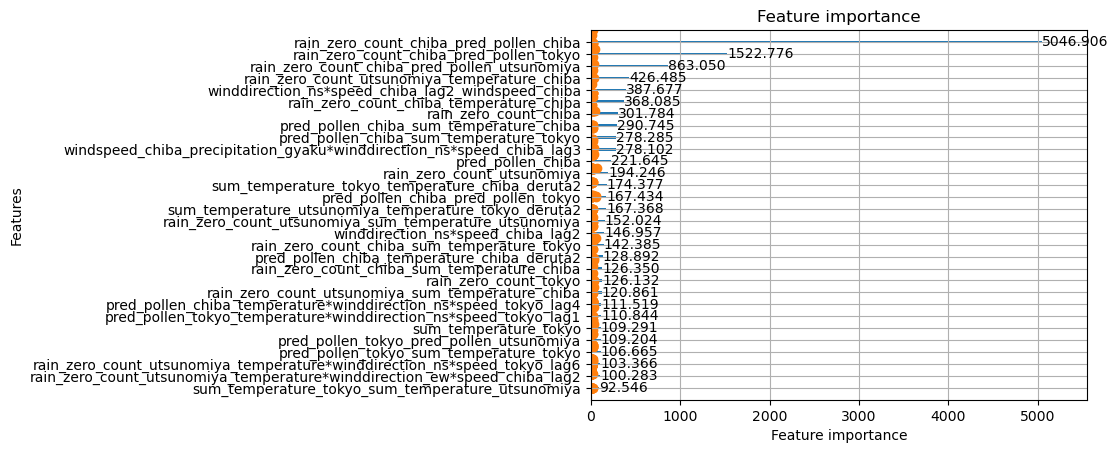

In [2961]:
#lgb_chiba_1 = lgbm_s("chiba",df_train_test_x_c,df_train_test_y_c,df_test_x_c,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_c_1" )
lgb_chiba_1 = lgbm_o("chiba",df_train_test_x_c,df_train_test_y_c,df_test_x_c,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_c_1" )

### ---2

In [2962]:
#train_travalをtrainとvalidに分割
df_traval_y_c_2 = df_train_traval_c_2[{"pollen_chiba", "pollen_chiba_cat"}]
df_traval_x_c_2 = df_train_traval_c_2.drop({"pollen_chiba" ,"pollen_chiba_cat", 
                                 "day", "month" 
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_c_2)
interaction_features = poly.get_feature_names(df_traval_x_c_2.columns)
df_traval_x_c_2 = pd.DataFrame(X_poly, columns=interaction_features)

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_c_2, df_traval_y_c_2, test_size=0.3, random_state=42)

[I 2023-01-08 08:48:43,669] A new study created in memory with name: no-name-13cfba23-6d32-4d9b-9435-5ed1e30ecc95
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.94321e-05	valid_1's huber: 0.318088


feature_fraction, val_score: 0.318088:  14%|######2                                     | 1/7 [02:27<14:42, 147.11s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[693]	valid_0's huber: 0.000458141	valid_1's huber: 0.316826


feature_fraction, val_score: 0.316826:  29%|############5                               | 2/7 [05:13<13:11, 158.21s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.58321e-05	valid_1's huber: 0.3189


feature_fraction, val_score: 0.316826:  43%|##################8                         | 3/7 [08:17<11:19, 169.94s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.86388e-05	valid_1's huber: 0.320426


feature_fraction, val_score: 0.316826:  57%|#########################1                  | 4/7 [09:59<07:10, 143.47s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[824]	valid_0's huber: 0.000166606	valid_1's huber: 0.318026


feature_fraction, val_score: 0.316826:  71%|###############################4            | 5/7 [11:55<04:26, 133.49s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.79563e-05	valid_1's huber: 0.318049


feature_fraction, val_score: 0.316826:  86%|#####################################7      | 6/7 [14:40<02:24, 144.21s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.26738e-05	valid_1's huber: 0.315608


num_leaves, val_score: 0.315608:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[305]	valid_0's huber: 0.000155148	valid_1's huber: 0.319099


num_leaves, val_score: 0.315608:   5%|##3                                            | 1/20 [05:25<1:43:06, 325.60s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.67046e-05	valid_1's huber: 0.313478


num_leaves, val_score: 0.313478:  10%|####7                                          | 2/20 [09:14<1:20:33, 268.53s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[198]	valid_0's huber: 0.000377944	valid_1's huber: 0.321628


num_leaves, val_score: 0.313478:  15%|#######                                        | 3/20 [15:51<1:32:42, 327.21s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[606]	valid_0's huber: 9.50826e-06	valid_1's huber: 0.322566


num_leaves, val_score: 0.313478:  20%|#########4                                     | 4/20 [23:03<1:38:17, 368.58s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	valid_0's huber: 6.03429e-05	valid_1's huber: 0.322493


num_leaves, val_score: 0.313478:  25%|###########7                                   | 5/20 [29:23<1:33:12, 372.81s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[495]	valid_0's huber: 9.6934e-05	valid_1's huber: 0.316143


num_leaves, val_score: 0.313478:  30%|##############1                                | 6/20 [33:03<1:14:52, 320.90s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.26738e-05	valid_1's huber: 0.315608


num_leaves, val_score: 0.313478:  35%|################4                              | 7/20 [36:44<1:02:26, 288.19s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.26738e-05	valid_1's huber: 0.315608


num_leaves, val_score: 0.313478:  40%|###################6                             | 8/20 [40:26<53:23, 266.94s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.80327e-07	valid_1's huber: 0.325648


num_leaves, val_score: 0.313478:  45%|#####################1                         | 9/20 [59:51<1:40:26, 547.90s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	valid_0's huber: 5.36609e-05	valid_1's huber: 0.323404


num_leaves, val_score: 0.313478:  50%|######################                      | 10/20 [1:09:16<1:32:10, 553.07s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.47603e-07	valid_1's huber: 0.316891


num_leaves, val_score: 0.313478:  55%|########################2                   | 11/20 [1:17:50<1:21:09, 541.01s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00840859	valid_1's huber: 0.325623


num_leaves, val_score: 0.313478:  60%|###########################6                  | 12/20 [1:19:49<55:02, 412.80s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.313478:  65%|#############################9                | 13/20 [1:20:19<34:36, 296.71s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.408856	valid_1's huber: 0.465005


[I 2023-01-08 10:27:20,483] Trial 19 finished with value: 0.4650050507141142 and parameters: {'num_leaves': 2}. Best is trial 8 with value: 0.3134780388826886.
num_leaves, val_score: 0.313478:  65%|#############################9                | 13/20 [1:20:19<34:36, 296.71s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.14849e-07	valid_1's huber: 0.316485


num_leaves, val_score: 0.313478:  70%|################################1             | 14/20 [1:27:14<33:15, 332.61s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[627]	valid_0's huber: 5.28248e-06	valid_1's huber: 0.315242


num_leaves, val_score: 0.313478:  75%|##################################5           | 15/20 [1:35:52<32:22, 388.43s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[342]	valid_0's huber: 6.98604e-05	valid_1's huber: 0.326811


num_leaves, val_score: 0.313478:  80%|####################################8         | 16/20 [1:43:26<27:13, 408.26s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[608]	valid_0's huber: 7.71424e-06	valid_1's huber: 0.316085


num_leaves, val_score: 0.313478:  85%|#######################################1      | 17/20 [1:51:14<21:18, 426.01s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	valid_0's huber: 0.000393748	valid_1's huber: 0.321075


num_leaves, val_score: 0.313478:  90%|#########################################4    | 18/20 [1:56:22<13:01, 390.57s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[463]	valid_0's huber: 2.35469e-05	valid_1's huber: 0.315921


num_leaves, val_score: 0.313478:  95%|###########################################6  | 19/20 [2:02:35<06:25, 385.42s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[498]	valid_0's huber: 1.13335e-05	valid_1's huber: 0.325491


bagging, val_score: 0.313478:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.313478:  10%|#####2                                              | 1/10 [02:45<24:51, 165.67s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.33056e-05	valid_1's huber: 0.323857


[I 2023-01-08 11:22:20,587] Trial 27 finished with value: 0.32385711956849045 and parameters: {'bagging_fraction': 0.7698205680623881, 'bagging_freq': 7}. Best is trial 27 with value: 0.32385711956849045.
bagging, val_score: 0.313478:  10%|#####2                                              | 1/10 [02:45<24:51, 165.67s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.313478:  10%|#####2                                              | 1/10 [05:32<24:51, 165.67s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.61714e-05	valid_1's huber: 0.333893


bagging, val_score: 0.313478:  20%|##########4                                         | 2/10 [05:32<22:09, 166.13s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.313478:  20%|##########4                                         | 2/10 [08:18<22:09, 166.13s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.24148e-05	valid_1's huber: 0.322681


bagging, val_score: 0.313478:  30%|###############6                                    | 3/10 [08:18<19:24, 166.31s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.313478:  30%|###############6                                    | 3/10 [11:06<19:24, 166.31s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.52318e-05	valid_1's huber: 0.329476


bagging, val_score: 0.313478:  40%|####################8                               | 4/10 [11:06<16:40, 166.79s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.313478:  50%|##########################                          | 5/10 [14:03<14:13, 170.65s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.53331e-05	valid_1's huber: 0.343435


[I 2023-01-08 11:33:38,595] Trial 31 finished with value: 0.3434348424957895 and parameters: {'bagging_fraction': 0.42944538405934557, 'bagging_freq': 7}. Best is trial 29 with value: 0.32268058286227774.
bagging, val_score: 0.313478:  50%|##########################                          | 5/10 [14:03<14:13, 170.65s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.313478:  60%|###############################2                    | 6/10 [16:44<11:09, 167.37s/it]

Early stopping, best iteration is:
[861]	valid_0's huber: 5.71251e-05	valid_1's huber: 0.323318


[I 2023-01-08 11:36:19,611] Trial 32 finished with value: 0.3233177580748358 and parameters: {'bagging_fraction': 0.7167663660955967, 'bagging_freq': 7}. Best is trial 29 with value: 0.32268058286227774.
bagging, val_score: 0.313478:  60%|###############################2                    | 6/10 [16:44<11:09, 167.37s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.313478:  70%|####################################4               | 7/10 [19:31<08:21, 167.21s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.72895e-05	valid_1's huber: 0.333191


[I 2023-01-08 11:39:06,477] Trial 33 finished with value: 0.33319136715867015 and parameters: {'bagging_fraction': 0.5366485959001152, 'bagging_freq': 2}. Best is trial 29 with value: 0.32268058286227774.
bagging, val_score: 0.313478:  70%|####################################4               | 7/10 [19:31<08:21, 167.21s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.313478:  80%|#########################################6          | 8/10 [21:52<05:17, 158.91s/it]

Early stopping, best iteration is:
[733]	valid_0's huber: 0.00057939	valid_1's huber: 0.344517


[I 2023-01-08 11:41:27,605] Trial 34 finished with value: 0.34451669865452483 and parameters: {'bagging_fraction': 0.4511314219725699, 'bagging_freq': 6}. Best is trial 29 with value: 0.32268058286227774.
bagging, val_score: 0.313478:  80%|#########################################6          | 8/10 [21:52<05:17, 158.91s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.313478:  90%|##############################################8     | 9/10 [24:36<02:40, 160.47s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.35641e-05	valid_1's huber: 0.318086


[I 2023-01-08 11:44:11,502] Trial 35 finished with value: 0.3180863177876212 and parameters: {'bagging_fraction': 0.9780117789227618, 'bagging_freq': 5}. Best is trial 35 with value: 0.3180863177876212.
bagging, val_score: 0.313478:  90%|##############################################8     | 9/10 [24:36<02:40, 160.47s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.313478:  90%|##############################################8     | 9/10 [27:22<02:40, 160.47s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.05281e-05	valid_1's huber: 0.321304


feature_fraction_stage2, val_score: 0.313478:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.313478:   0%|                                              | 0/3 [02:35<?, ?it/s]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.50616e-05	valid_1's huber: 0.31974


feature_fraction_stage2, val_score: 0.313478:  33%|############3                        | 1/3 [02:35<05:10, 155.35s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.313478:  67%|########################6            | 2/3 [04:54<02:25, 145.95s/it]

Early stopping, best iteration is:
[802]	valid_0's huber: 0.000114121	valid_1's huber: 0.317563


[I 2023-01-08 11:51:52,153] Trial 38 finished with value: 0.31756278254258186 and parameters: {'feature_fraction': 0.92}. Best is trial 38 with value: 0.31756278254258186.
feature_fraction_stage2, val_score: 0.313478:  67%|########################6            | 2/3 [04:54<02:25, 145.95s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.313478: 100%|#####################################| 3/3 [07:24<00:00, 147.61s/it]

Early stopping, best iteration is:
[831]	valid_0's huber: 8.51061e-05	valid_1's huber: 0.316879


[I 2023-01-08 11:54:21,733] Trial 39 finished with value: 0.3168787550090255 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 39 with value: 0.3168787550090255.
regularization_factors, val_score: 0.313478:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313478:   0%|                                              | 0/20 [02:43<?, ?it/s]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.5739e-05	valid_1's huber: 0.314337


regularization_factors, val_score: 0.313478:   5%|#8                                   | 1/20 [02:43<51:53, 163.85s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313478:   5%|#8                                   | 1/20 [05:30<51:53, 163.85s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.53728e-05	valid_1's huber: 0.319393


regularization_factors, val_score: 0.313478:  10%|###7                                 | 2/20 [05:30<49:38, 165.47s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313478:  10%|###7                                 | 2/20 [08:16<49:38, 165.47s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.59478e-05	valid_1's huber: 0.316829


regularization_factors, val_score: 0.313478:  15%|#####5                               | 3/20 [08:16<47:00, 165.91s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.66413e-05	valid_1's huber: 0.317091


regularization_factors, val_score: 0.313478:  20%|#######4                             | 4/20 [12:14<51:48, 194.26s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.51061e-05	valid_1's huber: 0.314404


regularization_factors, val_score: 0.313478:  25%|#########2                           | 5/20 [17:23<58:55, 235.69s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.65945e-05	valid_1's huber: 0.31823


regularization_factors, val_score: 0.313478:  30%|###########1                         | 6/20 [21:53<57:39, 247.10s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.67046e-05	valid_1's huber: 0.313478


regularization_factors, val_score: 0.313478:  35%|############9                        | 7/20 [26:11<54:19, 250.76s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.51378e-05	valid_1's huber: 0.314257


regularization_factors, val_score: 0.313478:  40%|##############8                      | 8/20 [30:33<50:50, 254.22s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[661]	valid_0's huber: 0.000459791	valid_1's huber: 0.321459


regularization_factors, val_score: 0.313478:  45%|################6                    | 9/20 [33:59<43:50, 239.15s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313478:  50%|##################                  | 10/20 [37:16<37:43, 226.35s/it]

Early stopping, best iteration is:
[892]	valid_0's huber: 4.67872e-05	valid_1's huber: 0.314339


[I 2023-01-08 12:31:38,422] Trial 49 finished with value: 0.3143387252294724 and parameters: {'lambda_l1': 4.542376722478342e-06, 'lambda_l2': 0.00021863409932705623}. Best is trial 46 with value: 0.3134780389986988.
regularization_factors, val_score: 0.313478:  50%|##################                  | 10/20 [37:16<37:43, 226.35s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313478:  55%|###################8                | 11/20 [40:00<31:04, 207.11s/it]

Early stopping, best iteration is:
[852]	valid_0's huber: 7.55409e-05	valid_1's huber: 0.318497


[I 2023-01-08 12:34:21,928] Trial 50 finished with value: 0.3184970663358271 and parameters: {'lambda_l1': 1.0349344161420739e-08, 'lambda_l2': 0.008732459424212757}. Best is trial 46 with value: 0.3134780389986988.
regularization_factors, val_score: 0.313478:  55%|###################8                | 11/20 [40:00<31:04, 207.11s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313478:  60%|#####################5              | 12/20 [41:08<21:58, 164.83s/it][I 2023-01-08 12:35:30,053] Trial 51 finished with value: 0.3257284275786972 and parameters: {'lambda_l1': 8.775094316392453, 'lambda_l2': 2.3524874630385314e-06}. Best is trial 46 with value: 0.3134780389986988.


Early stopping, best iteration is:
[615]	valid_0's huber: 0.0106786	valid_1's huber: 0.325728


regularization_factors, val_score: 0.313478:  60%|#####################5              | 12/20 [41:08<21:58, 164.83s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313478:  65%|#######################4            | 13/20 [43:54<19:16, 165.26s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.67046e-05	valid_1's huber: 0.313478


[I 2023-01-08 12:38:16,310] Trial 52 finished with value: 0.31347803898843335 and parameters: {'lambda_l1': 1.3800044390358204e-07, 'lambda_l2': 2.6070441206822238e-06}. Best is trial 52 with value: 0.31347803898843335.
regularization_factors, val_score: 0.313478:  65%|#######################4            | 13/20 [43:54<19:16, 165.26s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313478:  70%|#########################2          | 14/20 [46:40<16:32, 165.42s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.67046e-05	valid_1's huber: 0.313478


[I 2023-01-08 12:41:02,078] Trial 53 finished with value: 0.3134780389277133 and parameters: {'lambda_l1': 5.521976333378122e-08, 'lambda_l2': 9.007020583772059e-07}. Best is trial 53 with value: 0.3134780389277133.
regularization_factors, val_score: 0.313478:  70%|#########################2          | 14/20 [46:40<16:32, 165.42s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313478:  70%|#########################2          | 14/20 [49:25<16:32, 165.42s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.67048e-05	valid_1's huber: 0.313478


regularization_factors, val_score: 0.313478:  75%|###########################         | 15/20 [49:25<13:46, 165.26s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313478:  75%|###########################         | 15/20 [52:10<13:46, 165.26s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.68826e-05	valid_1's huber: 0.316044


regularization_factors, val_score: 0.313478:  80%|############################8       | 16/20 [52:10<11:00, 165.23s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313447:  80%|############################8       | 16/20 [54:55<11:00, 165.23s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.71246e-05	valid_1's huber: 0.313447


regularization_factors, val_score: 0.313447:  85%|##############################6     | 17/20 [54:55<08:15, 165.19s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313447:  85%|##############################6     | 17/20 [57:41<08:15, 165.19s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.66638e-05	valid_1's huber: 0.314996


regularization_factors, val_score: 0.313447:  90%|################################4   | 18/20 [57:41<05:30, 165.47s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313431:  90%|##############################6   | 18/20 [1:00:28<05:30, 165.47s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.74282e-05	valid_1's huber: 0.313431


regularization_factors, val_score: 0.313431:  95%|################################3 | 19/20 [1:00:28<02:45, 165.80s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.313431: 100%|##################################| 20/20 [1:03:13<00:00, 165.64s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.71645e-05	valid_1's huber: 0.31345


[I 2023-01-08 12:57:35,198] Trial 59 finished with value: 0.31344985010338455 and parameters: {'lambda_l1': 4.174196550319837e-06, 'lambda_l2': 8.638992958381286e-08}. Best is trial 58 with value: 0.313430644843929.
min_data_in_leaf, val_score: 0.313431:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.313431:   0%|                                                     | 0/5 [02:46<?, ?it/s]

Early stopping, best iteration is:
[841]	valid_0's huber: 6.90236e-05	valid_1's huber: 0.320777


min_data_in_leaf, val_score: 0.313431:  20%|########8                                   | 1/5 [02:47<11:07, 166.96s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.313431:  40%|#################6                          | 2/5 [05:31<08:16, 165.55s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.85452e-05	valid_1's huber: 0.317867


[I 2023-01-08 13:03:06,813] Trial 61 finished with value: 0.31786658488067054 and parameters: {'min_child_samples': 25}. Best is trial 61 with value: 0.31786658488067054.
min_data_in_leaf, val_score: 0.313431:  40%|#################6                          | 2/5 [05:31<08:16, 165.55s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.04745e-05	valid_1's huber: 0.316501


min_data_in_leaf, val_score: 0.313431:  60%|##########################4                 | 3/5 [09:00<06:10, 185.22s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000143847	valid_1's huber: 0.319085


min_data_in_leaf, val_score: 0.313431:  80%|###################################2        | 4/5 [13:50<03:46, 226.55s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[870]	valid_0's huber: 4.78521e-05	valid_1's huber: 0.321736


min_data_in_leaf, val_score: 0.313431: 100%|############################################| 5/5 [19:11<00:00, 230.26s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 3.8139171201719624e-06, 'lambda_l2': 1.7708264937226746e-07, 'num_leaves': 32, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 9.869554903212972


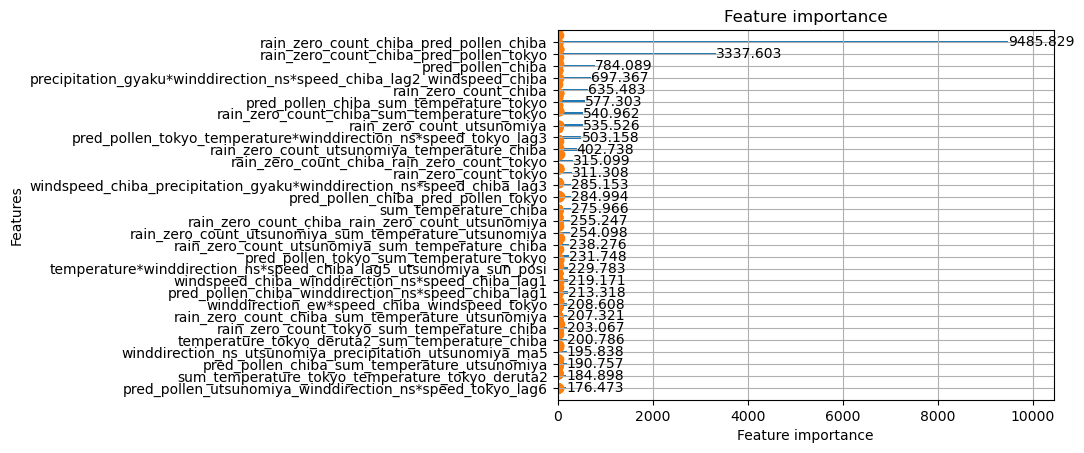

In [2963]:
#lgb_chiba_2 = lgbm_s("chiba",df_train_test_x_c,df_train_test_y_c,df_test_x_c,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_c_2" )
lgb_chiba_2 = lgbm_o("chiba",df_train_test_x_c,df_train_test_y_c,df_test_x_c,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_c_2" )

### ---Ave. CV

MAE
lgbm 9.774745420002638


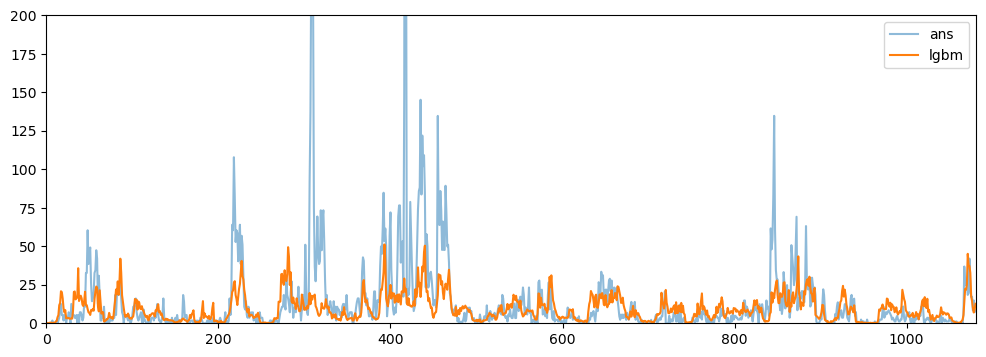

In [2964]:
r = 1

df_pred["pollen_"+region_list[r]+"_lgbm"] = (df_pred["pollen_"+region_list[r]+"_lgbm_c_0"]+df_pred["pollen_"+region_list[r]+"_lgbm_c_1"]+df_pred["pollen_"+region_list[r]+"_lgbm_c_2"])/3

plt.figure(figsize=(12,4))
plt.plot(np.array(df_train_test_y_c["pollen_"+region_list[r]]), alpha=0.5, label="ans")
plt.plot(df_pred["pollen_"+region_list[r]+"_lgbm"], label="lgbm")
plt.legend()
plt.xlim(0,len(df_pred))
plt.ylim(0,200)

print("MAE")
print("lgbm",mean_absolute_error(df_pred["pollen_"+region_list[r]+"_lgbm"], np.array(df_train_test_y_c["pollen_"+region_list[r]])))

In [2965]:
#sub
r = 1

### lgbm
df_submission["pollen_"+region_list[r]] = (df_sub["pollen_"+region_list[r]+"_lgbm_c_0"]+df_sub["pollen_"+region_list[r]+"_lgbm_c_1"]+df_sub["pollen_"+region_list[r]+"_lgbm_c_2"])/3


#4の倍数にそろえる
for i in range(1000):
    df_submission["pollen_chiba"][(df_submission["pollen_chiba"] > i*4-2) & (df_submission["pollen_chiba"] <= i*4+2)] = i*4

## tokyo

In [2967]:
# 閾値3以下を分割(Statified k-fold)
X = df_train_traval_t_under.copy()
y= df_train_traval_t_under["pollen_tokyo_cat"]
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

df_train_idx = pd.DataFrame()
df_valid_idx = pd.DataFrame()

print(skf)
for i, (train_index) in enumerate(skf.split(X, y)):
    df_train_idx[i] = train_index

StratifiedKFold(n_splits=3, random_state=42, shuffle=True)


In [2968]:
df_train_traval_t_0 = df_train_traval_t_under.loc[df_train_idx[0][1].tolist()]
df_train_traval_t_1 = df_train_traval_t_under.loc[df_train_idx[1][1].tolist()]
df_train_traval_t_2 = df_train_traval_t_under.loc[df_train_idx[2][1].tolist()]

df_train_traval_t_0 =pd.concat([df_train_traval_t_0, df_train_traval_t_1, df_train_traval_t_over], axis = 0)
df_train_traval_t_1 =pd.concat([df_train_traval_t_1, df_train_traval_t_2, df_train_traval_t_over], axis = 0)
df_train_traval_t_2 =pd.concat([df_train_traval_t_2, df_train_traval_t_0, df_train_traval_t_over], axis = 0)

### ---0

In [2969]:
#train_travalをtrainとvalidに分割
df_traval_y_t_0 = df_train_traval_t_0[{"pollen_tokyo", "pollen_tokyo_cat"}]
df_traval_x_t_0 = df_train_traval_t_0.drop({"pollen_tokyo" ,"pollen_tokyo_cat", 
                                 "day", "month" 
                                }, axis=1)

df_test_x_t = df_test_lgbm_t.drop({"pollen_tokyo",
                                 "day", "month",
                                }, axis=1)
df_train_test_y_t = df_train_test_t[{"pollen_tokyo", "pollen_tokyo_cat"}]
df_train_test_x_t = df_train_test_t.drop({"pollen_tokyo", "pollen_tokyo_cat",
                                 "day", "month",
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_t_0)
interaction_features = poly.get_feature_names(df_traval_x_t_0.columns)
df_traval_x_t_0 = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_test_x_t)
interaction_features = poly.get_feature_names(df_test_x_t.columns)
df_test_x_t = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_train_test_x_t)
interaction_features = poly.get_feature_names(df_train_test_x_t.columns)
df_train_test_x_t = pd.DataFrame(X_poly, columns=interaction_features)

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_t_0, df_traval_y_t_0, test_size=0.3, random_state=42)

[I 2023-01-08 13:16:49,411] A new study created in memory with name: no-name-63221a64-edcc-4cff-b496-97ac157338da
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[199]	valid_0's huber: 0.0365189	valid_1's huber: 0.465948


feature_fraction, val_score: 0.465948:  14%|######4                                      | 1/7 [00:56<05:35, 55.99s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's huber: 0.00262958	valid_1's huber: 0.470809


feature_fraction, val_score: 0.465948:  29%|############8                                | 2/7 [03:02<08:07, 97.51s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	valid_0's huber: 0.0155478	valid_1's huber: 0.464615


feature_fraction, val_score: 0.464615:  43%|##################8                         | 3/7 [04:52<06:51, 102.98s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[219]	valid_0's huber: 0.0245614	valid_1's huber: 0.467264


feature_fraction, val_score: 0.464615:  57%|#########################7                   | 4/7 [06:15<04:46, 95.34s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	valid_0's huber: 0.0273798	valid_1's huber: 0.463519


feature_fraction, val_score: 0.463519:  71%|################################1            | 5/7 [08:03<03:19, 99.74s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	valid_0's huber: 0.00867162	valid_1's huber: 0.464807


feature_fraction, val_score: 0.463519:  86%|######################################5      | 6/7 [09:20<01:32, 92.17s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[243]	valid_0's huber: 0.0169348	valid_1's huber: 0.470685


num_leaves, val_score: 0.463519:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[423]	valid_0's huber: 0.04862	valid_1's huber: 0.462735


num_leaves, val_score: 0.462735:   5%|##5                                               | 1/20 [01:26<27:30, 86.89s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	valid_0's huber: 0.00489884	valid_1's huber: 0.467984


num_leaves, val_score: 0.462735:  10%|####9                                            | 2/20 [04:00<37:49, 126.09s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	valid_0's huber: 0.000227091	valid_1's huber: 0.469771


num_leaves, val_score: 0.462735:  15%|#######                                        | 3/20 [11:59<1:21:25, 287.40s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	valid_0's huber: 0.000368007	valid_1's huber: 0.470474


num_leaves, val_score: 0.462735:  20%|#########4                                     | 4/20 [16:18<1:13:38, 276.13s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	valid_0's huber: 0.000227091	valid_1's huber: 0.469771


num_leaves, val_score: 0.462735:  25%|###########7                                   | 5/20 [24:12<1:26:48, 347.25s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[226]	valid_0's huber: 0.000336645	valid_1's huber: 0.473051


num_leaves, val_score: 0.462735:  30%|##############1                                | 6/20 [29:12<1:17:18, 331.29s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[199]	valid_0's huber: 0.000504452	valid_1's huber: 0.470163


num_leaves, val_score: 0.462735:  35%|################4                              | 7/20 [34:06<1:09:08, 319.10s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	valid_0's huber: 0.000227091	valid_1's huber: 0.469771


num_leaves, val_score: 0.462735:  40%|##################8                            | 8/20 [42:00<1:13:40, 368.34s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[272]	valid_0's huber: 0.000200489	valid_1's huber: 0.474382


num_leaves, val_score: 0.462735:  45%|#####################1                         | 9/20 [48:21<1:08:16, 372.45s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	valid_0's huber: 0.013998	valid_1's huber: 0.468182


num_leaves, val_score: 0.462735:  50%|########################                        | 10/20 [50:22<49:06, 294.67s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[423]	valid_0's huber: 0.04862	valid_1's huber: 0.462735


num_leaves, val_score: 0.462735:  55%|##########################4                     | 11/20 [51:48<34:38, 230.90s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.418019	valid_1's huber: 0.516399


num_leaves, val_score: 0.462735:  60%|############################8                   | 12/20 [52:17<22:35, 169.45s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.287115	valid_1's huber: 0.491272


num_leaves, val_score: 0.462735:  65%|###############################2                | 13/20 [53:00<15:18, 131.15s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[230]	valid_0's huber: 0.000212962	valid_1's huber: 0.475301


num_leaves, val_score: 0.462735:  70%|################################1             | 14/20 [1:00:00<21:49, 218.32s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	valid_0's huber: 0.0329348	valid_1's huber: 0.471608


num_leaves, val_score: 0.462735:  75%|##################################5           | 15/20 [1:01:55<15:35, 187.18s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	valid_0's huber: 0.000220415	valid_1's huber: 0.476332


num_leaves, val_score: 0.462735:  80%|####################################8         | 16/20 [1:08:55<17:09, 257.36s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.462735:  85%|#######################################1      | 17/20 [1:10:40<10:35, 211.72s/it]

Early stopping, best iteration is:
[206]	valid_0's huber: 0.0273798	valid_1's huber: 0.463519


[I 2023-01-08 14:38:11,393] Trial 23 finished with value: 0.46351880172755966 and parameters: {'num_leaves': 31}. Best is trial 7 with value: 0.4627351431061029.
num_leaves, val_score: 0.462735:  85%|#######################################1      | 17/20 [1:10:41<10:35, 211.72s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.462735:  85%|#######################################1      | 17/20 [1:13:23<10:35, 211.72s/it]

Early stopping, best iteration is:
[206]	valid_0's huber: 0.000680903	valid_1's huber: 0.469433


num_leaves, val_score: 0.462735:  90%|#########################################4    | 18/20 [1:13:23<06:33, 197.00s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.462735:  95%|###########################################6  | 19/20 [1:14:15<02:33, 153.25s/it][I 2023-01-08 14:41:45,448] Trial 25 finished with value: 0.4646930292515027 and parameters: {'num_leaves': 15}. Best is trial 7 with value: 0.4627351431061029.


Early stopping, best iteration is:
[323]	valid_0's huber: 0.0763526	valid_1's huber: 0.464693


num_leaves, val_score: 0.462735:  95%|###########################################6  | 19/20 [1:14:15<02:33, 153.25s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.462735: 100%|##############################################| 20/20 [1:16:58<00:00, 156.44s/it]

Early stopping, best iteration is:
[206]	valid_0's huber: 0.000680903	valid_1's huber: 0.469433


[I 2023-01-08 14:44:29,318] Trial 26 finished with value: 0.4694325143915647 and parameters: {'num_leaves': 75}. Best is trial 7 with value: 0.4627351431061029.
bagging, val_score: 0.462735:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.462735:  10%|#####3                                               | 1/10 [00:36<05:26, 36.27s/it]

Early stopping, best iteration is:
[185]	valid_0's huber: 0.190073	valid_1's huber: 0.491379
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.462735:  20%|##########6                                          | 2/10 [01:36<06:44, 50.60s/it]

Early stopping, best iteration is:
[452]	valid_0's huber: 0.0407274	valid_1's huber: 0.465375
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.462735:  30%|###############9                                     | 3/10 [02:25<05:46, 49.50s/it]

Early stopping, best iteration is:
[319]	valid_0's huber: 0.0898463	valid_1's huber: 0.475954
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.462735:  40%|#####################2                               | 4/10 [03:13<04:54, 49.08s/it]

Early stopping, best iteration is:
[316]	valid_0's huber: 0.089707	valid_1's huber: 0.474147
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.462735:  50%|##########################5                          | 5/10 [03:49<03:41, 44.34s/it]

Early stopping, best iteration is:
[183]	valid_0's huber: 0.201182	valid_1's huber: 0.489866
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.462735:  60%|###############################8                     | 6/10 [04:24<02:44, 41.18s/it]

Early stopping, best iteration is:
[173]	valid_0's huber: 0.206171	valid_1's huber: 0.491765
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.462735:  70%|#####################################                | 7/10 [05:54<02:51, 57.10s/it][I 2023-01-08 14:50:23,762] Trial 33 finished with value: 0.46883945202574107 and parameters: {'bagging_fraction': 0.9655940025632039, 'bagging_freq': 3}. Best is trial 28 with value: 0.4653745987572821.


Early stopping, best iteration is:
[751]	valid_0's huber: 0.00544688	valid_1's huber: 0.468839


bagging, val_score: 0.462735:  70%|#####################################                | 7/10 [05:54<02:51, 57.10s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.462735:  80%|##########################################4          | 8/10 [06:44<01:49, 54.74s/it]

Early stopping, best iteration is:
[328]	valid_0's huber: 0.0837527	valid_1's huber: 0.477461
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.462735:  90%|###############################################7     | 9/10 [07:24<00:50, 50.39s/it]

Early stopping, best iteration is:
[234]	valid_0's huber: 0.147207	valid_1's huber: 0.481473
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.462735: 100%|####################################################| 10/10 [08:13<00:00, 49.39s/it]


Early stopping, best iteration is:
[321]	valid_0's huber: 0.0898207	valid_1's huber: 0.478517


feature_fraction_stage2, val_score: 0.462735:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.462735:  33%|############6                         | 1/3 [00:52<01:44, 52.39s/it]

Early stopping, best iteration is:
[370]	valid_0's huber: 0.0688727	valid_1's huber: 0.466222
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.461109:  67%|#########################3            | 2/3 [02:27<01:17, 77.44s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00108245	valid_1's huber: 0.461109


[I 2023-01-08 14:55:10,692] Trial 38 finished with value: 0.46110878902813957 and parameters: {'feature_fraction': 0.92}. Best is trial 38 with value: 0.46110878902813957.
feature_fraction_stage2, val_score: 0.461109:  67%|#########################3            | 2/3 [02:27<01:17, 77.44s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.461109: 100%|######################################| 3/3 [03:17<00:00, 65.88s/it]


Early stopping, best iteration is:
[359]	valid_0's huber: 0.0727678	valid_1's huber: 0.464061


regularization_factors, val_score: 0.461109:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461109:   5%|#9                                    | 1/20 [00:47<14:53, 47.02s/it]

Early stopping, best iteration is:
[334]	valid_0's huber: 0.0885518	valid_1's huber: 0.467279
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  10%|###8                                  | 2/20 [02:23<22:47, 75.96s/it][I 2023-01-08 14:58:24,204] Trial 41 finished with value: 0.4610163582775935 and parameters: {'lambda_l1': 4.499971207866772e-05, 'lambda_l2': 0.00022268453045637182}. Best is trial 41 with value: 0.4610163582775935.


Early stopping, best iteration is:
[897]	valid_0's huber: 0.00226378	valid_1's huber: 0.461016


regularization_factors, val_score: 0.461016:  10%|###8                                  | 2/20 [02:23<22:47, 75.96s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  15%|#####7                                | 3/20 [03:59<24:10, 85.34s/it][I 2023-01-08 15:00:00,699] Trial 42 finished with value: 0.46101636399402524 and parameters: {'lambda_l1': 0.00012833649154736124, 'lambda_l2': 7.832513183869821e-05}. Best is trial 41 with value: 0.4610163582775935.


Early stopping, best iteration is:
[897]	valid_0's huber: 0.00226391	valid_1's huber: 0.461016


regularization_factors, val_score: 0.461016:  15%|#####7                                | 3/20 [03:59<24:10, 85.34s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  20%|#######6                              | 4/20 [05:35<23:51, 89.45s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00108246	valid_1's huber: 0.461109


[I 2023-01-08 15:01:36,445] Trial 43 finished with value: 0.4611087947086095 and parameters: {'lambda_l1': 1.6006777779101534e-08, 'lambda_l2': 6.19552766070483e-05}. Best is trial 41 with value: 0.4610163582775935.
regularization_factors, val_score: 0.461016:  20%|#######6                              | 4/20 [05:35<23:51, 89.45s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  25%|#########5                            | 5/20 [06:32<19:25, 77.68s/it]

Early stopping, best iteration is:
[483]	valid_0's huber: 0.039123	valid_1's huber: 0.466013
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  30%|###########4                          | 6/20 [07:21<15:51, 67.97s/it][I 2023-01-08 15:03:22,401] Trial 45 finished with value: 0.46482167422453236 and parameters: {'lambda_l1': 0.0007475558344635393, 'lambda_l2': 3.843997791348066e-06}. Best is trial 41 with value: 0.4610163582775935.


Early stopping, best iteration is:
[340]	valid_0's huber: 0.0823236	valid_1's huber: 0.464822


regularization_factors, val_score: 0.461016:  30%|###########4                          | 6/20 [07:21<15:51, 67.97s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  35%|#############3                        | 7/20 [08:38<15:23, 71.07s/it][I 2023-01-08 15:04:39,868] Trial 46 finished with value: 0.4628546401691249 and parameters: {'lambda_l1': 6.494485864388704e-05, 'lambda_l2': 0.3632868711015871}. Best is trial 41 with value: 0.4610163582775935.


Early stopping, best iteration is:
[550]	valid_0's huber: 0.0236818	valid_1's huber: 0.462855


regularization_factors, val_score: 0.461016:  35%|#############3                        | 7/20 [08:38<15:23, 71.07s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  40%|###############2                      | 8/20 [10:18<16:00, 80.04s/it][I 2023-01-08 15:06:19,066] Trial 47 finished with value: 0.46101634826145416 and parameters: {'lambda_l1': 8.999265262043136e-05, 'lambda_l2': 7.453356322455042e-08}. Best is trial 47 with value: 0.46101634826145416.


Early stopping, best iteration is:
[897]	valid_0's huber: 0.00226381	valid_1's huber: 0.461016


regularization_factors, val_score: 0.461016:  40%|###############2                      | 8/20 [10:18<16:00, 80.04s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  45%|#################1                    | 9/20 [11:14<13:17, 72.53s/it]

Early stopping, best iteration is:
[419]	valid_0's huber: 0.0567452	valid_1's huber: 0.467534
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  50%|##################5                  | 10/20 [12:17<11:37, 69.79s/it]

Early stopping, best iteration is:
[525]	valid_0's huber: 0.026	valid_1's huber: 0.466297
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  55%|####################3                | 11/20 [13:55<11:43, 78.20s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00108245	valid_1's huber: 0.461109


[I 2023-01-08 15:09:56,051] Trial 50 finished with value: 0.4611087892622756 and parameters: {'lambda_l1': 1.3027659180860885e-06, 'lambda_l2': 1.6824003208926334e-08}. Best is trial 47 with value: 0.46101634826145416.
regularization_factors, val_score: 0.461016:  55%|####################3                | 11/20 [13:55<11:43, 78.20s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  60%|######################2              | 12/20 [15:32<11:11, 83.93s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00108246	valid_1's huber: 0.461109


[I 2023-01-08 15:11:33,063] Trial 51 finished with value: 0.4611087897550787 and parameters: {'lambda_l1': 3.858323040113433e-06, 'lambda_l2': 1.3318245116894459e-08}. Best is trial 47 with value: 0.46101634826145416.
regularization_factors, val_score: 0.461016:  60%|######################2              | 12/20 [15:32<11:11, 83.93s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  65%|########################             | 13/20 [17:00<09:56, 85.18s/it]

Early stopping, best iteration is:
[788]	valid_0's huber: 0.0044384	valid_1's huber: 0.462478


[I 2023-01-08 15:13:01,114] Trial 52 finished with value: 0.46247753819829535 and parameters: {'lambda_l1': 0.0034881719889773718, 'lambda_l2': 0.003497385977676883}. Best is trial 47 with value: 0.46101634826145416.
regularization_factors, val_score: 0.461016:  65%|########################             | 13/20 [17:00<09:56, 85.18s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  70%|#########################9           | 14/20 [18:36<08:51, 88.52s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00108247	valid_1's huber: 0.461109


[I 2023-01-08 15:14:37,372] Trial 53 finished with value: 0.46110879091498663 and parameters: {'lambda_l1': 9.280170422163021e-06, 'lambda_l2': 1.2175446253233254e-06}. Best is trial 47 with value: 0.46101634826145416.
regularization_factors, val_score: 0.461016:  70%|#########################9           | 14/20 [18:36<08:51, 88.52s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  75%|###########################7         | 15/20 [19:23<06:19, 75.90s/it][I 2023-01-08 15:15:24,021] Trial 54 finished with value: 0.4703274938484189 and parameters: {'lambda_l1': 0.00783370636318543, 'lambda_l2': 0.001469953667305245}. Best is trial 47 with value: 0.46101634826145416.


Early stopping, best iteration is:
[322]	valid_0's huber: 0.0926012	valid_1's huber: 0.470327


regularization_factors, val_score: 0.461016:  75%|###########################7         | 15/20 [19:23<06:19, 75.90s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  80%|#############################6       | 16/20 [20:37<05:02, 75.50s/it][I 2023-01-08 15:16:38,574] Trial 55 finished with value: 0.46528805448389216 and parameters: {'lambda_l1': 0.08573127079274016, 'lambda_l2': 8.220401733245223e-08}. Best is trial 47 with value: 0.46101634826145416.


Early stopping, best iteration is:
[637]	valid_0's huber: 0.0131344	valid_1's huber: 0.465288


regularization_factors, val_score: 0.461016:  80%|#############################6       | 16/20 [20:37<05:02, 75.50s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  85%|###############################4     | 17/20 [22:13<04:04, 81.59s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00108248	valid_1's huber: 0.461109


[I 2023-01-08 15:18:14,339] Trial 56 finished with value: 0.4611087939185475 and parameters: {'lambda_l1': 1.9393141874332983e-05, 'lambda_l2': 1.2688651476078065e-05}. Best is trial 47 with value: 0.46101634826145416.
regularization_factors, val_score: 0.461016:  85%|###############################4     | 17/20 [22:13<04:04, 81.59s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  90%|#################################3   | 18/20 [23:01<02:22, 71.39s/it]

Early stopping, best iteration is:
[340]	valid_0's huber: 0.0823222	valid_1's huber: 0.464822
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016:  95%|###################################1 | 19/20 [23:49<01:04, 64.38s/it][I 2023-01-08 15:19:50,053] Trial 58 finished with value: 0.4648667565033266 and parameters: {'lambda_l1': 7.345164376729439e-07, 'lambda_l2': 0.0029618979874846065}. Best is trial 47 with value: 0.46101634826145416.


Early stopping, best iteration is:
[337]	valid_0's huber: 0.0834343	valid_1's huber: 0.464867


regularization_factors, val_score: 0.461016:  95%|###################################1 | 19/20 [23:49<01:04, 64.38s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.461016: 100%|#####################################| 20/20 [25:25<00:00, 73.87s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00108249	valid_1's huber: 0.461109


[I 2023-01-08 15:21:26,040] Trial 59 finished with value: 0.46110880917351554 and parameters: {'lambda_l1': 1.269573856617095e-07, 'lambda_l2': 0.00021956892288714857}. Best is trial 47 with value: 0.46101634826145416.
min_data_in_leaf, val_score: 0.461016:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.460200:  20%|#########                                    | 1/5 [01:02<04:11, 62.88s/it][I 2023-01-08 15:22:29,010] Trial 60 finished with value: 0.4601995971890712 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.4601995971890712.


Early stopping, best iteration is:
[481]	valid_0's huber: 0.0347606	valid_1's huber: 0.4602


min_data_in_leaf, val_score: 0.460200:  20%|#########                                    | 1/5 [01:02<04:11, 62.88s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.460200:  40%|##################                           | 2/5 [01:59<02:58, 59.35s/it]

Early stopping, best iteration is:
[424]	valid_0's huber: 0.0496848	valid_1's huber: 0.463374
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.460200:  60%|###########################                  | 3/5 [02:56<01:56, 58.25s/it]

Early stopping, best iteration is:
[496]	valid_0's huber: 0.0414255	valid_1's huber: 0.470684
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.460200:  80%|####################################         | 4/5 [04:08<01:03, 63.45s/it]

Early stopping, best iteration is:
[622]	valid_0's huber: 0.0147898	valid_1's huber: 0.460463


[I 2023-01-08 15:25:34,253] Trial 63 finished with value: 0.4604627667755706 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 0.4601995971890712.
min_data_in_leaf, val_score: 0.460200:  80%|####################################         | 4/5 [04:08<01:03, 63.45s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.460200: 100%|#############################################| 5/5 [04:59<00:00, 59.15s/it][I 2023-01-08 15:26:25,772] Trial 64 finished with value: 0.46821665583948313 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.4601995971890712.


Early stopping, best iteration is:
[414]	valid_0's huber: 0.0581408	valid_1's huber: 0.468217


min_data_in_leaf, val_score: 0.460200: 100%|#############################################| 5/5 [04:59<00:00, 59.94s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 8.999265262043136e-05, 'lambda_l2': 7.453356322455042e-08, 'num_leaves': 14, 'feature_fraction': 0.92, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 9.014757023515175


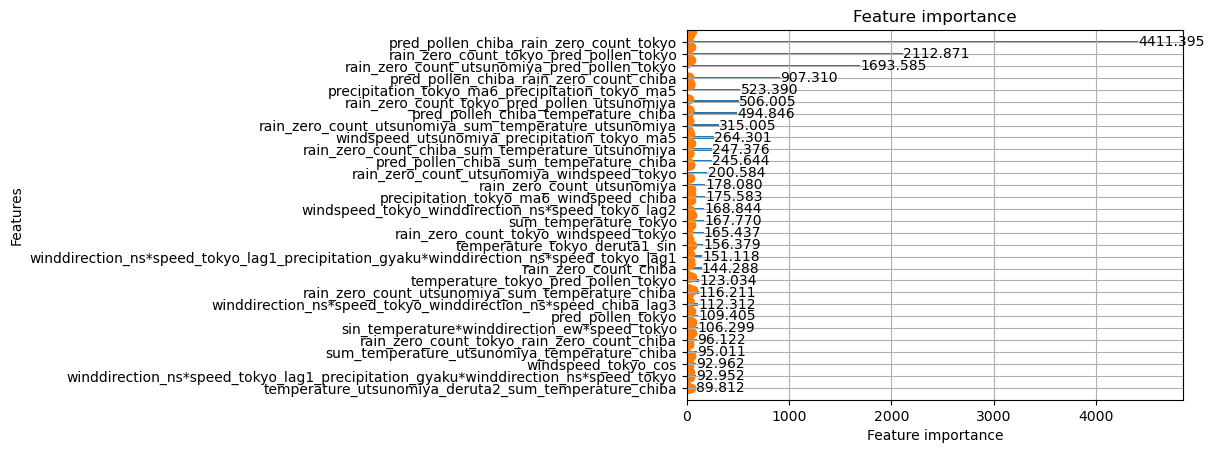

In [2970]:
#lgb_tokyo_0 = lgbm_s("tokyo",df_train_test_x_t,df_train_test_y_t,df_test_x_t,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_t_0" )
lgb_tokyo_0 = lgbm_o("tokyo",df_train_test_x_t,df_train_test_y_t,df_test_x_t,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_t_0" )

### ---1

In [2971]:
#train_travalをtrainとvalidに分割
df_traval_y_t_1 = df_train_traval_t_1[{"pollen_tokyo", "pollen_tokyo_cat"}]
df_traval_x_t_1 = df_train_traval_t_1.drop({"pollen_tokyo" ,"pollen_tokyo_cat", 
                                 "day", "month" 
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_t_1)
interaction_features = poly.get_feature_names(df_traval_x_t_1.columns)
df_traval_x_t_1 = pd.DataFrame(X_poly, columns=interaction_features)

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_t_1, df_traval_y_t_1, test_size=0.3, random_state=42)

[I 2023-01-08 15:26:27,539] A new study created in memory with name: no-name-4f27f6fa-2240-41e2-a31b-b16dda202d2a
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.463707:  14%|######4                                      | 1/7 [00:58<05:49, 58.21s/it]

Early stopping, best iteration is:
[217]	valid_0's huber: 0.0256432	valid_1's huber: 0.463707


[I 2023-01-08 15:27:25,827] Trial 0 finished with value: 0.46370719442194197 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.46370719442194197.
feature_fraction, val_score: 0.463707:  14%|######4                                      | 1/7 [00:58<05:49, 58.21s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.458914:  29%|############8                                | 2/7 [02:31<06:32, 78.60s/it]

Early stopping, best iteration is:
[295]	valid_0's huber: 0.0064245	valid_1's huber: 0.458914


[I 2023-01-08 15:28:58,697] Trial 1 finished with value: 0.4589138047425789 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.4589138047425789.
feature_fraction, val_score: 0.458914:  29%|############8                                | 2/7 [02:31<06:32, 78.60s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.458914:  43%|###################2                         | 3/7 [03:09<04:01, 60.46s/it][I 2023-01-08 15:29:37,558] Trial 2 finished with value: 0.4592627033358557 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.4589138047425789.


Early stopping, best iteration is:
[159]	valid_0's huber: 0.0632643	valid_1's huber: 0.459263


feature_fraction, val_score: 0.458914:  43%|###################2                         | 3/7 [03:10<04:01, 60.46s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.458914:  57%|#########################7                   | 4/7 [04:04<02:54, 58.10s/it][I 2023-01-08 15:30:32,028] Trial 3 finished with value: 0.4628171281080568 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.4589138047425789.


Early stopping, best iteration is:
[156]	valid_0's huber: 0.0605795	valid_1's huber: 0.462817


feature_fraction, val_score: 0.458914:  57%|#########################7                   | 4/7 [04:04<02:54, 58.10s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.458914:  71%|################################1            | 5/7 [04:50<01:47, 53.61s/it]

Early stopping, best iteration is:
[315]	valid_0's huber: 0.00674525	valid_1's huber: 0.465686


[I 2023-01-08 15:31:17,688] Trial 4 finished with value: 0.4656859763263792 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.4589138047425789.
feature_fraction, val_score: 0.458914:  71%|################################1            | 5/7 [04:50<01:47, 53.61s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.458914:  86%|######################################5      | 6/7 [05:50<00:55, 55.99s/it]

Early stopping, best iteration is:
[290]	valid_0's huber: 0.00850529	valid_1's huber: 0.465632


[I 2023-01-08 15:32:18,331] Trial 5 finished with value: 0.4656321647638524 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.4589138047425789.
feature_fraction, val_score: 0.458914:  86%|######################################5      | 6/7 [05:50<00:55, 55.99s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.458914: 100%|#############################################| 7/7 [06:58<00:00, 59.94s/it]

Early stopping, best iteration is:
[203]	valid_0's huber: 0.0301399	valid_1's huber: 0.467745


[I 2023-01-08 15:33:26,382] Trial 6 finished with value: 0.4677447727983977 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.4589138047425789.
num_leaves, val_score: 0.458914:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	valid_0's huber: 0.00149156	valid_1's huber: 0.464538


num_leaves, val_score: 0.458914:   5%|##3                                            | 1/20 [03:19<1:03:15, 199.76s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's huber: 0.00294703	valid_1's huber: 0.46494


num_leaves, val_score: 0.458914:  10%|####7                                          | 2/20 [07:57<1:13:41, 245.65s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	valid_0's huber: 0.000205684	valid_1's huber: 0.473506


num_leaves, val_score: 0.458914:  15%|#######                                        | 3/20 [18:36<2:00:25, 425.01s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.458914:  15%|#######                                        | 3/20 [20:56<2:00:25, 425.01s/it]

Early stopping, best iteration is:
[81]	valid_0's huber: 0.0361832	valid_1's huber: 0.465598


num_leaves, val_score: 0.458914:  20%|#########4                                     | 4/20 [20:56<1:23:22, 312.63s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.458914:  20%|#########4                                     | 4/20 [22:39<1:23:22, 312.63s/it]

Early stopping, best iteration is:
[102]	valid_0's huber: 0.0200262	valid_1's huber: 0.461059


num_leaves, val_score: 0.458914:  25%|############2                                    | 5/20 [22:39<59:16, 237.13s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	valid_0's huber: 0.000205684	valid_1's huber: 0.473506


num_leaves, val_score: 0.458914:  30%|##############1                                | 6/20 [29:31<1:09:11, 296.52s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	valid_0's huber: 0.00785661	valid_1's huber: 0.467046


num_leaves, val_score: 0.458914:  35%|#################1                               | 7/20 [32:29<55:53, 257.94s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	valid_0's huber: 0.000205684	valid_1's huber: 0.473506


num_leaves, val_score: 0.458914:  40%|##################8                            | 8/20 [39:14<1:00:54, 304.56s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.458914:  45%|######################                           | 9/20 [40:48<43:46, 238.75s/it]

Early stopping, best iteration is:
[134]	valid_0's huber: 0.0198707	valid_1's huber: 0.46244


[I 2023-01-08 16:14:14,771] Trial 15 finished with value: 0.462439718703761 and parameters: {'num_leaves': 50}. Best is trial 11 with value: 0.46105862062279257.
num_leaves, val_score: 0.458914:  45%|######################                           | 9/20 [40:48<43:46, 238.75s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	valid_0's huber: 0.000205684	valid_1's huber: 0.473506


num_leaves, val_score: 0.458914:  50%|########################                        | 10/20 [47:36<48:28, 290.88s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.458914:  55%|##########################4                     | 11/20 [48:18<32:14, 214.94s/it]

Early stopping, best iteration is:
[791]	valid_0's huber: 0.123831	valid_1's huber: 0.480546
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.458914:  60%|############################8                   | 12/20 [49:48<23:35, 176.89s/it]

Early stopping, best iteration is:
[134]	valid_0's huber: 0.0198707	valid_1's huber: 0.46244


[I 2023-01-08 16:23:14,996] Trial 18 finished with value: 0.462439718703761 and parameters: {'num_leaves': 50}. Best is trial 11 with value: 0.46105862062279257.
num_leaves, val_score: 0.458914:  60%|############################8                   | 12/20 [49:48<23:35, 176.89s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.456394:  65%|###############################2                | 13/20 [51:19<17:36, 150.97s/it]

Early stopping, best iteration is:
[278]	valid_0's huber: 0.00743339	valid_1's huber: 0.456394


[I 2023-01-08 16:24:46,326] Trial 19 finished with value: 0.45639350386659194 and parameters: {'num_leaves': 32}. Best is trial 19 with value: 0.45639350386659194.
num_leaves, val_score: 0.456394:  65%|###############################2                | 13/20 [51:19<17:36, 150.97s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.456394:  70%|#################################5              | 14/20 [51:36<11:02, 110.40s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.421851	valid_1's huber: 0.518588
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	valid_0's huber: 0.00113675	valid_1's huber: 0.464118


num_leaves, val_score: 0.456394:  75%|####################################            | 15/20 [54:30<10:47, 129.51s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.456394:  80%|######################################4         | 16/20 [55:39<07:25, 111.26s/it][I 2023-01-08 16:29:05,637] Trial 22 finished with value: 0.4587251762132892 and parameters: {'num_leaves': 38}. Best is trial 19 with value: 0.45639350386659194.


Early stopping, best iteration is:
[127]	valid_0's huber: 0.0579341	valid_1's huber: 0.458725


num_leaves, val_score: 0.456394:  80%|######################################4         | 16/20 [55:39<07:25, 111.26s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.456394:  85%|#########################################6       | 17/20 [56:44<04:52, 97.53s/it]

Early stopping, best iteration is:
[173]	valid_0's huber: 0.0504992	valid_1's huber: 0.46406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	valid_0's huber: 0.000886747	valid_1's huber: 0.464283


num_leaves, val_score: 0.456394:  90%|#########################################4    | 18/20 [1:00:04<04:16, 128.09s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.456394:  95%|###########################################6  | 19/20 [1:01:09<01:49, 109.23s/it]

Early stopping, best iteration is:
[173]	valid_0's huber: 0.0504992	valid_1's huber: 0.46406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's huber: 0.0057733	valid_1's huber: 0.47087


bagging, val_score: 0.456394:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.456394:  10%|#####3                                               | 1/10 [01:11<10:39, 71.06s/it]

Early stopping, best iteration is:
[183]	valid_0's huber: 0.0436987	valid_1's huber: 0.482148


[I 2023-01-08 16:38:59,602] Trial 27 finished with value: 0.48214750784832217 and parameters: {'bagging_fraction': 0.5871408967085161, 'bagging_freq': 5}. Best is trial 27 with value: 0.48214750784832217.
bagging, val_score: 0.456394:  10%|#####3                                               | 1/10 [01:11<10:39, 71.06s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.456394:  20%|##########4                                         | 2/10 [03:37<15:22, 115.30s/it]

Early stopping, best iteration is:
[525]	valid_0's huber: 0.000186283	valid_1's huber: 0.467964


[I 2023-01-08 16:41:25,874] Trial 28 finished with value: 0.4679636380110866 and parameters: {'bagging_fraction': 0.7830166814963303, 'bagging_freq': 6}. Best is trial 28 with value: 0.4679636380110866.
bagging, val_score: 0.456394:  20%|##########4                                         | 2/10 [03:37<15:22, 115.30s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.456394:  30%|###############9                                     | 3/10 [04:38<10:34, 90.63s/it][I 2023-01-08 16:42:27,129] Trial 29 finished with value: 0.4721263240474346 and parameters: {'bagging_fraction': 0.7558569356543969, 'bagging_freq': 1}. Best is trial 28 with value: 0.4679636380110866.


Early stopping, best iteration is:
[134]	valid_0's huber: 0.0781928	valid_1's huber: 0.472126


bagging, val_score: 0.456394:  30%|###############9                                     | 3/10 [04:38<10:34, 90.63s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.456394:  40%|#####################2                               | 4/10 [05:36<07:45, 77.61s/it][I 2023-01-08 16:43:24,775] Trial 30 finished with value: 0.489361163459647 and parameters: {'bagging_fraction': 0.5625954104121297, 'bagging_freq': 2}. Best is trial 28 with value: 0.4679636380110866.


Early stopping, best iteration is:
[121]	valid_0's huber: 0.107548	valid_1's huber: 0.489361


bagging, val_score: 0.456394:  40%|#####################2                               | 4/10 [05:36<07:45, 77.61s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's huber: 0.220333	valid_1's huber: 0.491711


bagging, val_score: 0.456394:  50%|##########################5                          | 5/10 [06:31<05:47, 69.48s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	valid_0's huber: 0.0442536	valid_1's huber: 0.459415


bagging, val_score: 0.456394:  60%|###############################8                     | 6/10 [08:13<05:21, 80.44s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's huber: 0.177879	valid_1's huber: 0.486736


bagging, val_score: 0.456394:  70%|#####################################                | 7/10 [09:23<03:51, 77.13s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	valid_0's huber: 0.0674995	valid_1's huber: 0.467047


bagging, val_score: 0.456394:  80%|##########################################4          | 8/10 [11:00<02:46, 83.36s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	valid_0's huber: 0.047629	valid_1's huber: 0.471737


bagging, val_score: 0.456394:  90%|###############################################7     | 9/10 [13:02<01:35, 95.56s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.456394: 100%|####################################################| 10/10 [14:25<00:00, 91.62s/it]

Early stopping, best iteration is:
[97]	valid_0's huber: 0.158048	valid_1's huber: 0.5003


[I 2023-01-08 16:52:13,773] Trial 36 finished with value: 0.5003000137858635 and parameters: {'bagging_fraction': 0.5091988237389744, 'bagging_freq': 3}. Best is trial 32 with value: 0.45941502379199506.
feature_fraction_stage2, val_score: 0.456394:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.456394:  33%|############6                         | 1/3 [01:27<02:54, 87.39s/it]

Early stopping, best iteration is:
[208]	valid_0's huber: 0.0247691	valid_1's huber: 0.45785


[I 2023-01-08 16:53:41,254] Trial 37 finished with value: 0.4578498403877102 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.4578498403877102.
feature_fraction_stage2, val_score: 0.456394:  33%|############6                         | 1/3 [01:27<02:54, 87.39s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.456394:  67%|#########################3            | 2/3 [02:45<01:21, 81.81s/it][I 2023-01-08 16:54:59,133] Trial 38 finished with value: 0.4608493891911699 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.4578498403877102.


Early stopping, best iteration is:
[226]	valid_0's huber: 0.0182482	valid_1's huber: 0.460849


feature_fraction_stage2, val_score: 0.456394:  67%|#########################3            | 2/3 [02:45<01:21, 81.81s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.456394: 100%|######################################| 3/3 [03:51<00:00, 74.69s/it][I 2023-01-08 16:56:05,351] Trial 39 finished with value: 0.46530753219847415 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.4578498403877102.


Early stopping, best iteration is:
[162]	valid_0's huber: 0.0510516	valid_1's huber: 0.465308


regularization_factors, val_score: 0.456394:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.456394:   5%|#9                                    | 1/20 [01:32<29:18, 92.53s/it][I 2023-01-08 16:57:37,953] Trial 40 finished with value: 0.4563935056495152 and parameters: {'lambda_l1': 3.4964034926479544e-06, 'lambda_l2': 1.0361071728478896e-05}. Best is trial 40 with value: 0.4563935056495152.


Early stopping, best iteration is:
[278]	valid_0's huber: 0.00743341	valid_1's huber: 0.456394


regularization_factors, val_score: 0.456394:   5%|#9                                    | 1/20 [01:32<29:18, 92.53s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  10%|###8                                  | 2/20 [02:41<23:31, 78.42s/it][I 2023-01-08 16:58:46,511] Trial 41 finished with value: 0.4551237466636893 and parameters: {'lambda_l1': 6.449402699957083e-07, 'lambda_l2': 5.969256909135626}. Best is trial 41 with value: 0.4551237466636893.


Early stopping, best iteration is:
[160]	valid_0's huber: 0.0599665	valid_1's huber: 0.455124


regularization_factors, val_score: 0.455124:  10%|###8                                  | 2/20 [02:41<23:31, 78.42s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  15%|#####7                                | 3/20 [03:35<19:06, 67.46s/it][I 2023-01-08 16:59:40,929] Trial 42 finished with value: 0.4631417345537801 and parameters: {'lambda_l1': 2.9140171022912082, 'lambda_l2': 0.030330988296257064}. Best is trial 41 with value: 0.4551237466636893.


Early stopping, best iteration is:
[145]	valid_0's huber: 0.0806619	valid_1's huber: 0.463142


regularization_factors, val_score: 0.455124:  15%|#####7                                | 3/20 [03:35<19:06, 67.46s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  20%|#######6                              | 4/20 [05:08<20:39, 77.48s/it]

Early stopping, best iteration is:
[278]	valid_0's huber: 0.0074337	valid_1's huber: 0.456394


[I 2023-01-08 17:01:13,775] Trial 43 finished with value: 0.4563935391248976 and parameters: {'lambda_l1': 1.7952054859660106e-05, 'lambda_l2': 0.00034808938644278136}. Best is trial 41 with value: 0.4551237466636893.
regularization_factors, val_score: 0.455124:  20%|#######6                              | 4/20 [05:08<20:39, 77.48s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  25%|#########5                            | 5/20 [06:36<20:18, 81.23s/it][I 2023-01-08 17:02:41,637] Trial 44 finished with value: 0.4633011066008718 and parameters: {'lambda_l1': 3.95569835468622e-06, 'lambda_l2': 8.631999329098148}. Best is trial 41 with value: 0.4551237466636893.


Early stopping, best iteration is:
[252]	valid_0's huber: 0.0163118	valid_1's huber: 0.463301


regularization_factors, val_score: 0.455124:  25%|#########5                            | 5/20 [06:36<20:18, 81.23s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  30%|###########4                          | 6/20 [07:35<17:14, 73.93s/it][I 2023-01-08 17:03:41,382] Trial 45 finished with value: 0.4692819766511137 and parameters: {'lambda_l1': 4.456264423682993, 'lambda_l2': 6.673019891692536e-08}. Best is trial 41 with value: 0.4551237466636893.


Early stopping, best iteration is:
[217]	valid_0's huber: 0.0394752	valid_1's huber: 0.469282


regularization_factors, val_score: 0.455124:  30%|###########4                          | 6/20 [07:36<17:14, 73.93s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  35%|#############3                        | 7/20 [08:43<15:33, 71.77s/it][I 2023-01-08 17:04:48,721] Trial 46 finished with value: 0.4661910460148339 and parameters: {'lambda_l1': 2.5856106219444404, 'lambda_l2': 0.0003504855063220526}. Best is trial 41 with value: 0.4551237466636893.


Early stopping, best iteration is:
[234]	valid_0's huber: 0.0238428	valid_1's huber: 0.466191


regularization_factors, val_score: 0.455124:  35%|#############3                        | 7/20 [08:43<15:33, 71.77s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  40%|###############2                      | 8/20 [09:50<14:02, 70.24s/it]

Early stopping, best iteration is:
[157]	valid_0's huber: 0.0547087	valid_1's huber: 0.460496


[I 2023-01-08 17:05:55,700] Trial 47 finished with value: 0.46049630941910996 and parameters: {'lambda_l1': 6.097790276461666e-07, 'lambda_l2': 0.5599159905787983}. Best is trial 41 with value: 0.4551237466636893.
regularization_factors, val_score: 0.455124:  40%|###############2                      | 8/20 [09:50<14:02, 70.24s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  45%|#################1                    | 9/20 [10:50<12:17, 67.02s/it][I 2023-01-08 17:06:55,640] Trial 48 finished with value: 0.46727308982268667 and parameters: {'lambda_l1': 0.008371334916876142, 'lambda_l2': 0.1136709572585378}. Best is trial 41 with value: 0.4551237466636893.


Early stopping, best iteration is:
[126]	valid_0's huber: 0.0861684	valid_1's huber: 0.467273


regularization_factors, val_score: 0.455124:  45%|#################1                    | 9/20 [10:50<12:17, 67.02s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  50%|##################5                  | 10/20 [12:23<12:31, 75.16s/it]

Early stopping, best iteration is:
[278]	valid_0's huber: 0.00743416	valid_1's huber: 0.456394


[I 2023-01-08 17:08:29,027] Trial 49 finished with value: 0.4563935606286799 and parameters: {'lambda_l1': 0.00020883876325184723, 'lambda_l2': 5.104968489468616e-05}. Best is trial 41 with value: 0.4551237466636893.
regularization_factors, val_score: 0.455124:  50%|##################5                  | 10/20 [12:23<12:31, 75.16s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  55%|####################3                | 11/20 [13:56<12:06, 80.74s/it]

Early stopping, best iteration is:
[278]	valid_0's huber: 0.00743339	valid_1's huber: 0.456394


[I 2023-01-08 17:10:02,395] Trial 50 finished with value: 0.45639350388554306 and parameters: {'lambda_l1': 2.412908156038451e-08, 'lambda_l2': 3.889239272094704e-08}. Best is trial 41 with value: 0.4551237466636893.
regularization_factors, val_score: 0.455124:  55%|####################3                | 11/20 [13:57<12:06, 80.74s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  60%|######################2              | 12/20 [15:32<11:21, 85.15s/it]

Early stopping, best iteration is:
[278]	valid_0's huber: 0.00743339	valid_1's huber: 0.456394


[I 2023-01-08 17:11:37,631] Trial 51 finished with value: 0.4563935038824653 and parameters: {'lambda_l1': 1.8597831585348472e-08, 'lambda_l2': 1.9321145487121926e-08}. Best is trial 41 with value: 0.4551237466636893.
regularization_factors, val_score: 0.455124:  60%|######################2              | 12/20 [15:32<11:21, 85.15s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  65%|########################             | 13/20 [17:04<10:10, 87.28s/it][I 2023-01-08 17:13:09,821] Trial 52 finished with value: 0.45639350391200845 and parameters: {'lambda_l1': 1.0349031567413768e-08, 'lambda_l2': 4.4690162413400646e-07}. Best is trial 41 with value: 0.4551237466636893.


Early stopping, best iteration is:
[278]	valid_0's huber: 0.00743339	valid_1's huber: 0.456394


regularization_factors, val_score: 0.455124:  65%|########################             | 13/20 [17:04<10:10, 87.28s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  70%|#########################9           | 14/20 [18:08<08:01, 80.21s/it][I 2023-01-08 17:14:13,674] Trial 53 finished with value: 0.45986446103213885 and parameters: {'lambda_l1': 1.5619403349908554e-07, 'lambda_l2': 0.00438072575094974}. Best is trial 41 with value: 0.4551237466636893.


Early stopping, best iteration is:
[145]	valid_0's huber: 0.0653674	valid_1's huber: 0.459864


regularization_factors, val_score: 0.455124:  70%|#########################9           | 14/20 [18:08<08:01, 80.21s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  75%|###########################7         | 15/20 [19:10<06:13, 74.75s/it]

Early stopping, best iteration is:
[136]	valid_0's huber: 0.0742479	valid_1's huber: 0.464525


[I 2023-01-08 17:15:15,789] Trial 54 finished with value: 0.464525433180333 and parameters: {'lambda_l1': 0.006615404925379321, 'lambda_l2': 2.8195218457980035e-06}. Best is trial 41 with value: 0.4551237466636893.
regularization_factors, val_score: 0.455124:  75%|###########################7         | 15/20 [19:10<06:13, 74.75s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  80%|#############################6       | 16/20 [20:23<04:56, 74.19s/it][I 2023-01-08 17:16:28,672] Trial 55 finished with value: 0.457339856449668 and parameters: {'lambda_l1': 1.7676102415809622e-07, 'lambda_l2': 7.873075064517256}. Best is trial 41 with value: 0.4551237466636893.


Early stopping, best iteration is:
[185]	valid_0's huber: 0.0438465	valid_1's huber: 0.45734


regularization_factors, val_score: 0.455124:  80%|#############################6       | 16/20 [20:23<04:56, 74.19s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  85%|###############################4     | 17/20 [21:31<03:37, 72.52s/it]

Early stopping, best iteration is:
[167]	valid_0's huber: 0.0464033	valid_1's huber: 0.457158
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  90%|#################################3   | 18/20 [22:36<02:20, 70.14s/it]

Early stopping, best iteration is:
[145]	valid_0's huber: 0.0653667	valid_1's huber: 0.459864


[I 2023-01-08 17:18:41,891] Trial 57 finished with value: 0.45986441179725374 and parameters: {'lambda_l1': 5.0865428299710495e-08, 'lambda_l2': 0.004089683798769736}. Best is trial 41 with value: 0.4551237466636893.
regularization_factors, val_score: 0.455124:  90%|#################################3   | 18/20 [22:36<02:20, 70.14s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124:  95%|###################################1 | 19/20 [24:09<01:16, 76.86s/it]

Early stopping, best iteration is:
[278]	valid_0's huber: 0.00743339	valid_1's huber: 0.456394


[I 2023-01-08 17:20:14,446] Trial 58 finished with value: 0.4563935041687794 and parameters: {'lambda_l1': 1.0461720656476166e-06, 'lambda_l2': 5.673198288902338e-07}. Best is trial 41 with value: 0.4551237466636893.
regularization_factors, val_score: 0.455124:  95%|###################################1 | 19/20 [24:09<01:16, 76.86s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.455124: 100%|#####################################| 20/20 [25:37<00:00, 80.36s/it][I 2023-01-08 17:21:42,952] Trial 59 finished with value: 0.4613884833093913 and parameters: {'lambda_l1': 3.5607666583004614e-05, 'lambda_l2': 0.7506066313431682}. Best is trial 41 with value: 0.4551237466636893.


Early stopping, best iteration is:
[255]	valid_0's huber: 0.0117031	valid_1's huber: 0.461388


min_data_in_leaf, val_score: 0.455124:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.455124:  20%|#########                                    | 1/5 [01:15<05:02, 75.71s/it]

Early stopping, best iteration is:
[188]	valid_0's huber: 0.039669	valid_1's huber: 0.456991


[I 2023-01-08 17:22:58,748] Trial 60 finished with value: 0.45699113204709546 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.45699113204709546.
min_data_in_leaf, val_score: 0.455124:  20%|#########                                    | 1/5 [01:15<05:02, 75.71s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	valid_0's huber: 0.0388684	valid_1's huber: 0.470395


min_data_in_leaf, val_score: 0.455124:  40%|##################                           | 2/5 [02:53<04:26, 88.74s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[630]	valid_0's huber: 4.3487e-05	valid_1's huber: 0.457294


min_data_in_leaf, val_score: 0.455124:  60%|##########################4                 | 3/5 [08:25<06:39, 199.84s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[255]	valid_0's huber: 0.026591	valid_1's huber: 0.474501


min_data_in_leaf, val_score: 0.455124:  80%|###################################2        | 4/5 [10:42<02:54, 174.83s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.455124: 100%|############################################| 5/5 [12:51<00:00, 154.34s/it]

Early stopping, best iteration is:
[209]	valid_0's huber: 0.0302069	valid_1's huber: 0.464577
Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 6.449402699957083e-07, 'lambda_l2': 5.969256909135626, 'num_leaves': 32, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}


MAE 8.842686600721223


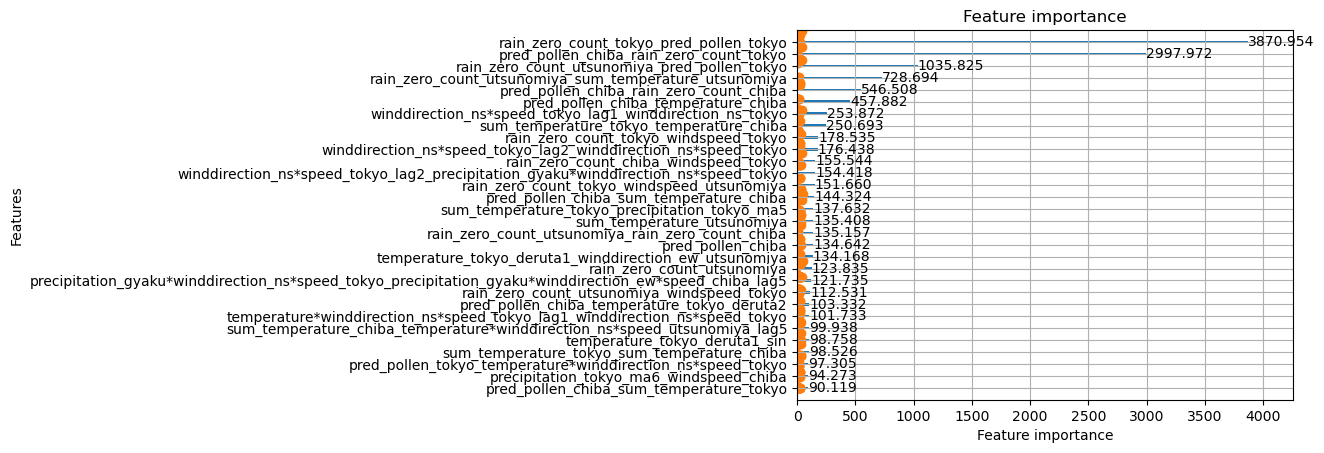

In [2972]:
#lgb_tokyo_1 = lgbm_s("tokyo",df_train_test_x_t,df_train_test_y_t,df_test_x_t,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_t_1" )
lgb_tokyo_1 = lgbm_o("tokyo",df_train_test_x_t,df_train_test_y_t,df_test_x_t,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_t_1" )

### ---2

In [2973]:
#train_travalをtrainとvalidに分割
df_traval_y_t_2 = df_train_traval_t_2[{"pollen_tokyo", "pollen_tokyo_cat"}]
df_traval_x_t_2 = df_train_traval_t_2.drop({"pollen_tokyo" ,"pollen_tokyo_cat", 
                                 "day", "month" 
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_t_2)
interaction_features = poly.get_feature_names(df_traval_x_t_2.columns)
df_traval_x_t_2 = pd.DataFrame(X_poly, columns=interaction_features)

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_t_2, df_traval_y_t_2, test_size=0.3, random_state=42)

[I 2023-01-08 17:34:36,593] A new study created in memory with name: no-name-7e96ee03-f786-43c7-8e37-62db09b23aa4
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.341124:   0%|                                                     | 0/7 [02:35<?, ?it/s]

Early stopping, best iteration is:
[848]	valid_0's huber: 0.000121055	valid_1's huber: 0.341124


feature_fraction, val_score: 0.341124:  14%|######2                                     | 1/7 [02:35<15:35, 155.88s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.338799:  14%|######2                                     | 1/7 [06:01<15:35, 155.88s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.51607e-05	valid_1's huber: 0.338799


feature_fraction, val_score: 0.338799:  29%|############5                               | 2/7 [06:01<15:25, 185.12s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.338799:  29%|############5                               | 2/7 [08:19<15:25, 185.12s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.71294e-05	valid_1's huber: 0.342569


feature_fraction, val_score: 0.338799:  43%|##################8                         | 3/7 [08:19<10:54, 163.62s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.66119e-05	valid_1's huber: 0.338715


feature_fraction, val_score: 0.338715:  57%|#########################1                  | 4/7 [12:25<09:47, 195.92s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.43182e-05	valid_1's huber: 0.345096


feature_fraction, val_score: 0.338715:  71%|###############################4            | 5/7 [15:30<06:24, 192.04s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.26569e-05	valid_1's huber: 0.34438


feature_fraction, val_score: 0.338715:  86%|#####################################7      | 6/7 [17:23<02:45, 165.12s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.6969e-05	valid_1's huber: 0.340563


num_leaves, val_score: 0.338715:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[725]	valid_0's huber: 1.04012e-05	valid_1's huber: 0.344216


num_leaves, val_score: 0.338715:   5%|##3                                           | 1/20 [17:30<5:32:43, 1050.73s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[761]	valid_0's huber: 1.48363e-05	valid_1's huber: 0.34716


num_leaves, val_score: 0.338715:  10%|####6                                         | 2/20 [34:14<5:06:55, 1023.07s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00123917	valid_1's huber: 0.342578


num_leaves, val_score: 0.338715:  15%|#######                                        | 3/20 [38:07<3:07:35, 662.07s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[421]	valid_0's huber: 7.60911e-05	valid_1's huber: 0.346228


num_leaves, val_score: 0.338715:  20%|#########4                                     | 4/20 [55:30<3:36:43, 812.70s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[555]	valid_0's huber: 4.55264e-05	valid_1's huber: 0.344208


num_leaves, val_score: 0.338715:  25%|###########2                                 | 5/20 [1:08:37<3:20:52, 803.50s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.13916	valid_1's huber: 0.401371


num_leaves, val_score: 0.338715:  30%|#############5                               | 6/20 [1:10:15<2:11:28, 563.44s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.65035e-06	valid_1's huber: 0.348889


num_leaves, val_score: 0.338715:  35%|###############7                             | 7/20 [1:38:06<3:20:34, 925.75s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[759]	valid_0's huber: 1.88949e-05	valid_1's huber: 0.343043


num_leaves, val_score: 0.338715:  40%|##################                           | 8/20 [1:46:55<2:39:52, 799.39s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[757]	valid_0's huber: 9.03038e-06	valid_1's huber: 0.348819


num_leaves, val_score: 0.338715:  45%|####################2                        | 9/20 [2:01:23<2:30:29, 820.87s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[650]	valid_0's huber: 2.20904e-05	valid_1's huber: 0.337012


num_leaves, val_score: 0.337012:  50%|######################                      | 10/20 [2:09:04<1:58:17, 709.80s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[820]	valid_0's huber: 1.31694e-05	valid_1's huber: 0.344671


num_leaves, val_score: 0.337012:  55%|########################2                   | 11/20 [2:15:59<1:32:55, 619.50s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.337012:  60%|##########################4                 | 12/20 [2:17:31<1:01:12, 459.02s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.0378136	valid_1's huber: 0.366681


[I 2023-01-08 20:13:17,026] Trial 18 finished with value: 0.3666808813849068 and parameters: {'num_leaves': 10}. Best is trial 16 with value: 0.3370124075280241.
num_leaves, val_score: 0.337012:  60%|##########################4                 | 12/20 [2:17:31<1:01:12, 459.02s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.85813e-06	valid_1's huber: 0.342141


num_leaves, val_score: 0.337012:  65%|#############################9                | 13/20 [2:24:04<51:11, 438.81s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.46291e-06	valid_1's huber: 0.342518


num_leaves, val_score: 0.337012:  70%|################################1             | 14/20 [2:31:50<44:42, 447.04s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[790]	valid_0's huber: 1.18719e-05	valid_1's huber: 0.342857


num_leaves, val_score: 0.337012:  75%|##################################5           | 15/20 [2:40:39<39:18, 471.78s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[712]	valid_0's huber: 2.51538e-05	valid_1's huber: 0.342343


num_leaves, val_score: 0.337012:  80%|####################################8         | 16/20 [2:45:30<27:49, 417.44s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[770]	valid_0's huber: 1.06561e-05	valid_1's huber: 0.345955


num_leaves, val_score: 0.337012:  85%|#######################################1      | 17/20 [3:04:12<31:28, 629.37s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[682]	valid_0's huber: 2.20597e-05	valid_1's huber: 0.343107


num_leaves, val_score: 0.337012:  90%|#########################################4    | 18/20 [3:13:54<20:30, 615.09s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.07583e-07	valid_1's huber: 0.340394


num_leaves, val_score: 0.337012:  95%|###########################################6  | 19/20 [3:20:01<09:00, 540.67s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[654]	valid_0's huber: 2.3827e-05	valid_1's huber: 0.340314


bagging, val_score: 0.337012:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.96969e-05	valid_1's huber: 0.361007


bagging, val_score: 0.337012:  10%|#####                                             | 1/10 [09:56<1:29:23, 595.98s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.81917e-06	valid_1's huber: 0.340179


bagging, val_score: 0.337012:  20%|##########                                        | 2/10 [20:01<1:20:11, 601.40s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.25755e-05	valid_1's huber: 0.354133


bagging, val_score: 0.337012:  30%|###############                                   | 3/10 [30:18<1:10:59, 608.50s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.23375e-05	valid_1's huber: 0.347153


bagging, val_score: 0.337012:  40%|####################                              | 4/10 [40:24<1:00:44, 607.45s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.8201e-06	valid_1's huber: 0.346144


bagging, val_score: 0.337012:  50%|##########################                          | 5/10 [50:31<50:37, 607.42s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.513e-05	valid_1's huber: 0.354451


bagging, val_score: 0.337012:  60%|##############################                    | 6/10 [1:00:54<40:51, 612.85s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 8.07276e-05	valid_1's huber: 0.356317


bagging, val_score: 0.337012:  70%|###################################               | 7/10 [1:11:20<30:50, 616.99s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[402]	valid_0's huber: 0.00167084	valid_1's huber: 0.365886


bagging, val_score: 0.337012:  80%|########################################          | 8/10 [1:16:33<17:20, 520.42s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[413]	valid_0's huber: 0.00168853	valid_1's huber: 0.370378


bagging, val_score: 0.337012:  90%|#############################################     | 9/10 [1:21:40<07:33, 453.61s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[568]	valid_0's huber: 0.00089272	valid_1's huber: 0.366443


feature_fraction_stage2, val_score: 0.337012:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[827]	valid_0's huber: 2.21988e-05	valid_1's huber: 0.344447


feature_fraction_stage2, val_score: 0.337012:  33%|############3                        | 1/3 [09:55<19:51, 595.63s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.76532e-06	valid_1's huber: 0.339766


feature_fraction_stage2, val_score: 0.337012:  67%|########################6            | 2/3 [19:55<09:57, 597.93s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[684]	valid_0's huber: 1.59826e-05	valid_1's huber: 0.339639


regularization_factors, val_score: 0.337012:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[840]	valid_0's huber: 1.48999e-05	valid_1's huber: 0.343471


regularization_factors, val_score: 0.337012:   5%|#7                                 | 1/20 [11:00<3:29:02, 660.12s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[845]	valid_0's huber: 4.53269e-06	valid_1's huber: 0.339748


regularization_factors, val_score: 0.337012:  10%|###5                               | 2/20 [21:03<3:07:56, 626.50s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.38565e-06	valid_1's huber: 0.340958


regularization_factors, val_score: 0.337012:  15%|#####2                             | 3/20 [31:15<2:55:36, 619.80s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.8955e-06	valid_1's huber: 0.33825


regularization_factors, val_score: 0.337012:  20%|#######                            | 4/20 [41:23<2:44:02, 615.18s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.04799e-06	valid_1's huber: 0.341173


regularization_factors, val_score: 0.337012:  25%|########7                          | 5/20 [50:39<2:28:28, 593.92s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[535]	valid_0's huber: 4.67794e-05	valid_1's huber: 0.337037


regularization_factors, val_score: 0.337012:  30%|##########5                        | 6/20 [57:11<2:02:36, 525.49s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[619]	valid_0's huber: 3.68463e-05	valid_1's huber: 0.340457


regularization_factors, val_score: 0.337012:  35%|###########5                     | 7/20 [1:04:15<1:46:39, 492.27s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[696]	valid_0's huber: 2.14778e-05	valid_1's huber: 0.335763


regularization_factors, val_score: 0.335763:  40%|#############2                   | 8/20 [1:08:20<1:22:40, 413.35s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.74792e-06	valid_1's huber: 0.33921


regularization_factors, val_score: 0.335763:  45%|##############8                  | 9/20 [1:14:32<1:13:25, 400.53s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[648]	valid_0's huber: 2.50233e-05	valid_1's huber: 0.338313


regularization_factors, val_score: 0.335763:  50%|################                | 10/20 [1:20:08<1:03:25, 380.57s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	valid_0's huber: 0.00611955	valid_1's huber: 0.347742


regularization_factors, val_score: 0.335763:  55%|##################7               | 11/20 [1:21:31<43:26, 289.66s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[545]	valid_0's huber: 4.22016e-05	valid_1's huber: 0.337204


regularization_factors, val_score: 0.335763:  60%|####################4             | 12/20 [1:28:17<43:19, 324.90s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[536]	valid_0's huber: 4.62696e-05	valid_1's huber: 0.337015


regularization_factors, val_score: 0.335763:  65%|######################1           | 13/20 [1:34:56<40:31, 347.40s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[708]	valid_0's huber: 1.15195e-05	valid_1's huber: 0.339887


regularization_factors, val_score: 0.335763:  70%|#######################7          | 14/20 [1:43:08<39:06, 391.13s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[345]	valid_0's huber: 0.00335656	valid_1's huber: 0.342176


regularization_factors, val_score: 0.335763:  75%|#########################5        | 15/20 [1:44:41<25:06, 301.23s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[558]	valid_0's huber: 4.12095e-05	valid_1's huber: 0.343386


regularization_factors, val_score: 0.335763:  80%|###########################2      | 16/20 [1:51:30<22:13, 333.47s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[584]	valid_0's huber: 2.71485e-05	valid_1's huber: 0.340734


regularization_factors, val_score: 0.335763:  85%|############################9     | 17/20 [1:58:30<17:58, 359.57s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[829]	valid_0's huber: 1.39209e-05	valid_1's huber: 0.342223


regularization_factors, val_score: 0.335763:  90%|##############################6   | 18/20 [2:02:24<10:43, 321.79s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[440]	valid_0's huber: 9.08908e-05	valid_1's huber: 0.337044


regularization_factors, val_score: 0.335763:  95%|################################3 | 19/20 [2:09:58<06:01, 361.65s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[708]	valid_0's huber: 1.57994e-05	valid_1's huber: 0.337042


min_data_in_leaf, val_score: 0.335763:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	valid_0's huber: 0.000107714	valid_1's huber: 0.341669


min_data_in_leaf, val_score: 0.335763:  20%|########8                                   | 1/5 [05:23<21:32, 323.18s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[493]	valid_0's huber: 7.63551e-06	valid_1's huber: 0.342716


min_data_in_leaf, val_score: 0.335763:  40%|#################6                          | 2/5 [11:17<17:04, 341.47s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.19311e-05	valid_1's huber: 0.341638


min_data_in_leaf, val_score: 0.335763:  60%|##########################4                 | 3/5 [15:50<10:20, 310.40s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000109361	valid_1's huber: 0.342258


min_data_in_leaf, val_score: 0.335763:  80%|###################################2        | 4/5 [20:51<05:06, 306.31s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000223448	valid_1's huber: 0.349903


min_data_in_leaf, val_score: 0.335763: 100%|############################################| 5/5 [25:39<00:00, 307.88s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.2632744205189385, 'lambda_l2': 2.7803200431406984e-08, 'num_leaves': 82, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 8.767104570661658


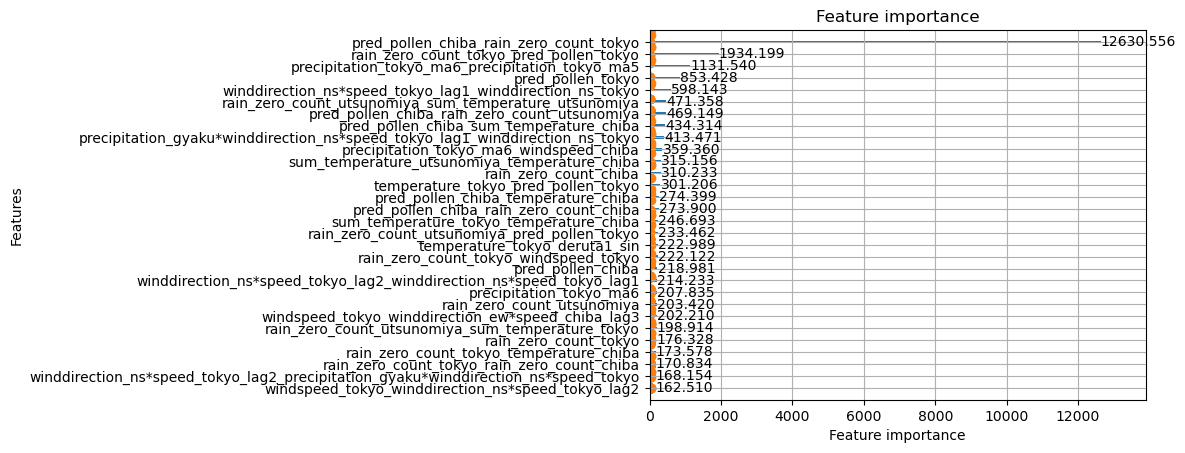

In [2974]:
#lgb_tokyo_2 = lgbm_s("tokyo",df_train_test_x_t,df_train_test_y_t,df_test_x_t,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_t_2" )
lgb_tokyo_2 = lgbm_o("tokyo",df_train_test_x_t,df_train_test_y_t,df_test_x_t,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_t_2" )

### ---Ave. CV

MAE
lgbm 8.638789376086915


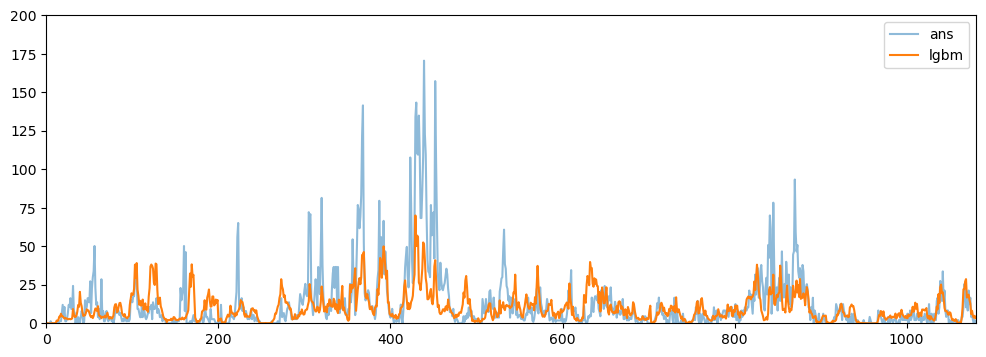

In [2975]:
r = 2

df_pred["pollen_"+region_list[r]+"_lgbm"] = (df_pred["pollen_"+region_list[r]+"_lgbm_t_0"]+df_pred["pollen_"+region_list[r]+"_lgbm_t_1"]+df_pred["pollen_"+region_list[r]+"_lgbm_t_2"])/3

plt.figure(figsize=(12,4))
plt.plot(np.array(df_train_test_y_t["pollen_"+region_list[r]]), alpha=0.5, label="ans")
plt.plot(df_pred["pollen_"+region_list[r]+"_lgbm"], label="lgbm")
plt.legend()
plt.xlim(0,len(df_pred))
plt.ylim(0,200)

print("MAE")
print("lgbm",mean_absolute_error(df_pred["pollen_"+region_list[r]+"_lgbm"], np.array(df_train_test_y_t["pollen_"+region_list[r]])))

In [2976]:
#sub
r = 2

### lgbm
df_submission["pollen_"+region_list[r]] = (df_sub["pollen_"+region_list[r]+"_lgbm_t_0"]+df_sub["pollen_"+region_list[r]+"_lgbm_t_1"]+df_sub["pollen_"+region_list[r]+"_lgbm_t_2"])/3

#4の倍数にそろえる
for i in range(1000):
    df_submission["pollen_tokyo"][(df_submission["pollen_tokyo"] > i*4-2) & (df_submission["pollen_tokyo"] <= i*4+2)] = i*4

In [2978]:
df_submission.to_csv("submission_06.csv", index = False)

# 特徴量を上位100個に絞る

In [4002]:
feature_number_u = 500#使用する特徴量の数(上位からn個)
feature_number_c = 500#使用する特徴量の数(上位からn個)
feature_number_t = 500#使用する特徴量の数(上位からn個)

select_seed = 3 #1～10までsubmissionファイルを作成してFinal_Averagingでアベレージ

## utsunomiya

In [4003]:
utsunomiya_importance = lgb_utsunomiya_0[0] + lgb_utsunomiya_1[0] + lgb_utsunomiya_2[0]
utsunomiya_importance = utsunomiya_importance.sort_values(by="importance", ascending=False)
utsunomiya_importance_100 = utsunomiya_importance.index[0:feature_number_u]

In [4004]:
# 閾値3以下を分割(Statified k-fold)
X = df_train_traval_u_under.copy()
y= df_train_traval_u_under["pollen_utsunomiya_cat"]
skf = StratifiedKFold(n_splits=3, random_state=select_seed, shuffle=True)
skf.get_n_splits(X, y)

df_train_idx = pd.DataFrame()
df_valid_idx = pd.DataFrame()

print(skf)
for i, (train_index) in enumerate(skf.split(X, y)):
    df_train_idx[i] = train_index

StratifiedKFold(n_splits=3, random_state=3, shuffle=True)


In [4005]:
df_train_traval_u_0 = df_train_traval_u_under.loc[df_train_idx[0][1].tolist()]
df_train_traval_u_1 = df_train_traval_u_under.loc[df_train_idx[1][1].tolist()]
df_train_traval_u_2 = df_train_traval_u_under.loc[df_train_idx[2][1].tolist()]

df_train_traval_u_0 =pd.concat([df_train_traval_u_0, df_train_traval_u_1, df_train_traval_u_over], axis = 0)
df_train_traval_u_1 =pd.concat([df_train_traval_u_1, df_train_traval_u_2, df_train_traval_u_over], axis = 0)
df_train_traval_u_2 =pd.concat([df_train_traval_u_2, df_train_traval_u_0, df_train_traval_u_over], axis = 0)

### ---0

In [4006]:
#train_travalをtrainとvalidに分割
df_traval_y_u_0 = df_train_traval_u_0[{"pollen_utsunomiya", "pollen_utsunomiya_cat"}]
df_traval_x_u_0 = df_train_traval_u_0.drop({"pollen_utsunomiya" ,"pollen_utsunomiya_cat", 
                                 "day", "month" 
                                }, axis=1)

df_test_x_u = df_test_lgbm_u.drop({"pollen_utsunomiya",
                                 "day", "month",
                                }, axis=1)
df_train_test_y_u = df_train_test_u[{"pollen_utsunomiya", "pollen_utsunomiya_cat"}]
df_train_test_x_u = df_train_test_u.drop({"pollen_utsunomiya", "pollen_utsunomiya_cat",
                                 "day", "month",
                                }, axis=1)

#交互作用作成
from sklearn.preprocessing import PolynomialFeatures

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_u_0)
interaction_features = poly.get_feature_names(df_traval_x_u_0.columns)
df_traval_x_u_0 = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_test_x_u)
interaction_features = poly.get_feature_names(df_test_x_u.columns)
df_test_x_u = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_train_test_x_u)
interaction_features = poly.get_feature_names(df_train_test_x_u.columns)
df_train_test_x_u = pd.DataFrame(X_poly, columns=interaction_features)

df_traval_x_u_0_100 = df_traval_x_u_0[utsunomiya_importance_100]
df_test_x_u_100 = df_test_x_u[utsunomiya_importance_100]
df_train_test_x_u_100 = df_train_test_x_u[utsunomiya_importance_100]

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_u_0_100, df_traval_y_u_0, test_size=0.3, random_state=select_seed)

In [4007]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((4655, 500), (1995, 500), (4655, 2), (1995, 2))

[I 2023-01-09 20:46:13,049] A new study created in memory with name: no-name-2be7d9d7-b01e-4be4-999d-7c1646c2461b
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.335701:  14%|######4                                      | 1/7 [00:03<00:18,  3.11s/it]

Early stopping, best iteration is:
[342]	valid_0's huber: 0.0107591	valid_1's huber: 0.335701
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.335177:  29%|############8                                | 2/7 [00:06<00:15,  3.20s/it]

Early stopping, best iteration is:
[409]	valid_0's huber: 0.00497906	valid_1's huber: 0.335177
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.335177:  43%|###################2                         | 3/7 [00:09<00:12,  3.14s/it]

Early stopping, best iteration is:
[253]	valid_0's huber: 0.0262721	valid_1's huber: 0.338516
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.335177:  57%|#########################7                   | 4/7 [00:14<00:11,  3.74s/it]

Early stopping, best iteration is:
[522]	valid_0's huber: 0.00134894	valid_1's huber: 0.339863
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.335177:  71%|################################1            | 5/7 [00:17<00:07,  3.74s/it]

Early stopping, best iteration is:
[839]	valid_0's huber: 7.55813e-05	valid_1's huber: 0.335658
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.335177:  86%|######################################5      | 6/7 [00:21<00:03,  3.85s/it]

Early stopping, best iteration is:
[768]	valid_0's huber: 0.000134358	valid_1's huber: 0.335642
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.335177: 100%|#############################################| 7/7 [00:24<00:00,  3.47s/it]


Early stopping, best iteration is:
[317]	valid_0's huber: 0.0156086	valid_1's huber: 0.338348


num_leaves, val_score: 0.335177:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.332621:   5%|##5                                               | 1/20 [00:09<03:00,  9.51s/it]

Early stopping, best iteration is:
[294]	valid_0's huber: 0.00024681	valid_1's huber: 0.332621
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.332621:  10%|#####                                             | 2/20 [00:10<01:19,  4.39s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.380979	valid_1's huber: 0.438128
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.332621:  15%|#######5                                          | 3/20 [00:16<01:28,  5.22s/it]

Early stopping, best iteration is:
[220]	valid_0's huber: 0.000633056	valid_1's huber: 0.333883
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.332621:  20%|##########                                        | 4/20 [00:22<01:25,  5.33s/it]

Early stopping, best iteration is:
[255]	valid_0's huber: 0.000585424	valid_1's huber: 0.333523
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.332621:  25%|############5                                     | 5/20 [00:27<01:20,  5.35s/it]

Early stopping, best iteration is:
[259]	valid_0's huber: 0.000645445	valid_1's huber: 0.334744
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.332621:  30%|###############                                   | 6/20 [00:32<01:15,  5.37s/it]

Early stopping, best iteration is:
[375]	valid_0's huber: 0.000335005	valid_1's huber: 0.335981
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.332621:  35%|#################5                                | 7/20 [00:40<01:17,  5.97s/it]

Early stopping, best iteration is:
[251]	valid_0's huber: 0.000393925	valid_1's huber: 0.335526
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.332621:  40%|####################                              | 8/20 [00:46<01:15,  6.26s/it]

Early stopping, best iteration is:
[600]	valid_0's huber: 4.7119e-05	valid_1's huber: 0.335171
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.332621:  45%|######################5                           | 9/20 [00:51<01:04,  5.83s/it]

Early stopping, best iteration is:
[830]	valid_0's huber: 0.00018458	valid_1's huber: 0.334311
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.332621:  50%|########################5                        | 10/20 [01:01<01:10,  7.08s/it]

Early stopping, best iteration is:
[295]	valid_0's huber: 0.000171626	valid_1's huber: 0.335031
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.331660:  55%|##########################9                      | 11/20 [01:11<01:10,  7.83s/it]

Early stopping, best iteration is:
[214]	valid_0's huber: 0.000563037	valid_1's huber: 0.33166
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.331660:  60%|#############################4                   | 12/20 [01:20<01:06,  8.33s/it]

Early stopping, best iteration is:
[214]	valid_0's huber: 0.000563037	valid_1's huber: 0.33166
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.331660:  65%|###############################8                 | 13/20 [01:30<01:01,  8.73s/it]

Early stopping, best iteration is:
[214]	valid_0's huber: 0.000563037	valid_1's huber: 0.33166
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.331660:  70%|##################################3              | 14/20 [01:39<00:54,  9.01s/it]

Early stopping, best iteration is:
[214]	valid_0's huber: 0.000563037	valid_1's huber: 0.33166
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.331660:  75%|####################################7            | 15/20 [01:49<00:45,  9.15s/it]

Early stopping, best iteration is:
[214]	valid_0's huber: 0.000563037	valid_1's huber: 0.33166
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.329726:  80%|#######################################2         | 16/20 [01:56<00:34,  8.66s/it]

Early stopping, best iteration is:
[149]	valid_0's huber: 0.00222375	valid_1's huber: 0.329726
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.328432:  85%|#########################################6       | 17/20 [02:04<00:24,  8.24s/it]

Early stopping, best iteration is:
[142]	valid_0's huber: 0.00281694	valid_1's huber: 0.328432
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.328432:  90%|############################################1    | 18/20 [02:12<00:16,  8.34s/it]

Early stopping, best iteration is:
[188]	valid_0's huber: 0.00108146	valid_1's huber: 0.334235
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.328432:  95%|##############################################5  | 19/20 [02:20<00:08,  8.10s/it]

Early stopping, best iteration is:
[151]	valid_0's huber: 0.00213687	valid_1's huber: 0.331778
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.328432: 100%|#################################################| 20/20 [02:28<00:00,  7.40s/it]


Early stopping, best iteration is:
[151]	valid_0's huber: 0.00220948	valid_1's huber: 0.329282


bagging, val_score: 0.328432:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.328432:  10%|#####3                                               | 1/10 [00:08<01:17,  8.58s/it]

Early stopping, best iteration is:
[172]	valid_0's huber: 0.00183577	valid_1's huber: 0.339875
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.328432:  20%|##########6                                          | 2/10 [00:13<00:51,  6.44s/it]

Early stopping, best iteration is:
[194]	valid_0's huber: 0.0104694	valid_1's huber: 0.357454
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.328432:  30%|###############9                                     | 3/10 [00:16<00:35,  5.06s/it]

Early stopping, best iteration is:
[153]	valid_0's huber: 0.0310138	valid_1's huber: 0.371254
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.328432:  40%|#####################2                               | 4/10 [00:23<00:34,  5.83s/it]

Early stopping, best iteration is:
[182]	valid_0's huber: 0.00241782	valid_1's huber: 0.341061
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.328432:  50%|##########################5                          | 5/10 [00:30<00:30,  6.14s/it]

Early stopping, best iteration is:
[284]	valid_0's huber: 0.00264132	valid_1's huber: 0.350534
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.328432:  60%|###############################8                     | 6/10 [00:36<00:23,  5.91s/it]

Early stopping, best iteration is:
[257]	valid_0's huber: 0.00524442	valid_1's huber: 0.355678
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.328432:  70%|#####################################                | 7/10 [00:41<00:17,  5.79s/it]

Early stopping, best iteration is:
[156]	valid_0's huber: 0.00650498	valid_1's huber: 0.344316
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.328432:  80%|##########################################4          | 8/10 [00:48<00:12,  6.29s/it]

Early stopping, best iteration is:
[148]	valid_0's huber: 0.00265297	valid_1's huber: 0.3318
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.328432:  90%|###############################################7     | 9/10 [00:55<00:06,  6.44s/it]

Early stopping, best iteration is:
[144]	valid_0's huber: 0.00398575	valid_1's huber: 0.337274
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.328432: 100%|####################################################| 10/10 [01:00<00:00,  6.01s/it]


Early stopping, best iteration is:
[178]	valid_0's huber: 0.0135362	valid_1's huber: 0.359006


feature_fraction_stage2, val_score: 0.328432:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.328432:  17%|######3                               | 1/6 [00:07<00:35,  7.04s/it]

Early stopping, best iteration is:
[113]	valid_0's huber: 0.00555548	valid_1's huber: 0.33206
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.328432:  33%|############6                         | 2/6 [00:13<00:25,  6.41s/it]

Early stopping, best iteration is:
[107]	valid_0's huber: 0.00659604	valid_1's huber: 0.334486
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.326208:  50%|###################                   | 3/6 [00:19<00:19,  6.45s/it]

Early stopping, best iteration is:
[110]	valid_0's huber: 0.00637186	valid_1's huber: 0.326208
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.326208:  67%|#########################3            | 4/6 [00:26<00:13,  6.60s/it]

Early stopping, best iteration is:
[130]	valid_0's huber: 0.00366181	valid_1's huber: 0.332695
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.326208:  83%|###############################6      | 5/6 [00:37<00:08,  8.32s/it]

Early stopping, best iteration is:
[259]	valid_0's huber: 0.00035626	valid_1's huber: 0.330321
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.326208: 100%|######################################| 6/6 [00:43<00:00,  7.28s/it]


Early stopping, best iteration is:
[114]	valid_0's huber: 0.00581296	valid_1's huber: 0.331836


regularization_factors, val_score: 0.326208:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.326208:   5%|#9                                    | 1/20 [00:03<01:03,  3.36s/it]

Early stopping, best iteration is:
[175]	valid_0's huber: 0.00464213	valid_1's huber: 0.335019
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.326208:  10%|###8                                  | 2/20 [00:11<01:47,  5.97s/it]

Early stopping, best iteration is:
[134]	valid_0's huber: 0.00321988	valid_1's huber: 0.329557
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.326208:  15%|#####7                                | 3/20 [00:18<01:55,  6.78s/it]

Early stopping, best iteration is:
[134]	valid_0's huber: 0.00321988	valid_1's huber: 0.329556
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.326208:  20%|#######6                              | 4/20 [00:27<01:56,  7.31s/it]

Early stopping, best iteration is:
[144]	valid_0's huber: 0.00262318	valid_1's huber: 0.330974
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.326208:  25%|#########5                            | 5/20 [00:37<02:04,  8.28s/it]

Early stopping, best iteration is:
[194]	valid_0's huber: 0.000910302	valid_1's huber: 0.329097
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.326208:  30%|###########4                          | 6/20 [00:39<01:29,  6.40s/it]

Early stopping, best iteration is:
[298]	valid_0's huber: 0.00842584	valid_1's huber: 0.337391
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.326208:  35%|#############3                        | 7/20 [00:51<01:45,  8.14s/it]

Early stopping, best iteration is:
[254]	valid_0's huber: 0.000343624	valid_1's huber: 0.33203
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.326208:  40%|###############2                      | 8/20 [01:00<01:41,  8.43s/it]

Early stopping, best iteration is:
[207]	valid_0's huber: 0.00126313	valid_1's huber: 0.336371
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.326208:  45%|#################1                    | 9/20 [01:07<01:27,  7.97s/it]

Early stopping, best iteration is:
[110]	valid_0's huber: 0.00637187	valid_1's huber: 0.326208
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.326208:  50%|##################5                  | 10/20 [01:14<01:18,  7.82s/it]

Early stopping, best iteration is:
[158]	valid_0's huber: 0.00178067	valid_1's huber: 0.331335
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.324768:  55%|####################3                | 11/20 [01:23<01:11,  7.96s/it]

Early stopping, best iteration is:
[149]	valid_0's huber: 0.00234996	valid_1's huber: 0.324768
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.324768:  60%|######################2              | 12/20 [01:32<01:07,  8.46s/it]

Early stopping, best iteration is:
[189]	valid_0's huber: 0.000977378	valid_1's huber: 0.328738
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.324768:  65%|########################             | 13/20 [01:41<00:58,  8.42s/it]

Early stopping, best iteration is:
[149]	valid_0's huber: 0.00240091	valid_1's huber: 0.330315
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.324768:  70%|#########################9           | 14/20 [01:48<00:49,  8.21s/it]

Early stopping, best iteration is:
[134]	valid_0's huber: 0.00321988	valid_1's huber: 0.329557
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.324768:  75%|###########################7         | 15/20 [01:57<00:41,  8.23s/it]

Early stopping, best iteration is:
[123]	valid_0's huber: 0.00462012	valid_1's huber: 0.328341
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.324768:  80%|#############################6       | 16/20 [02:05<00:32,  8.23s/it]

Early stopping, best iteration is:
[124]	valid_0's huber: 0.00434092	valid_1's huber: 0.326072
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.324768:  85%|###############################4     | 17/20 [02:15<00:25,  8.65s/it]

Early stopping, best iteration is:
[149]	valid_0's huber: 0.0024509	valid_1's huber: 0.328144
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.324768:  90%|#################################3   | 18/20 [02:23<00:17,  8.51s/it]

Early stopping, best iteration is:
[139]	valid_0's huber: 0.00358016	valid_1's huber: 0.333796
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.324768:  95%|###################################1 | 19/20 [02:30<00:08,  8.12s/it]

Early stopping, best iteration is:
[108]	valid_0's huber: 0.00690374	valid_1's huber: 0.328676
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.324768: 100%|#####################################| 20/20 [02:42<00:00,  8.10s/it]


Early stopping, best iteration is:
[195]	valid_0's huber: 0.000772168	valid_1's huber: 0.330791


min_data_in_leaf, val_score: 0.324768:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.324768:  20%|#########                                    | 1/5 [00:09<00:36,  9.24s/it]

Early stopping, best iteration is:
[98]	valid_0's huber: 0.00185472	valid_1's huber: 0.336799
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.324768:  40%|##################                           | 2/5 [00:15<00:22,  7.62s/it]

Early stopping, best iteration is:
[302]	valid_0's huber: 0.00248293	valid_1's huber: 0.342753
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.324768:  60%|###########################                  | 3/5 [00:18<00:11,  5.62s/it]

Early stopping, best iteration is:
[261]	valid_0's huber: 0.0318137	valid_1's huber: 0.344996
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.324768:  80%|####################################         | 4/5 [00:34<00:09,  9.49s/it]

Early stopping, best iteration is:
[216]	valid_0's huber: 6.80289e-07	valid_1's huber: 0.335275
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.324768: 100%|#############################################| 5/5 [00:41<00:00,  8.36s/it]

Early stopping, best iteration is:
[157]	valid_0's huber: 0.00343573	valid_1's huber: 0.3321
Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 3, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 3.289595204458651e-05, 'lambda_l2': 1.2042820576079394e-08, 'num_leaves': 179, 'feature_fraction': 0.716, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 15.429480577903345


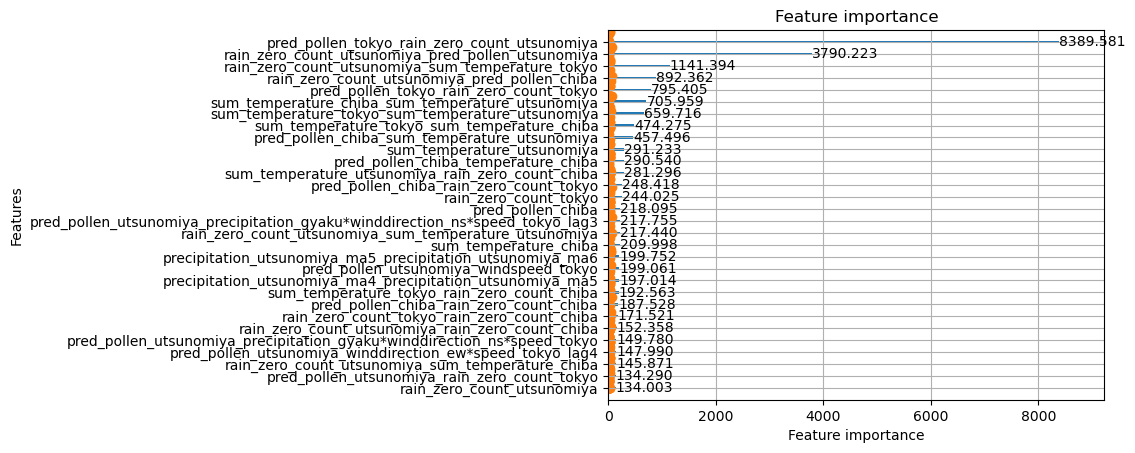

In [4008]:
lgb_utsunomiya_100_seed1_0 = lgbm_o("utsunomiya",df_train_test_x_u_100,df_train_test_y_u,df_test_x_u_100,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_u_0_100_seed1", seed=select_seed )

### ---1

In [4009]:
#train_travalをtrainとvalidに分割
df_traval_y_u_1 = df_train_traval_u_1[{"pollen_utsunomiya", "pollen_utsunomiya_cat"}]
df_traval_x_u_1 = df_train_traval_u_1.drop({"pollen_utsunomiya" ,"pollen_utsunomiya_cat", 
                                 "day", "month" 
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_u_1)
interaction_features = poly.get_feature_names(df_traval_x_u_1.columns)
df_traval_x_u_1 = pd.DataFrame(X_poly, columns=interaction_features)

df_traval_x_u_1_100 = df_traval_x_u_1[utsunomiya_importance_100]

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_u_1_100, df_traval_y_u_1, test_size=0.3, random_state=select_seed)

[I 2023-01-09 20:54:13,730] A new study created in memory with name: no-name-4dd2a25c-bd24-4a96-96ed-7b96abe9ad5d
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.327496:  14%|######4                                      | 1/7 [00:05<00:33,  5.57s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.71059e-05	valid_1's huber: 0.327496
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.327496:  29%|############8                                | 2/7 [00:10<00:26,  5.24s/it]

Early stopping, best iteration is:
[524]	valid_0's huber: 0.00155351	valid_1's huber: 0.332012
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.326757:  43%|###################2                         | 3/7 [00:14<00:18,  4.63s/it]

Early stopping, best iteration is:
[441]	valid_0's huber: 0.00394314	valid_1's huber: 0.326757
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.326757:  57%|#########################7                   | 4/7 [00:22<00:17,  5.93s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.65532e-05	valid_1's huber: 0.327498
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.325098:  71%|################################1            | 5/7 [00:26<00:10,  5.39s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.87546e-05	valid_1's huber: 0.325098
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.325098:  86%|######################################5      | 6/7 [00:30<00:04,  4.73s/it]

Early stopping, best iteration is:
[581]	valid_0's huber: 0.00120523	valid_1's huber: 0.326951
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.325098: 100%|#############################################| 7/7 [00:35<00:00,  5.14s/it]


Early stopping, best iteration is:
[769]	valid_0's huber: 0.000290261	valid_1's huber: 0.329827


num_leaves, val_score: 0.325098:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.320610:   5%|##5                                               | 1/20 [00:08<02:36,  8.26s/it]

Early stopping, best iteration is:
[310]	valid_0's huber: 0.000275796	valid_1's huber: 0.32061
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.320610:  10%|#####                                             | 2/20 [00:12<01:47,  5.99s/it]

Early stopping, best iteration is:
[440]	valid_0's huber: 0.000336666	valid_1's huber: 0.322678
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.320610:  15%|#######5                                          | 3/20 [00:21<02:01,  7.13s/it]

Early stopping, best iteration is:
[310]	valid_0's huber: 0.000275796	valid_1's huber: 0.32061
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.320610:  20%|##########                                        | 4/20 [00:30<02:05,  7.86s/it]

Early stopping, best iteration is:
[310]	valid_0's huber: 0.000275796	valid_1's huber: 0.32061
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.320610:  25%|############5                                     | 5/20 [00:39<02:03,  8.25s/it]

Early stopping, best iteration is:
[310]	valid_0's huber: 0.000275796	valid_1's huber: 0.32061
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.320610:  30%|###############                                   | 6/20 [00:45<01:44,  7.50s/it]

Early stopping, best iteration is:
[662]	valid_0's huber: 0.000170288	valid_1's huber: 0.322988
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.320610:  35%|#################5                                | 7/20 [00:54<01:44,  8.06s/it]

Early stopping, best iteration is:
[315]	valid_0's huber: 0.000254977	valid_1's huber: 0.321075
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.320610:  40%|####################                              | 8/20 [00:58<01:21,  6.81s/it]

Early stopping, best iteration is:
[415]	valid_0's huber: 0.000402745	valid_1's huber: 0.321522
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.320610:  45%|######################5                           | 9/20 [01:03<01:09,  6.27s/it]

Early stopping, best iteration is:
[300]	valid_0's huber: 0.000375171	valid_1's huber: 0.327246
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.320610:  50%|########################5                        | 10/20 [01:12<01:09,  6.99s/it]

Early stopping, best iteration is:
[310]	valid_0's huber: 0.000275796	valid_1's huber: 0.32061
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.319220:  55%|##########################9                      | 11/20 [01:18<01:00,  6.73s/it]

Early stopping, best iteration is:
[211]	valid_0's huber: 0.000828595	valid_1's huber: 0.31922
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.319220:  60%|#############################4                   | 12/20 [01:25<00:53,  6.73s/it]

Early stopping, best iteration is:
[262]	valid_0's huber: 0.000407596	valid_1's huber: 0.321508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.319220:  65%|###############################8                 | 13/20 [01:30<00:45,  6.49s/it]

Early stopping, best iteration is:
[232]	valid_0's huber: 0.000542049	valid_1's huber: 0.322813
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.319220:  70%|##################################3              | 14/20 [01:37<00:39,  6.60s/it]

Early stopping, best iteration is:
[254]	valid_0's huber: 0.000431543	valid_1's huber: 0.321159
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.319220:  75%|####################################7            | 15/20 [01:43<00:31,  6.24s/it]

Early stopping, best iteration is:
[277]	valid_0's huber: 0.000384998	valid_1's huber: 0.323624
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.319220:  80%|#######################################2         | 16/20 [01:45<00:19,  4.94s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.0116785	valid_1's huber: 0.329375
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.319220:  85%|#########################################6       | 17/20 [01:53<00:17,  5.91s/it]

Early stopping, best iteration is:
[310]	valid_0's huber: 0.000275796	valid_1's huber: 0.32061
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.319220:  90%|############################################1    | 18/20 [01:59<00:12,  6.06s/it]

Early stopping, best iteration is:
[262]	valid_0's huber: 0.000407596	valid_1's huber: 0.321508
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.319220:  95%|##############################################5  | 19/20 [02:05<00:06,  6.00s/it]

Early stopping, best iteration is:
[210]	valid_0's huber: 0.000753714	valid_1's huber: 0.322013
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.319220: 100%|#################################################| 20/20 [02:11<00:00,  6.60s/it]


Early stopping, best iteration is:
[317]	valid_0's huber: 0.000220036	valid_1's huber: 0.326487


bagging, val_score: 0.319220:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.319220:  10%|#####3                                               | 1/10 [00:03<00:29,  3.23s/it]

Early stopping, best iteration is:
[194]	valid_0's huber: 0.0108574	valid_1's huber: 0.338956
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.319220:  20%|##########6                                          | 2/10 [00:08<00:35,  4.45s/it]

Early stopping, best iteration is:
[267]	valid_0's huber: 0.00101669	valid_1's huber: 0.333127
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.319220:  30%|###############9                                     | 3/10 [00:12<00:30,  4.39s/it]

Early stopping, best iteration is:
[387]	valid_0's huber: 0.00347303	valid_1's huber: 0.348118
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.319220:  40%|#####################2                               | 4/10 [00:16<00:25,  4.19s/it]

Early stopping, best iteration is:
[195]	valid_0's huber: 0.00735041	valid_1's huber: 0.339764
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.319220:  50%|##########################5                          | 5/10 [00:24<00:26,  5.33s/it]

Early stopping, best iteration is:
[333]	valid_0's huber: 0.000300977	valid_1's huber: 0.329205
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.319220:  60%|###############################8                     | 6/10 [00:29<00:21,  5.40s/it]

Early stopping, best iteration is:
[555]	valid_0's huber: 0.00111081	valid_1's huber: 0.355659
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.319220:  70%|#####################################                | 7/10 [00:34<00:15,  5.19s/it]

Early stopping, best iteration is:
[214]	valid_0's huber: 0.00195334	valid_1's huber: 0.335882
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.319220:  80%|##########################################4          | 8/10 [00:38<00:09,  4.94s/it]

Early stopping, best iteration is:
[231]	valid_0's huber: 0.00306161	valid_1's huber: 0.331814
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.319220:  90%|###############################################7     | 9/10 [00:44<00:05,  5.22s/it]

Early stopping, best iteration is:
[250]	valid_0's huber: 0.000635987	valid_1's huber: 0.328533
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.319220: 100%|####################################################| 10/10 [00:51<00:00,  5.17s/it]


Early stopping, best iteration is:
[310]	valid_0's huber: 0.000302325	valid_1's huber: 0.324854


feature_fraction_stage2, val_score: 0.319220:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.319220:  33%|############6                         | 1/3 [00:04<00:09,  4.79s/it]

Early stopping, best iteration is:
[150]	valid_0's huber: 0.00227691	valid_1's huber: 0.322124
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.319220:  67%|#########################3            | 2/3 [00:10<00:05,  5.32s/it]

Early stopping, best iteration is:
[215]	valid_0's huber: 0.000729563	valid_1's huber: 0.330615
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.319220: 100%|######################################| 3/3 [00:17<00:00,  5.68s/it]


Early stopping, best iteration is:
[225]	valid_0's huber: 0.000562593	valid_1's huber: 0.323579


regularization_factors, val_score: 0.319220:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.319220:   5%|#9                                    | 1/20 [00:05<01:51,  5.88s/it]

Early stopping, best iteration is:
[211]	valid_0's huber: 0.000828595	valid_1's huber: 0.31922
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.319220:  10%|###8                                  | 2/20 [00:11<01:45,  5.88s/it]

Early stopping, best iteration is:
[211]	valid_0's huber: 0.000828595	valid_1's huber: 0.31922
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.319220:  15%|#####7                                | 3/20 [00:19<01:54,  6.71s/it]

Early stopping, best iteration is:
[326]	valid_0's huber: 0.000357614	valid_1's huber: 0.324943
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.319220:  20%|#######6                              | 4/20 [00:25<01:40,  6.28s/it]

Early stopping, best iteration is:
[191]	valid_0's huber: 0.0012397	valid_1's huber: 0.321244
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  25%|#########5                            | 5/20 [00:32<01:38,  6.54s/it]

Early stopping, best iteration is:
[264]	valid_0's huber: 0.000429573	valid_1's huber: 0.317134
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  30%|###########4                          | 6/20 [00:38<01:30,  6.47s/it]

Early stopping, best iteration is:
[232]	valid_0's huber: 0.000624427	valid_1's huber: 0.320189
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  35%|#############3                        | 7/20 [00:44<01:24,  6.48s/it]

Early stopping, best iteration is:
[255]	valid_0's huber: 0.000647872	valid_1's huber: 0.323907
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  40%|###############2                      | 8/20 [00:49<01:12,  6.03s/it]

Early stopping, best iteration is:
[378]	valid_0's huber: 0.00022832	valid_1's huber: 0.323655
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  45%|#################1                    | 9/20 [00:54<01:01,  5.55s/it]

Early stopping, best iteration is:
[348]	valid_0's huber: 0.000253604	valid_1's huber: 0.323833
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  50%|##################5                  | 10/20 [01:01<01:00,  6.08s/it]

Early stopping, best iteration is:
[230]	valid_0's huber: 0.000524396	valid_1's huber: 0.323067
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  55%|####################3                | 11/20 [01:07<00:55,  6.11s/it]

Early stopping, best iteration is:
[211]	valid_0's huber: 0.000751534	valid_1's huber: 0.319086
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  60%|######################2              | 12/20 [01:13<00:47,  5.92s/it]

Early stopping, best iteration is:
[184]	valid_0's huber: 0.00147763	valid_1's huber: 0.320964
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  65%|########################             | 13/20 [01:20<00:44,  6.37s/it]

Early stopping, best iteration is:
[290]	valid_0's huber: 0.000313075	valid_1's huber: 0.318327
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  70%|#########################9           | 14/20 [01:27<00:37,  6.32s/it]

Early stopping, best iteration is:
[225]	valid_0's huber: 0.000668012	valid_1's huber: 0.319167
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  75%|###########################7         | 15/20 [01:32<00:30,  6.06s/it]

Early stopping, best iteration is:
[192]	valid_0's huber: 0.00101985	valid_1's huber: 0.326067
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  80%|#############################6       | 16/20 [01:37<00:23,  5.87s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.00129737	valid_1's huber: 0.322295
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  85%|###############################4     | 17/20 [01:39<00:13,  4.66s/it]

Early stopping, best iteration is:
[310]	valid_0's huber: 0.0297582	valid_1's huber: 0.334818
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  90%|#################################3   | 18/20 [01:46<00:10,  5.28s/it]

Early stopping, best iteration is:
[249]	valid_0's huber: 0.000381593	valid_1's huber: 0.321111
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134:  95%|###################################1 | 19/20 [01:52<00:05,  5.65s/it]

Early stopping, best iteration is:
[234]	valid_0's huber: 0.000571902	valid_1's huber: 0.317486
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.317134: 100%|#####################################| 20/20 [01:59<00:00,  5.99s/it]


Early stopping, best iteration is:
[298]	valid_0's huber: 0.000351907	valid_1's huber: 0.321333


min_data_in_leaf, val_score: 0.317134:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.317134:  20%|#########                                    | 1/5 [00:07<00:27,  6.99s/it]

Early stopping, best iteration is:
[316]	valid_0's huber: 0.000401298	valid_1's huber: 0.323328
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.317134:  40%|##################                           | 2/5 [00:14<00:21,  7.11s/it]

Early stopping, best iteration is:
[195]	valid_0's huber: 1.31676e-05	valid_1's huber: 0.324175
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.317134:  60%|###########################                  | 3/5 [00:19<00:12,  6.08s/it]

Early stopping, best iteration is:
[454]	valid_0's huber: 0.000774324	valid_1's huber: 0.32729
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.317134:  80%|####################################         | 4/5 [00:25<00:06,  6.30s/it]

Early stopping, best iteration is:
[193]	valid_0's huber: 0.00023379	valid_1's huber: 0.330398
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.317134: 100%|#############################################| 5/5 [00:29<00:00,  5.92s/it]

Early stopping, best iteration is:
[768]	valid_0's huber: 0.00121673	valid_1's huber: 0.33571
Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 3, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.000499989156255208, 'lambda_l2': 4.452782501045046e-05, 'num_leaves': 152, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}


MAE 15.22520928770467


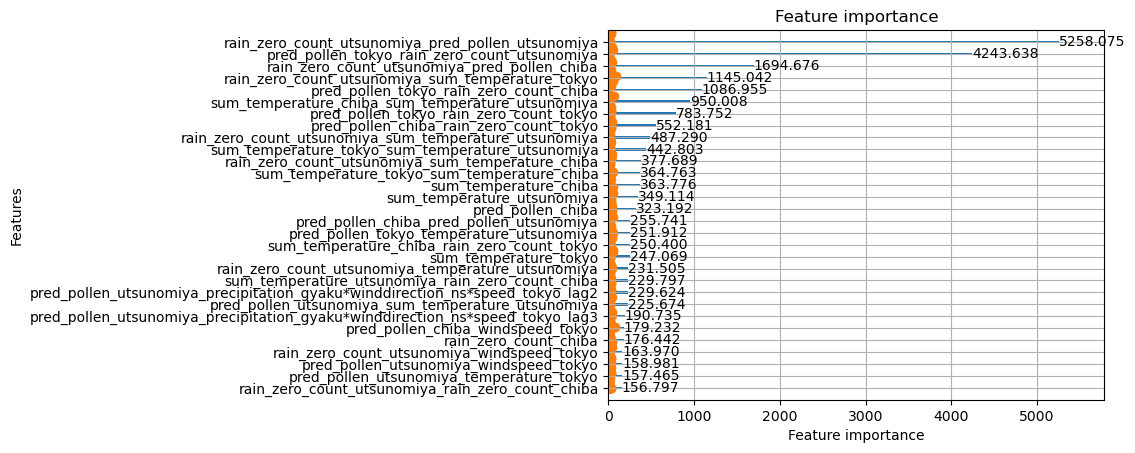

In [4010]:
lgb_utsunomiya_100_seed1_1 = lgbm_o("utsunomiya",df_train_test_x_u_100,df_train_test_y_u,df_test_x_u_100,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_u_1_100_seed1", seed=select_seed )

### ---2

In [4011]:
#train_travalをtrainとvalidに分割
df_traval_y_u_2 = df_train_traval_u_2[{"pollen_utsunomiya", "pollen_utsunomiya_cat"}]
df_traval_x_u_2 = df_train_traval_u_2.drop({"pollen_utsunomiya" ,"pollen_utsunomiya_cat", 
                                 "day", "month" 
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_u_2)
interaction_features = poly.get_feature_names(df_traval_x_u_2.columns)
df_traval_x_u_2 = pd.DataFrame(X_poly, columns=interaction_features)

df_traval_x_u_2_100 = df_traval_x_u_2[utsunomiya_importance_100]

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_u_2_100, df_traval_y_u_2, test_size=0.3, random_state=select_seed)

[I 2023-01-09 21:00:40,531] A new study created in memory with name: no-name-18ea37bc-94a2-486d-bc77-630b0e5b6426
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.235432:  14%|######4                                      | 1/7 [00:04<00:25,  4.27s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000433678	valid_1's huber: 0.235432
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.230718:  29%|############8                                | 2/7 [00:12<00:32,  6.41s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000259256	valid_1's huber: 0.230718
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.230718:  43%|###################2                         | 3/7 [00:17<00:23,  5.80s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000418349	valid_1's huber: 0.231037
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.228504:  57%|#########################7                   | 4/7 [00:25<00:20,  6.74s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00029101	valid_1's huber: 0.228504
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.228504:  71%|################################1            | 5/7 [00:31<00:12,  6.38s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000343736	valid_1's huber: 0.231594
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.228504:  86%|######################################5      | 6/7 [00:38<00:06,  6.53s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000295737	valid_1's huber: 0.229665
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.228504: 100%|#############################################| 7/7 [00:46<00:00,  6.67s/it]


Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000286254	valid_1's huber: 0.229343


num_leaves, val_score: 0.228504:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[377]	valid_0's huber: 0.00013825	valid_1's huber: 0.225733


num_leaves, val_score: 0.225733:   5%|##5                                               | 1/20 [00:24<07:54, 24.97s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.223423:  10%|#####                                             | 2/20 [00:35<04:54, 16.34s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.07642e-05	valid_1's huber: 0.223423
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.223423:  15%|#######5                                          | 3/20 [00:50<04:26, 15.66s/it]

Early stopping, best iteration is:
[574]	valid_0's huber: 3.49585e-05	valid_1's huber: 0.228243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[377]	valid_0's huber: 0.00013825	valid_1's huber: 0.225733


num_leaves, val_score: 0.223423:  20%|##########                                        | 4/20 [01:15<05:10, 19.43s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.223423:  25%|############5                                     | 5/20 [01:25<04:00, 16.04s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.00733e-05	valid_1's huber: 0.224227
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.223423:  30%|###############                                   | 6/20 [01:42<03:49, 16.39s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.17049e-05	valid_1's huber: 0.226029
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.223423:  35%|#################5                                | 7/20 [01:57<03:28, 16.04s/it]

Early stopping, best iteration is:
[316]	valid_0's huber: 0.000337308	valid_1's huber: 0.226029
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.223423:  40%|####################                              | 8/20 [02:08<02:50, 14.21s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.07642e-05	valid_1's huber: 0.223423
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.223423:  45%|######################5                           | 9/20 [02:17<02:18, 12.61s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.05645e-05	valid_1's huber: 0.227743
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.223423:  50%|########################5                        | 10/20 [02:36<02:28, 14.80s/it]

Early stopping, best iteration is:
[333]	valid_0's huber: 0.000187505	valid_1's huber: 0.230718
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.223423:  55%|##########################9                      | 11/20 [02:39<01:40, 11.20s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.0329199	valid_1's huber: 0.25414
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.223423:  60%|#############################4                   | 12/20 [02:54<01:37, 12.24s/it]

Early stopping, best iteration is:
[366]	valid_0's huber: 0.000189051	valid_1's huber: 0.2279
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.223423:  65%|###############################8                 | 13/20 [02:56<01:04,  9.19s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.10633	valid_1's huber: 0.283687
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.222762:  70%|##################################3              | 14/20 [03:11<01:04, 10.74s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.92583e-06	valid_1's huber: 0.222762
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.222762:  75%|####################################7            | 15/20 [03:25<00:59, 11.87s/it]

Early stopping, best iteration is:
[601]	valid_0's huber: 0.000107423	valid_1's huber: 0.225531
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.222762:  80%|#######################################2         | 16/20 [03:39<00:50, 12.61s/it]

Early stopping, best iteration is:
[786]	valid_0's huber: 2.20811e-05	valid_1's huber: 0.223749
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.222762:  85%|#########################################6       | 17/20 [03:57<00:42, 14.05s/it]

Early stopping, best iteration is:
[509]	valid_0's huber: 8.13529e-05	valid_1's huber: 0.228762
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.222762:  90%|############################################1    | 18/20 [04:10<00:27, 13.90s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.29109e-06	valid_1's huber: 0.226084
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.222762:  95%|##############################################5  | 19/20 [04:30<00:15, 15.54s/it]

Early stopping, best iteration is:
[451]	valid_0's huber: 9.00276e-05	valid_1's huber: 0.226699
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.222762: 100%|#################################################| 20/20 [04:46<00:00, 14.34s/it]


Early stopping, best iteration is:
[647]	valid_0's huber: 4.68403e-05	valid_1's huber: 0.226941


bagging, val_score: 0.222762:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.222762:  10%|#####3                                               | 1/10 [00:14<02:11, 14.57s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 7.29123e-06	valid_1's huber: 0.229872
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.222762:  20%|##########6                                          | 2/10 [00:26<01:44, 13.06s/it]

Early stopping, best iteration is:
[709]	valid_0's huber: 0.000105655	valid_1's huber: 0.228106
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.222762:  30%|###############9                                     | 3/10 [00:40<01:35, 13.65s/it]

Early stopping, best iteration is:
[878]	valid_0's huber: 4.34946e-05	valid_1's huber: 0.238064
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.222762:  40%|#####################2                               | 4/10 [00:51<01:14, 12.37s/it]

Early stopping, best iteration is:
[611]	valid_0's huber: 0.000593773	valid_1's huber: 0.244258
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.222762:  50%|##########################5                          | 5/10 [01:06<01:06, 13.29s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.0565e-05	valid_1's huber: 0.224715
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.222762:  60%|###############################8                     | 6/10 [01:21<00:55, 13.79s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.46499e-06	valid_1's huber: 0.22676
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.222762:  70%|#####################################                | 7/10 [01:35<00:42, 14.04s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.67942e-06	valid_1's huber: 0.225353
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.222762:  80%|##########################################4          | 8/10 [01:50<00:28, 14.21s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.01754e-06	valid_1's huber: 0.22706
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.222762:  90%|###############################################7     | 9/10 [02:04<00:14, 14.15s/it]

Early stopping, best iteration is:
[868]	valid_0's huber: 6.95885e-05	valid_1's huber: 0.235167
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.222762: 100%|####################################################| 10/10 [02:18<00:00, 13.83s/it]


Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000153579	valid_1's huber: 0.253169


feature_fraction_stage2, val_score: 0.222762:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.222762:  17%|######3                               | 1/6 [00:14<01:11, 14.37s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 8.07546e-06	valid_1's huber: 0.22601
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.222762:  33%|############6                         | 2/6 [00:29<01:00, 15.09s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.74726e-06	valid_1's huber: 0.226819
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.222762:  50%|###################                   | 3/6 [00:45<00:45, 15.20s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.80012e-06	valid_1's huber: 0.225017
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.222762:  67%|#########################3            | 4/6 [00:57<00:27, 13.89s/it]

Early stopping, best iteration is:
[792]	valid_0's huber: 3.60445e-05	valid_1's huber: 0.225374
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.222762:  83%|###############################6      | 5/6 [01:12<00:14, 14.22s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.25212e-05	valid_1's huber: 0.223276
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.222762: 100%|######################################| 6/6 [01:25<00:00, 14.31s/it]


Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.12469e-05	valid_1's huber: 0.224631


regularization_factors, val_score: 0.222762:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:   5%|#9                                    | 1/20 [00:16<05:17, 16.70s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.12822e-05	valid_1's huber: 0.220965
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  10%|###8                                  | 2/20 [00:31<04:39, 15.51s/it]

Early stopping, best iteration is:
[807]	valid_0's huber: 2.91967e-05	valid_1's huber: 0.224103
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  15%|#####7                                | 3/20 [00:37<03:12, 11.35s/it]

Early stopping, best iteration is:
[534]	valid_0's huber: 0.00158915	valid_1's huber: 0.227596
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  20%|#######6                              | 4/20 [00:53<03:31, 13.23s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.73869e-06	valid_1's huber: 0.222845
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  25%|#########5                            | 5/20 [01:10<03:35, 14.39s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.64365e-06	valid_1's huber: 0.222549
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  30%|###########4                          | 6/20 [01:26<03:28, 14.86s/it]

Early stopping, best iteration is:
[857]	valid_0's huber: 1.50252e-05	valid_1's huber: 0.222655
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  35%|#############3                        | 7/20 [01:30<02:30, 11.57s/it]

Early stopping, best iteration is:
[447]	valid_0's huber: 0.00818505	valid_1's huber: 0.236612
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  40%|###############2                      | 8/20 [01:43<02:23, 11.93s/it]

Early stopping, best iteration is:
[672]	valid_0's huber: 6.23079e-05	valid_1's huber: 0.222634
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  45%|#################1                    | 9/20 [01:58<02:20, 12.75s/it]

Early stopping, best iteration is:
[794]	valid_0's huber: 2.74199e-05	valid_1's huber: 0.22354
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  50%|##################5                  | 10/20 [02:13<02:16, 13.66s/it]

Early stopping, best iteration is:
[869]	valid_0's huber: 1.42757e-05	valid_1's huber: 0.222836
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  55%|####################3                | 11/20 [02:30<02:09, 14.42s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.72545e-05	valid_1's huber: 0.224387
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  60%|######################2              | 12/20 [02:46<02:00, 15.01s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.44209e-06	valid_1's huber: 0.224789
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  65%|########################             | 13/20 [02:59<01:40, 14.40s/it]

Early stopping, best iteration is:
[664]	valid_0's huber: 6.02782e-05	valid_1's huber: 0.222461
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  70%|#########################9           | 14/20 [03:15<01:29, 14.95s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 8.10549e-06	valid_1's huber: 0.224266
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  75%|###########################7         | 15/20 [03:32<01:18, 15.63s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.23845e-06	valid_1's huber: 0.225098
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  80%|#############################6       | 16/20 [03:43<00:56, 14.21s/it]

Early stopping, best iteration is:
[742]	valid_0's huber: 4.35996e-05	valid_1's huber: 0.224296
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  85%|###############################4     | 17/20 [04:00<00:45, 15.03s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.14573e-06	valid_1's huber: 0.222547
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  90%|#################################3   | 18/20 [04:12<00:28, 14.14s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.75634e-05	valid_1's huber: 0.224929
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965:  95%|###################################1 | 19/20 [04:29<00:14, 14.83s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 7.36918e-06	valid_1's huber: 0.224252
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.220965: 100%|#####################################| 20/20 [04:40<00:00, 14.01s/it]


Early stopping, best iteration is:
[604]	valid_0's huber: 7.72475e-05	valid_1's huber: 0.225694


min_data_in_leaf, val_score: 0.220965:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.220965:  20%|#########                                    | 1/5 [00:16<01:06, 16.53s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.52325e-05	valid_1's huber: 0.226322
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.220965:  40%|##################                           | 2/5 [00:33<00:50, 16.71s/it]

Early stopping, best iteration is:
[821]	valid_0's huber: 5.07993e-07	valid_1's huber: 0.2266
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.220965:  60%|###########################                  | 3/5 [00:46<00:30, 15.28s/it]

Early stopping, best iteration is:
[725]	valid_0's huber: 0.000241996	valid_1's huber: 0.228366
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.220965:  80%|####################################         | 4/5 [00:57<00:13, 13.47s/it]

Early stopping, best iteration is:
[769]	valid_0's huber: 0.000712665	valid_1's huber: 0.232473
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.220965: 100%|#############################################| 5/5 [01:14<00:00, 14.85s/it]

Early stopping, best iteration is:
[876]	valid_0's huber: 2.11686e-07	valid_1's huber: 0.227933
Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 3, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0034714694778510773, 'lambda_l2': 0.005327659397321548, 'num_leaves': 66, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}


MAE 15.265670577298627


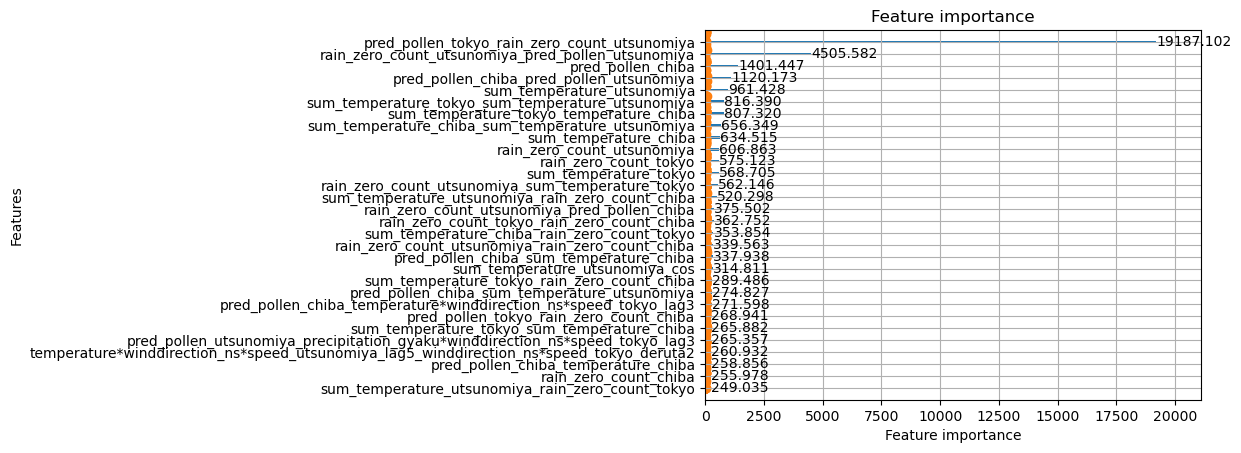

In [4012]:
lgb_utsunomiya_100_seed1_2 = lgbm_o("utsunomiya",df_train_test_x_u_100,df_train_test_y_u,df_test_x_u_100,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_u_2_100_seed1", seed=select_seed )

### ---Ave.

MAE
lgbm 14.973081500327755


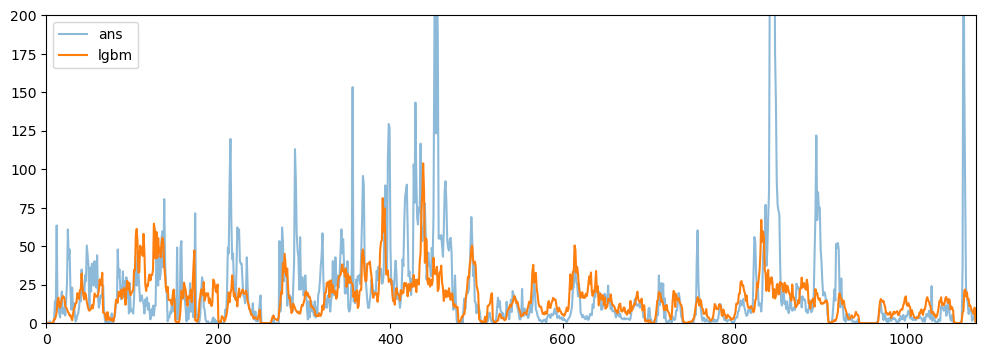

In [4013]:
r = 0

df_pred["pollen_"+region_list[r]+"_lgbm_100_seed1"] = (df_pred["pollen_"+region_list[r]+"_lgbm_u_0_100_seed1"]+df_pred["pollen_"+region_list[r]+"_lgbm_u_1_100_seed1"]+df_pred["pollen_"+region_list[r]+"_lgbm_u_2_100_seed1"])/3

plt.figure(figsize=(12,4))
plt.plot(np.array(df_train_test_y_u["pollen_"+region_list[r]]), alpha=0.5, label="ans")
plt.plot(df_pred["pollen_"+region_list[r]+"_lgbm_100_seed1"], label="lgbm")
plt.legend()
plt.xlim(0,len(df_pred))
plt.ylim(0,200)

print("MAE")
print("lgbm",mean_absolute_error(df_pred["pollen_"+region_list[r]+"_lgbm_100_seed1"], np.array(df_train_test_y_u["pollen_"+region_list[r]])))

In [4014]:
df_submission = pd.read_csv("sample_submission.csv")

In [4015]:
#sub
r = 0

### lgbm 
df_submission["pollen_"+region_list[r]] = (df_sub["pollen_"+region_list[r]+"_lgbm_u_0_100_seed1"]+df_sub["pollen_"+region_list[r]+"_lgbm_u_1_100_seed1"]+df_sub["pollen_"+region_list[r]+"_lgbm_u_2_100_seed1"])/3

#4の倍数にそろえる
#for i in range(1000):
#    df_submission["pollen_utsunomiya"][(df_submission["pollen_utsunomiya"] > i*4-2) & (df_submission["pollen_utsunomiya"] <= i*4+2)] = i*4

## chiba

In [4017]:
chiba_importance = lgb_chiba_0[0] + lgb_chiba_1[0] + lgb_chiba_2[0]
chiba_importance = chiba_importance.sort_values(by="importance", ascending=False)
chiba_importance_100 = chiba_importance.index[0:feature_number_c]

In [4018]:
# 閾値3以下を分割(Statified k-fold)
X = df_train_traval_c_under.copy()
y= df_train_traval_c_under["pollen_chiba_cat"]
skf = StratifiedKFold(n_splits=3, random_state=select_seed, shuffle=True)
skf.get_n_splits(X, y)

df_train_idx = pd.DataFrame()
df_valid_idx = pd.DataFrame()

print(skf)
for i, (train_index) in enumerate(skf.split(X, y)):
    df_train_idx[i] = train_index

StratifiedKFold(n_splits=3, random_state=3, shuffle=True)


In [4019]:
df_train_traval_c_0 = df_train_traval_c_under.loc[df_train_idx[0][1].tolist()]
df_train_traval_c_1 = df_train_traval_c_under.loc[df_train_idx[1][1].tolist()]
df_train_traval_c_2 = df_train_traval_c_under.loc[df_train_idx[2][1].tolist()]

df_train_traval_c_0 =pd.concat([df_train_traval_c_0, df_train_traval_c_1, df_train_traval_c_over], axis = 0)
df_train_traval_c_1 =pd.concat([df_train_traval_c_1, df_train_traval_c_2, df_train_traval_c_over], axis = 0)
df_train_traval_c_2 =pd.concat([df_train_traval_c_2, df_train_traval_c_0, df_train_traval_c_over], axis = 0)

### ---0

In [4020]:
#train_travalをtrainとvalidに分割
df_traval_y_c_0 = df_train_traval_c_0[{"pollen_chiba", "pollen_chiba_cat"}]
df_traval_x_c_0 = df_train_traval_c_0.drop({"pollen_chiba" ,"pollen_chiba_cat", 
                                 "day", "month" 
                                }, axis=1)

df_test_x_c = df_test_lgbm_c.drop({"pollen_chiba",
                                 "day", "month",
                                }, axis=1)
df_train_test_y_c = df_train_test_c[{"pollen_chiba", "pollen_chiba_cat"}]
df_train_test_x_c = df_train_test_c.drop({"pollen_chiba", "pollen_chiba_cat",
                                 "day", "month",
                                }, axis=1)

#交互作用作成
from sklearn.preprocessing import PolynomialFeatures

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_c_0)
interaction_features = poly.get_feature_names(df_traval_x_c_0.columns)
df_traval_x_c_0 = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_test_x_c)
interaction_features = poly.get_feature_names(df_test_x_c.columns)
df_test_x_c = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_train_test_x_c)
interaction_features = poly.get_feature_names(df_train_test_x_c.columns)
df_train_test_x_c = pd.DataFrame(X_poly, columns=interaction_features)

df_traval_x_c_0_100 = df_traval_x_c_0[chiba_importance_100]
df_test_x_c_100 = df_test_x_c[chiba_importance_100]
df_train_test_x_c_100 = df_train_test_x_c[chiba_importance_100]

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_c_0_100, df_traval_y_c_0, test_size=0.3, random_state=select_seed)

[I 2023-01-09 21:15:54,129] A new study created in memory with name: no-name-e1bd4037-b4d3-43aa-b764-5d7d1d66c157
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.393192:  14%|######4                                      | 1/7 [00:03<00:20,  3.40s/it]

Early stopping, best iteration is:
[339]	valid_0's huber: 0.0117098	valid_1's huber: 0.393192
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.391294:  29%|############8                                | 2/7 [00:06<00:16,  3.37s/it]

Early stopping, best iteration is:
[602]	valid_0's huber: 0.000774727	valid_1's huber: 0.391294
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.391294:  43%|###################2                         | 3/7 [00:09<00:12,  3.08s/it]

Early stopping, best iteration is:
[328]	valid_0's huber: 0.0145319	valid_1's huber: 0.401857
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.391294:  57%|#########################7                   | 4/7 [00:16<00:13,  4.52s/it]

Early stopping, best iteration is:
[776]	valid_0's huber: 8.5525e-05	valid_1's huber: 0.40128
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.391294:  71%|################################1            | 5/7 [00:18<00:07,  3.63s/it]

Early stopping, best iteration is:
[247]	valid_0's huber: 0.0377158	valid_1's huber: 0.391873
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.391294:  86%|######################################5      | 6/7 [00:20<00:03,  3.04s/it]

Early stopping, best iteration is:
[328]	valid_0's huber: 0.017949	valid_1's huber: 0.396621
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.391294: 100%|#############################################| 7/7 [00:22<00:00,  3.29s/it]


Early stopping, best iteration is:
[273]	valid_0's huber: 0.0252775	valid_1's huber: 0.398179


num_leaves, val_score: 0.391294:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391294:   5%|##5                                               | 1/20 [00:01<00:24,  1.30s/it]

Early stopping, best iteration is:
[715]	valid_0's huber: 0.112941	valid_1's huber: 0.403622
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391294:  10%|#####                                             | 2/20 [00:08<01:26,  4.82s/it]

Early stopping, best iteration is:
[213]	valid_0's huber: 0.000461061	valid_1's huber: 0.400861
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391294:  15%|#######5                                          | 3/20 [00:10<00:57,  3.37s/it]

Early stopping, best iteration is:
[545]	valid_0's huber: 0.0438918	valid_1's huber: 0.394497
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391294:  20%|##########                                        | 4/20 [00:17<01:17,  4.82s/it]

Early stopping, best iteration is:
[213]	valid_0's huber: 0.000461061	valid_1's huber: 0.400861
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391294:  25%|############5                                     | 5/20 [00:24<01:26,  5.75s/it]

Early stopping, best iteration is:
[233]	valid_0's huber: 0.000337554	valid_1's huber: 0.399571
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391294:  30%|###############                                   | 6/20 [00:29<01:13,  5.28s/it]

Early stopping, best iteration is:
[176]	valid_0's huber: 0.00109513	valid_1's huber: 0.399818
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391294:  35%|#################5                                | 7/20 [00:36<01:16,  5.86s/it]

Early stopping, best iteration is:
[213]	valid_0's huber: 0.000461061	valid_1's huber: 0.400861
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391294:  40%|####################                              | 8/20 [00:42<01:13,  6.12s/it]

Early stopping, best iteration is:
[230]	valid_0's huber: 0.000312357	valid_1's huber: 0.395181
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391294:  45%|######################5                           | 9/20 [00:47<01:01,  5.55s/it]

Early stopping, best iteration is:
[280]	valid_0's huber: 0.000333716	valid_1's huber: 0.393877
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.390368:  50%|########################5                        | 10/20 [00:52<00:54,  5.41s/it]

Early stopping, best iteration is:
[512]	valid_0's huber: 1.62207e-05	valid_1's huber: 0.390368
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.390368:  55%|##########################9                      | 11/20 [00:56<00:45,  5.09s/it]

Early stopping, best iteration is:
[252]	valid_0's huber: 0.000457255	valid_1's huber: 0.394795
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.390368:  60%|#############################4                   | 12/20 [00:58<00:33,  4.25s/it]

Early stopping, best iteration is:
[129]	valid_0's huber: 0.031108	valid_1's huber: 0.401732
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.390368:  65%|###############################8                 | 13/20 [01:02<00:27,  3.99s/it]

Early stopping, best iteration is:
[252]	valid_0's huber: 0.00246752	valid_1's huber: 0.397856
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.390368:  70%|##################################3              | 14/20 [01:06<00:24,  4.10s/it]

Early stopping, best iteration is:
[151]	valid_0's huber: 0.00196003	valid_1's huber: 0.394808
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.390368:  75%|####################################7            | 15/20 [01:12<00:23,  4.71s/it]

Early stopping, best iteration is:
[857]	valid_0's huber: 2.14853e-06	valid_1's huber: 0.391805
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.390368:  80%|#######################################2         | 16/20 [01:16<00:17,  4.28s/it]

Early stopping, best iteration is:
[602]	valid_0's huber: 0.000774727	valid_1's huber: 0.391294
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.390368:  85%|#########################################6       | 17/20 [01:18<00:10,  3.61s/it]

Early stopping, best iteration is:
[319]	valid_0's huber: 0.0210027	valid_1's huber: 0.395136
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.390368:  90%|############################################1    | 18/20 [01:22<00:07,  3.90s/it]

Early stopping, best iteration is:
[220]	valid_0's huber: 0.000471959	valid_1's huber: 0.399599
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.390368:  95%|##############################################5  | 19/20 [01:27<00:04,  4.21s/it]

Early stopping, best iteration is:
[151]	valid_0's huber: 0.00152928	valid_1's huber: 0.39826
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.390368: 100%|#################################################| 20/20 [01:31<00:00,  4.56s/it]


Early stopping, best iteration is:
[565]	valid_0's huber: 0.000523407	valid_1's huber: 0.395962


bagging, val_score: 0.390368:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.390368:  10%|#####3                                               | 1/10 [00:05<00:51,  5.76s/it]

Early stopping, best iteration is:
[597]	valid_0's huber: 3.28974e-06	valid_1's huber: 0.398583
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.390368:  20%|##########6                                          | 2/10 [00:07<00:28,  3.54s/it]

Early stopping, best iteration is:
[121]	valid_0's huber: 0.0726301	valid_1's huber: 0.411031
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.390368:  30%|###############9                                     | 3/10 [00:10<00:20,  2.96s/it]

Early stopping, best iteration is:
[146]	valid_0's huber: 0.028841	valid_1's huber: 0.394169
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.390368:  40%|#####################2                               | 4/10 [00:12<00:15,  2.66s/it]

Early stopping, best iteration is:
[127]	valid_0's huber: 0.0426381	valid_1's huber: 0.397484
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.390368:  50%|##########################5                          | 5/10 [00:15<00:13,  2.73s/it]

Early stopping, best iteration is:
[231]	valid_0's huber: 0.0101865	valid_1's huber: 0.413986
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.390368:  60%|###############################8                     | 6/10 [00:18<00:11,  2.85s/it]

Early stopping, best iteration is:
[274]	valid_0's huber: 0.00823092	valid_1's huber: 0.420497
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.390368:  70%|#####################################                | 7/10 [00:20<00:08,  2.72s/it]

Early stopping, best iteration is:
[167]	valid_0's huber: 0.0208406	valid_1's huber: 0.395624
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.390368:  80%|##########################################4          | 8/10 [00:23<00:05,  2.90s/it]

Early stopping, best iteration is:
[277]	valid_0's huber: 0.00343291	valid_1's huber: 0.403381
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.390368:  90%|###############################################7     | 9/10 [00:32<00:04,  4.63s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.66029e-06	valid_1's huber: 0.396364
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.388347: 100%|####################################################| 10/10 [00:36<00:00,  3.60s/it]


Early stopping, best iteration is:
[316]	valid_0's huber: 0.0013242	valid_1's huber: 0.388347


feature_fraction_stage2, val_score: 0.388347:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.388347:  17%|######3                               | 1/6 [00:02<00:13,  2.67s/it]

Early stopping, best iteration is:
[209]	valid_0's huber: 0.00946367	valid_1's huber: 0.401782
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.388347:  33%|############6                         | 2/6 [00:05<00:11,  2.87s/it]

Early stopping, best iteration is:
[202]	valid_0's huber: 0.00959424	valid_1's huber: 0.400645
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.388347:  50%|###################                   | 3/6 [00:11<00:11,  4.00s/it]

Early stopping, best iteration is:
[495]	valid_0's huber: 9.00497e-05	valid_1's huber: 0.394148
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.388347:  67%|#########################3            | 4/6 [00:15<00:07,  3.98s/it]

Early stopping, best iteration is:
[399]	valid_0's huber: 0.000408627	valid_1's huber: 0.401673
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.388347:  83%|###############################6      | 5/6 [00:18<00:03,  3.73s/it]

Early stopping, best iteration is:
[265]	valid_0's huber: 0.00283695	valid_1's huber: 0.398234
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.388347: 100%|######################################| 6/6 [00:22<00:00,  3.82s/it]


Early stopping, best iteration is:
[514]	valid_0's huber: 0.00012654	valid_1's huber: 0.401143


regularization_factors, val_score: 0.388347:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:   5%|#9                                    | 1/20 [00:05<01:35,  5.01s/it]

Early stopping, best iteration is:
[800]	valid_0's huber: 9.65786e-05	valid_1's huber: 0.398675
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:  10%|###8                                  | 2/20 [00:09<01:22,  4.59s/it]

Early stopping, best iteration is:
[330]	valid_0's huber: 0.00104975	valid_1's huber: 0.399789
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:  15%|#####7                                | 3/20 [00:13<01:18,  4.59s/it]

Early stopping, best iteration is:
[364]	valid_0's huber: 0.000551856	valid_1's huber: 0.400149
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:  20%|#######6                              | 4/20 [00:16<01:00,  3.77s/it]

Early stopping, best iteration is:
[143]	valid_0's huber: 0.0334908	valid_1's huber: 0.400132
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:  25%|#########5                            | 5/20 [00:19<00:52,  3.51s/it]

Early stopping, best iteration is:
[190]	valid_0's huber: 0.0135766	valid_1's huber: 0.39923
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:  30%|###########4                          | 6/20 [00:23<00:50,  3.58s/it]

Early stopping, best iteration is:
[277]	valid_0's huber: 0.00235982	valid_1's huber: 0.394743
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:  35%|#############3                        | 7/20 [00:29<00:57,  4.39s/it]

Early stopping, best iteration is:
[545]	valid_0's huber: 8.89192e-05	valid_1's huber: 0.399275
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:  40%|###############2                      | 8/20 [00:33<00:50,  4.25s/it]

Early stopping, best iteration is:
[655]	valid_0's huber: 0.00132375	valid_1's huber: 0.396261
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:  45%|#################1                    | 9/20 [00:37<00:45,  4.18s/it]

Early stopping, best iteration is:
[316]	valid_0's huber: 0.00132421	valid_1's huber: 0.388347
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:  50%|##################5                  | 10/20 [00:40<00:40,  4.02s/it]

Early stopping, best iteration is:
[253]	valid_0's huber: 0.00358528	valid_1's huber: 0.396379
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:  55%|####################3                | 11/20 [00:44<00:36,  4.03s/it]

Early stopping, best iteration is:
[316]	valid_0's huber: 0.00132421	valid_1's huber: 0.388347
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388347:  60%|######################2              | 12/20 [00:48<00:32,  4.03s/it]

Early stopping, best iteration is:
[316]	valid_0's huber: 0.0013242	valid_1's huber: 0.388347
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388265:  65%|########################             | 13/20 [00:53<00:30,  4.30s/it]

Early stopping, best iteration is:
[376]	valid_0's huber: 0.000580769	valid_1's huber: 0.388265
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.388265:  70%|#########################9           | 14/20 [00:58<00:25,  4.26s/it]

Early stopping, best iteration is:
[316]	valid_0's huber: 0.00132421	valid_1's huber: 0.388347
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.387590:  75%|###########################7         | 15/20 [01:02<00:21,  4.20s/it]

Early stopping, best iteration is:
[316]	valid_0's huber: 0.00131979	valid_1's huber: 0.38759
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.387590:  80%|#############################6       | 16/20 [01:06<00:17,  4.38s/it]

Early stopping, best iteration is:
[380]	valid_0's huber: 0.00115051	valid_1's huber: 0.398167
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.387590:  85%|###############################4     | 17/20 [01:10<00:12,  4.20s/it]

Early stopping, best iteration is:
[286]	valid_0's huber: 0.00219222	valid_1's huber: 0.38787
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.387590:  90%|#################################3   | 18/20 [01:14<00:08,  4.10s/it]

Early stopping, best iteration is:
[286]	valid_0's huber: 0.00219223	valid_1's huber: 0.38787
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.387590:  95%|###################################1 | 19/20 [01:19<00:04,  4.38s/it]

Early stopping, best iteration is:
[413]	valid_0's huber: 0.000361277	valid_1's huber: 0.398422
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.387590: 100%|#####################################| 20/20 [01:23<00:00,  4.18s/it]


Early stopping, best iteration is:
[316]	valid_0's huber: 0.0013242	valid_1's huber: 0.388347


min_data_in_leaf, val_score: 0.387590:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.387590:  20%|#########                                    | 1/5 [00:07<00:27,  6.98s/it]

Early stopping, best iteration is:
[538]	valid_0's huber: 5.56611e-06	valid_1's huber: 0.398864
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.387590:  40%|##################                           | 2/5 [00:09<00:13,  4.43s/it]

Early stopping, best iteration is:
[169]	valid_0's huber: 0.022707	valid_1's huber: 0.402961
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.387590:  60%|###########################                  | 3/5 [00:19<00:13,  6.98s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.80873e-09	valid_1's huber: 0.397134
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.387590:  80%|####################################         | 4/5 [00:21<00:05,  5.11s/it]

Early stopping, best iteration is:
[196]	valid_0's huber: 0.0297888	valid_1's huber: 0.403346
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.387590: 100%|#############################################| 5/5 [00:23<00:00,  4.79s/it]

Early stopping, best iteration is:
[412]	valid_0's huber: 0.0303504	valid_1's huber: 0.417889
Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 3, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 3.457930274854669e-05, 'lambda_l2': 2.590581244173808e-07, 'num_leaves': 56, 'feature_fraction': 0.5, 'bagging_fraction': 0.7567839874197322, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 10.302110539058237


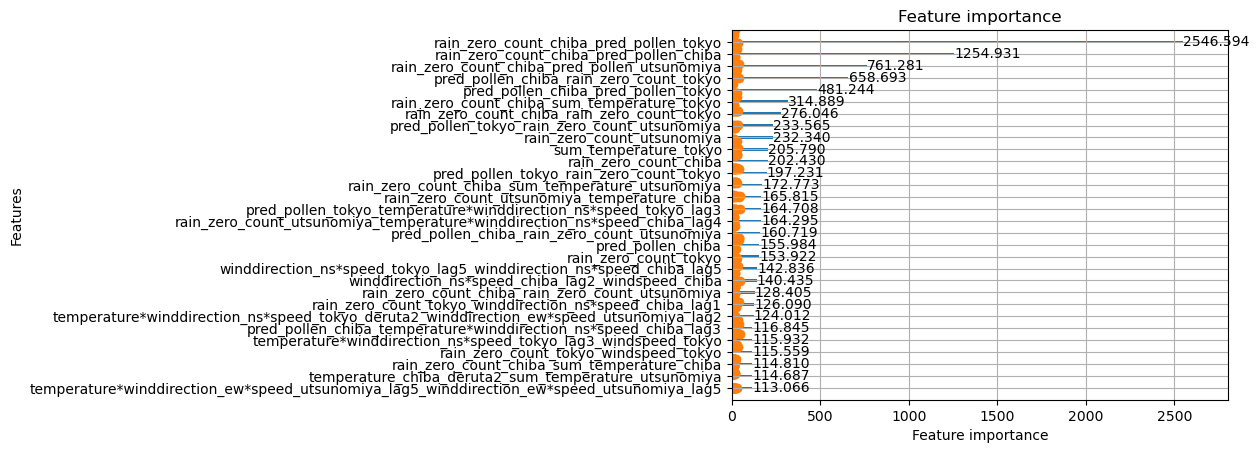

In [4021]:
lgb_chiba_100_seed1_0 = lgbm_o("chiba",df_train_test_x_c_100,df_train_test_y_c,df_test_x_c_100,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_c_0_100_seed1", seed=select_seed )

### ---1

In [4022]:
#train_travalをtrainとvalidに分割
df_traval_y_c_1 = df_train_traval_c_1[{"pollen_chiba", "pollen_chiba_cat"}]
df_traval_x_c_1 = df_train_traval_c_1.drop({"pollen_chiba" ,"pollen_chiba_cat", 
                                 "day", "month" 
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_c_1)
interaction_features = poly.get_feature_names(df_traval_x_c_1.columns)
df_traval_x_c_1 = pd.DataFrame(X_poly, columns=interaction_features)

df_traval_x_c_1_100 = df_traval_x_c_1[chiba_importance_100]

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_c_1_100, df_traval_y_c_1, test_size=0.3, random_state=select_seed)


[I 2023-01-09 21:20:35,567] A new study created in memory with name: no-name-a2479f5b-e6b6-4999-a8d2-bf21c791c585
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.402724:  14%|######4                                      | 1/7 [00:02<00:17,  2.83s/it]

Early stopping, best iteration is:
[523]	valid_0's huber: 0.00189775	valid_1's huber: 0.402724
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.402724:  29%|############8                                | 2/7 [00:08<00:23,  4.68s/it]

Early stopping, best iteration is:
[743]	valid_0's huber: 0.000118287	valid_1's huber: 0.404228
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.402724:  43%|###################2                         | 3/7 [00:14<00:20,  5.18s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 8.84057e-06	valid_1's huber: 0.403038
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.402724:  57%|#########################7                   | 4/7 [00:17<00:12,  4.28s/it]

Early stopping, best iteration is:
[253]	valid_0's huber: 0.0318147	valid_1's huber: 0.406248
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.402724:  71%|################################1            | 5/7 [00:19<00:06,  3.48s/it]

Early stopping, best iteration is:
[372]	valid_0's huber: 0.0107683	valid_1's huber: 0.405963
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.402724:  86%|######################################5      | 6/7 [00:21<00:03,  3.09s/it]

Early stopping, best iteration is:
[298]	valid_0's huber: 0.0217168	valid_1's huber: 0.403951
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.402724: 100%|#############################################| 7/7 [00:26<00:00,  3.82s/it]


Early stopping, best iteration is:
[634]	valid_0's huber: 0.000445173	valid_1's huber: 0.404491


num_leaves, val_score: 0.402724:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:   5%|##5                                               | 1/20 [00:05<01:45,  5.54s/it]

Early stopping, best iteration is:
[152]	valid_0's huber: 0.00124629	valid_1's huber: 0.413411
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  10%|#####                                             | 2/20 [00:07<01:00,  3.35s/it]

Early stopping, best iteration is:
[308]	valid_0's huber: 0.0338013	valid_1's huber: 0.403675
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  15%|#######5                                          | 3/20 [00:11<01:02,  3.70s/it]

Early stopping, best iteration is:
[154]	valid_0's huber: 0.00212667	valid_1's huber: 0.408132
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  20%|##########                                        | 4/20 [00:17<01:13,  4.59s/it]

Early stopping, best iteration is:
[163]	valid_0's huber: 0.00104896	valid_1's huber: 0.409243
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  25%|############5                                     | 5/20 [00:18<00:50,  3.36s/it]

Early stopping, best iteration is:
[673]	valid_0's huber: 0.151335	valid_1's huber: 0.419494
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  30%|###############                                   | 6/20 [00:22<00:51,  3.67s/it]

Early stopping, best iteration is:
[249]	valid_0's huber: 0.000459923	valid_1's huber: 0.413778
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  35%|#################5                                | 7/20 [00:26<00:47,  3.62s/it]

Early stopping, best iteration is:
[218]	valid_0's huber: 0.00170467	valid_1's huber: 0.404452
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  40%|####################                              | 8/20 [00:34<01:01,  5.15s/it]

Early stopping, best iteration is:
[897]	valid_0's huber: 4.5863e-06	valid_1's huber: 0.404339
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  45%|######################5                           | 9/20 [00:40<00:56,  5.17s/it]

Early stopping, best iteration is:
[227]	valid_0's huber: 0.000426618	valid_1's huber: 0.407786
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  50%|########################5                        | 10/20 [00:42<00:42,  4.22s/it]

Early stopping, best iteration is:
[143]	valid_0's huber: 0.0382402	valid_1's huber: 0.408837
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  55%|##########################9                      | 11/20 [00:50<00:49,  5.50s/it]

Early stopping, best iteration is:
[276]	valid_0's huber: 0.000154365	valid_1's huber: 0.40726
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  60%|#############################4                   | 12/20 [00:51<00:33,  4.19s/it]

Early stopping, best iteration is:
[673]	valid_0's huber: 0.151335	valid_1's huber: 0.419494
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  65%|###############################8                 | 13/20 [00:54<00:27,  3.90s/it]

Early stopping, best iteration is:
[493]	valid_0's huber: 0.00104453	valid_1's huber: 0.406387
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  70%|##################################3              | 14/20 [00:57<00:21,  3.51s/it]

Early stopping, best iteration is:
[304]	valid_0's huber: 0.00734476	valid_1's huber: 0.40855
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.402724:  75%|####################################7            | 15/20 [01:03<00:20,  4.15s/it]

Early stopping, best iteration is:
[162]	valid_0's huber: 0.00109404	valid_1's huber: 0.407331
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.401147:  80%|#######################################2         | 16/20 [01:08<00:18,  4.64s/it]

Early stopping, best iteration is:
[402]	valid_0's huber: 5.42818e-05	valid_1's huber: 0.401147
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.401147:  85%|#########################################6       | 17/20 [01:17<00:17,  5.77s/it]

Early stopping, best iteration is:
[276]	valid_0's huber: 0.000154365	valid_1's huber: 0.40726
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.401147:  90%|############################################1    | 18/20 [01:30<00:16,  8.11s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 7.07813e-07	valid_1's huber: 0.408364
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.401147:  95%|##############################################5  | 19/20 [01:39<00:08,  8.18s/it]

Early stopping, best iteration is:
[276]	valid_0's huber: 0.000154365	valid_1's huber: 0.40726
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.401147: 100%|#################################################| 20/20 [01:43<00:00,  5.17s/it]


Early stopping, best iteration is:
[113]	valid_0's huber: 0.00522972	valid_1's huber: 0.403383


bagging, val_score: 0.401147:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.401147:  10%|#####3                                               | 1/10 [00:02<00:23,  2.66s/it]

Early stopping, best iteration is:
[119]	valid_0's huber: 0.0233709	valid_1's huber: 0.409926
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.401147:  20%|##########6                                          | 2/10 [00:06<00:27,  3.43s/it]

Early stopping, best iteration is:
[230]	valid_0's huber: 0.00127147	valid_1's huber: 0.412349
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.401147:  30%|###############9                                     | 3/10 [00:09<00:23,  3.33s/it]

Early stopping, best iteration is:
[165]	valid_0's huber: 0.00568982	valid_1's huber: 0.403824
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.401147:  40%|#####################2                               | 4/10 [00:13<00:19,  3.28s/it]

Early stopping, best iteration is:
[202]	valid_0's huber: 0.00920449	valid_1's huber: 0.427218
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.401147:  50%|##########################5                          | 5/10 [00:18<00:19,  3.93s/it]

Early stopping, best iteration is:
[320]	valid_0's huber: 0.000144164	valid_1's huber: 0.405751
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.401147:  60%|###############################8                     | 6/10 [00:22<00:15,  3.94s/it]

Early stopping, best iteration is:
[228]	valid_0's huber: 0.00138214	valid_1's huber: 0.406763
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.401147:  70%|#####################################                | 7/10 [00:24<00:10,  3.49s/it]

Early stopping, best iteration is:
[103]	valid_0's huber: 0.0306327	valid_1's huber: 0.410515
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.401147:  80%|##########################################4          | 8/10 [00:28<00:06,  3.48s/it]

Early stopping, best iteration is:
[178]	valid_0's huber: 0.00413269	valid_1's huber: 0.403971
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.401147:  90%|###############################################7     | 9/10 [00:33<00:04,  4.07s/it]

Early stopping, best iteration is:
[329]	valid_0's huber: 0.000218151	valid_1's huber: 0.410392
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.401147: 100%|####################################################| 10/10 [00:36<00:00,  3.67s/it]


Early stopping, best iteration is:
[157]	valid_0's huber: 0.00725692	valid_1's huber: 0.406998


feature_fraction_stage2, val_score: 0.401147:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.401147:  17%|######3                               | 1/6 [00:05<00:25,  5.06s/it]

Early stopping, best iteration is:
[317]	valid_0's huber: 0.000135924	valid_1's huber: 0.402975
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.401147:  33%|############6                         | 2/6 [00:09<00:19,  4.80s/it]

Early stopping, best iteration is:
[251]	valid_0's huber: 0.000462149	valid_1's huber: 0.408121
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.401147:  50%|###################                   | 3/6 [00:14<00:15,  5.01s/it]

Early stopping, best iteration is:
[386]	valid_0's huber: 4.06652e-05	valid_1's huber: 0.410922
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.401147:  67%|#########################3            | 4/6 [00:22<00:11,  5.93s/it]

Early stopping, best iteration is:
[557]	valid_0's huber: 2.79415e-05	valid_1's huber: 0.402332
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.401147:  83%|###############################6      | 5/6 [00:32<00:07,  7.34s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.06619e-06	valid_1's huber: 0.407929
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.401147: 100%|######################################| 6/6 [00:35<00:00,  5.86s/it]


Early stopping, best iteration is:
[130]	valid_0's huber: 0.0123669	valid_1's huber: 0.408594


regularization_factors, val_score: 0.401147:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401147:   5%|#9                                    | 1/20 [00:04<01:29,  4.71s/it]

Early stopping, best iteration is:
[242]	valid_0's huber: 0.000731102	valid_1's huber: 0.405086
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401147:  10%|###8                                  | 2/20 [00:11<01:46,  5.92s/it]

Early stopping, best iteration is:
[431]	valid_0's huber: 4.11422e-05	valid_1's huber: 0.401717
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401147:  15%|#####7                                | 3/20 [00:15<01:25,  5.00s/it]

Early stopping, best iteration is:
[185]	valid_0's huber: 0.00259295	valid_1's huber: 0.40589
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  20%|#######6                              | 4/20 [00:20<01:21,  5.07s/it]

Early stopping, best iteration is:
[296]	valid_0's huber: 0.000210247	valid_1's huber: 0.401093
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  25%|#########5                            | 5/20 [00:27<01:25,  5.73s/it]

Early stopping, best iteration is:
[431]	valid_0's huber: 4.26211e-05	valid_1's huber: 0.401748
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  30%|###########4                          | 6/20 [00:31<01:14,  5.31s/it]

Early stopping, best iteration is:
[241]	valid_0's huber: 0.000646301	valid_1's huber: 0.401903
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  35%|#############3                        | 7/20 [00:34<00:57,  4.42s/it]

Early stopping, best iteration is:
[344]	valid_0's huber: 0.00677314	valid_1's huber: 0.412371
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  40%|###############2                      | 8/20 [00:37<00:47,  3.97s/it]

Early stopping, best iteration is:
[331]	valid_0's huber: 0.00233113	valid_1's huber: 0.406718
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  45%|#################1                    | 9/20 [00:44<00:52,  4.79s/it]

Early stopping, best iteration is:
[310]	valid_0's huber: 0.000171303	valid_1's huber: 0.401229
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  50%|##################5                  | 10/20 [00:47<00:42,  4.26s/it]

Early stopping, best iteration is:
[138]	valid_0's huber: 0.0235227	valid_1's huber: 0.407159
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  55%|####################3                | 11/20 [00:52<00:40,  4.46s/it]

Early stopping, best iteration is:
[212]	valid_0's huber: 0.00237621	valid_1's huber: 0.406759
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  60%|######################2              | 12/20 [00:58<00:40,  5.08s/it]

Early stopping, best iteration is:
[349]	valid_0's huber: 9.94388e-05	valid_1's huber: 0.401171
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  65%|########################             | 13/20 [01:05<00:39,  5.62s/it]

Early stopping, best iteration is:
[369]	valid_0's huber: 7.77309e-05	valid_1's huber: 0.401152
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  70%|#########################9           | 14/20 [01:12<00:36,  6.03s/it]

Early stopping, best iteration is:
[369]	valid_0's huber: 7.77309e-05	valid_1's huber: 0.401152
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  75%|###########################7         | 15/20 [01:18<00:30,  6.03s/it]

Early stopping, best iteration is:
[349]	valid_0's huber: 9.94382e-05	valid_1's huber: 0.401171
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  80%|#############################6       | 16/20 [01:23<00:22,  5.72s/it]

Early stopping, best iteration is:
[237]	valid_0's huber: 0.000602644	valid_1's huber: 0.40762
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  85%|###############################4     | 17/20 [01:27<00:15,  5.33s/it]

Early stopping, best iteration is:
[206]	valid_0's huber: 0.00136093	valid_1's huber: 0.40706
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  90%|#################################3   | 18/20 [01:34<00:11,  5.56s/it]

Early stopping, best iteration is:
[349]	valid_0's huber: 9.9438e-05	valid_1's huber: 0.401171
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093:  95%|###################################1 | 19/20 [01:39<00:05,  5.43s/it]

Early stopping, best iteration is:
[266]	valid_0's huber: 0.000363212	valid_1's huber: 0.40408
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.401093: 100%|#####################################| 20/20 [01:46<00:00,  5.32s/it]


Early stopping, best iteration is:
[402]	valid_0's huber: 5.42818e-05	valid_1's huber: 0.401147


min_data_in_leaf, val_score: 0.401093:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.401093:  20%|#########                                    | 1/5 [00:03<00:11,  2.99s/it]

Early stopping, best iteration is:
[173]	valid_0's huber: 0.0157795	valid_1's huber: 0.40385
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.401093:  40%|##################                           | 2/5 [00:08<00:13,  4.62s/it]

Early stopping, best iteration is:
[228]	valid_0's huber: 0.000496726	valid_1's huber: 0.405513
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.401093:  60%|###########################                  | 3/5 [00:16<00:11,  5.88s/it]

Early stopping, best iteration is:
[367]	valid_0's huber: 9.03512e-06	valid_1's huber: 0.415208
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.401093:  80%|####################################         | 4/5 [00:22<00:06,  6.10s/it]

Early stopping, best iteration is:
[406]	valid_0's huber: 0.000111109	valid_1's huber: 0.407489
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.401093: 100%|#############################################| 5/5 [00:24<00:00,  4.87s/it]

Early stopping, best iteration is:
[227]	valid_0's huber: 0.0576957	valid_1's huber: 0.411692
Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 3, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 9.597807546530958e-07, 'lambda_l2': 3.324849802435494e-07, 'num_leaves': 79, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 10.170799139756312


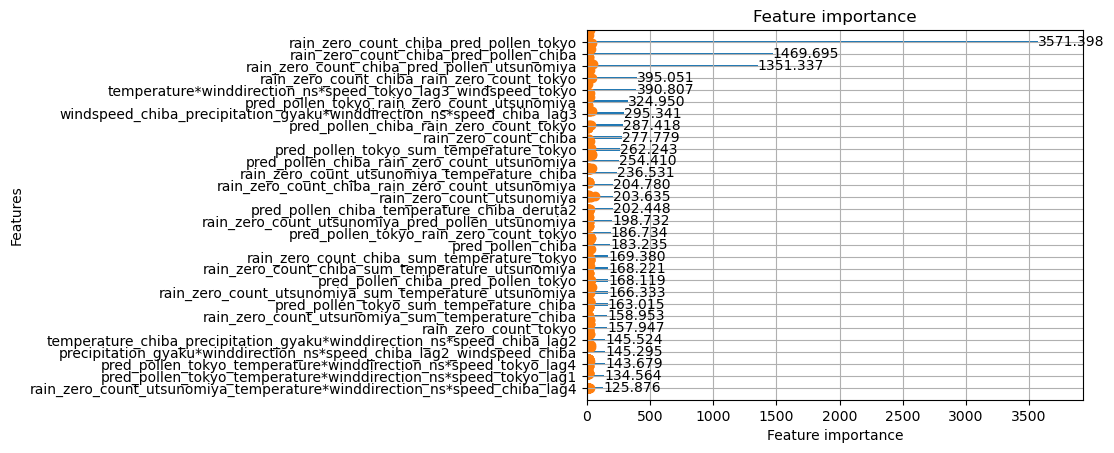

In [4023]:
lgb_chiba_100_seed1_1 = lgbm_o("chiba",df_train_test_x_c_100,df_train_test_y_c,df_test_x_c_100,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_c_1_100_seed1", seed=select_seed )

### ---2

In [4024]:
#train_travalをtrainとvalidに分割
df_traval_y_c_2 = df_train_traval_c_2[{"pollen_chiba", "pollen_chiba_cat"}]
df_traval_x_c_2 = df_train_traval_c_2.drop({"pollen_chiba" ,"pollen_chiba_cat", 
                                 "day", "month" 
                                }, axis=1)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_c_2)
interaction_features = poly.get_feature_names(df_traval_x_c_2.columns)
df_traval_x_c_2 = pd.DataFrame(X_poly, columns=interaction_features)

df_traval_x_c_2_100 = df_traval_x_c_2[chiba_importance_100]

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_c_2_100, df_traval_y_c_2, test_size=0.3, random_state=select_seed)

[I 2023-01-09 21:26:09,243] A new study created in memory with name: no-name-db9e0bc7-86c7-4ed3-9531-0b8c76931490
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.288740:  14%|######4                                      | 1/7 [00:09<00:58,  9.72s/it]

Early stopping, best iteration is:
[899]	valid_0's huber: 0.000582239	valid_1's huber: 0.28874
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.288740:  29%|############8                                | 2/7 [00:15<00:38,  7.62s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000422961	valid_1's huber: 0.290998
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.288740:  43%|###################2                         | 3/7 [00:25<00:34,  8.60s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000281254	valid_1's huber: 0.291424
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.286350:  57%|#########################7                   | 4/7 [00:31<00:23,  7.68s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000511672	valid_1's huber: 0.28635
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.286350:  71%|################################1            | 5/7 [00:38<00:14,  7.13s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000354488	valid_1's huber: 0.291914
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.286350:  86%|######################################5      | 6/7 [00:45<00:07,  7.31s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000300821	valid_1's huber: 0.289108
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.286350: 100%|#############################################| 7/7 [00:52<00:00,  7.52s/it]


Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000321882	valid_1's huber: 0.288285


num_leaves, val_score: 0.286350:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:   5%|##5                                               | 1/20 [00:05<01:37,  5.13s/it]

Early stopping, best iteration is:
[683]	valid_0's huber: 0.00041962	valid_1's huber: 0.290535
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  10%|#####                                             | 2/20 [00:08<01:14,  4.13s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00726938	valid_1's huber: 0.294277
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  15%|#######5                                          | 3/20 [00:11<01:03,  3.73s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00939239	valid_1's huber: 0.297583
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  20%|##########                                        | 4/20 [00:19<01:22,  5.15s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 7.37006e-06	valid_1's huber: 0.286967
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  25%|############5                                     | 5/20 [00:27<01:35,  6.40s/it]

Early stopping, best iteration is:
[272]	valid_0's huber: 0.000307753	valid_1's huber: 0.2888
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  30%|###############                                   | 6/20 [00:34<01:32,  6.63s/it]

Early stopping, best iteration is:
[380]	valid_0's huber: 0.000119383	valid_1's huber: 0.287391
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  35%|#################5                                | 7/20 [00:45<01:42,  7.85s/it]

Early stopping, best iteration is:
[257]	valid_0's huber: 0.000278064	valid_1's huber: 0.292008
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  40%|####################                              | 8/20 [00:53<01:34,  7.85s/it]

Early stopping, best iteration is:
[300]	valid_0's huber: 0.00023459	valid_1's huber: 0.288164
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  45%|######################5                           | 9/20 [01:04<01:37,  8.82s/it]

Early stopping, best iteration is:
[234]	valid_0's huber: 0.000366348	valid_1's huber: 0.293867
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  50%|########################5                        | 10/20 [01:12<01:28,  8.85s/it]

Early stopping, best iteration is:
[499]	valid_0's huber: 4.83546e-05	valid_1's huber: 0.288885
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  55%|##########################9                      | 11/20 [01:21<01:19,  8.81s/it]

Early stopping, best iteration is:
[740]	valid_0's huber: 9.88155e-06	valid_1's huber: 0.290169
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  60%|#############################4                   | 12/20 [01:29<01:07,  8.49s/it]

Early stopping, best iteration is:
[536]	valid_0's huber: 2.31766e-05	valid_1's huber: 0.288312
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  65%|###############################8                 | 13/20 [01:35<00:54,  7.85s/it]

Early stopping, best iteration is:
[584]	valid_0's huber: 0.000105843	valid_1's huber: 0.287278
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  70%|##################################3              | 14/20 [01:42<00:44,  7.50s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.13832e-05	valid_1's huber: 0.287458
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.286350:  75%|####################################7            | 15/20 [01:44<00:28,  5.70s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.212564	valid_1's huber: 0.348167
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.284912:  80%|#######################################2         | 16/20 [01:51<00:25,  6.26s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.25657e-06	valid_1's huber: 0.284912
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.284912:  85%|#########################################6       | 17/20 [01:58<00:19,  6.57s/it]

Early stopping, best iteration is:
[252]	valid_0's huber: 0.000378709	valid_1's huber: 0.289818
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.284912:  90%|############################################1    | 18/20 [02:04<00:12,  6.32s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.00912e-05	valid_1's huber: 0.288643
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.284912:  95%|##############################################5  | 19/20 [02:11<00:06,  6.57s/it]

Early stopping, best iteration is:
[437]	valid_0's huber: 7.50575e-05	valid_1's huber: 0.29248
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.284912: 100%|#################################################| 20/20 [02:20<00:00,  7.04s/it]


Early stopping, best iteration is:
[803]	valid_0's huber: 4.29324e-06	valid_1's huber: 0.286336


bagging, val_score: 0.284912:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.284912:  10%|#####3                                               | 1/10 [00:05<00:49,  5.52s/it]

Early stopping, best iteration is:
[597]	valid_0's huber: 0.000901102	valid_1's huber: 0.304591
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.284912:  20%|##########6                                          | 2/10 [00:11<00:46,  5.79s/it]

Early stopping, best iteration is:
[647]	valid_0's huber: 0.000188227	valid_1's huber: 0.291006
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.284912:  30%|###############9                                     | 3/10 [00:19<00:47,  6.80s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.98565e-06	valid_1's huber: 0.295261
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.284912:  40%|#####################2                               | 4/10 [00:26<00:41,  6.96s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.61681e-06	valid_1's huber: 0.288565
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.284912:  50%|##########################5                          | 5/10 [00:34<00:36,  7.33s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.00149e-06	valid_1's huber: 0.292876
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.284912:  60%|###############################8                     | 6/10 [00:41<00:28,  7.19s/it]

Early stopping, best iteration is:
[854]	valid_0's huber: 2.71636e-05	valid_1's huber: 0.295725
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.284912:  70%|#####################################                | 7/10 [00:47<00:20,  6.92s/it]

Early stopping, best iteration is:
[711]	valid_0's huber: 8.23194e-05	valid_1's huber: 0.290134
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.284912:  80%|##########################################4          | 8/10 [00:53<00:12,  6.43s/it]

Early stopping, best iteration is:
[569]	valid_0's huber: 0.000510334	valid_1's huber: 0.295005
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.282781:  90%|###############################################7     | 9/10 [00:59<00:06,  6.38s/it]

Early stopping, best iteration is:
[802]	valid_0's huber: 2.98158e-05	valid_1's huber: 0.282781
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.282781: 100%|####################################################| 10/10 [01:05<00:00,  6.55s/it]


Early stopping, best iteration is:
[729]	valid_0's huber: 7.78513e-05	valid_1's huber: 0.28858


feature_fraction_stage2, val_score: 0.282781:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.282781:  33%|############6                         | 1/3 [00:07<00:14,  7.20s/it]

Early stopping, best iteration is:
[821]	valid_0's huber: 1.91965e-05	valid_1's huber: 0.286469
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.282781:  67%|#########################3            | 2/3 [00:14<00:07,  7.03s/it]

Early stopping, best iteration is:
[856]	valid_0's huber: 1.49191e-05	valid_1's huber: 0.287003
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.282781: 100%|######################################| 3/3 [00:21<00:00,  7.01s/it]


Early stopping, best iteration is:
[818]	valid_0's huber: 2.19638e-05	valid_1's huber: 0.285826


regularization_factors, val_score: 0.282781:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:   5%|#9                                    | 1/20 [00:07<02:25,  7.64s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.13241e-06	valid_1's huber: 0.282771
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  10%|###8                                  | 2/20 [00:13<01:58,  6.56s/it]

Did not meet early stopping. Best iteration is:
[970]	valid_0's huber: 0.000577184	valid_1's huber: 0.289112
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  15%|#####7                                | 3/20 [00:20<01:53,  6.68s/it]

Early stopping, best iteration is:
[770]	valid_0's huber: 4.37909e-05	valid_1's huber: 0.286633
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  20%|#######6                              | 4/20 [00:25<01:40,  6.28s/it]

Early stopping, best iteration is:
[860]	valid_0's huber: 0.000427971	valid_1's huber: 0.288572
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  25%|#########5                            | 5/20 [00:34<01:44,  6.94s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.65854e-05	valid_1's huber: 0.286834
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  30%|###########4                          | 6/20 [00:41<01:40,  7.17s/it]

Early stopping, best iteration is:
[858]	valid_0's huber: 1.56977e-05	valid_1's huber: 0.283854
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  35%|#############3                        | 7/20 [00:48<01:32,  7.15s/it]

Early stopping, best iteration is:
[780]	valid_0's huber: 3.72108e-05	valid_1's huber: 0.288841
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  40%|###############2                      | 8/20 [00:54<01:21,  6.83s/it]

Early stopping, best iteration is:
[688]	valid_0's huber: 0.000112359	valid_1's huber: 0.282828
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  45%|#################1                    | 9/20 [01:01<01:13,  6.67s/it]

Early stopping, best iteration is:
[693]	valid_0's huber: 0.000106163	valid_1's huber: 0.285058
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  50%|##################5                  | 10/20 [01:07<01:05,  6.50s/it]

Early stopping, best iteration is:
[688]	valid_0's huber: 0.000112359	valid_1's huber: 0.282828
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  55%|####################3                | 11/20 [01:14<00:59,  6.65s/it]

Early stopping, best iteration is:
[802]	valid_0's huber: 2.98158e-05	valid_1's huber: 0.282781
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  60%|######################2              | 12/20 [01:21<00:53,  6.74s/it]

Early stopping, best iteration is:
[802]	valid_0's huber: 2.98158e-05	valid_1's huber: 0.282781
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  65%|########################             | 13/20 [01:28<00:47,  6.80s/it]

Early stopping, best iteration is:
[802]	valid_0's huber: 2.98158e-05	valid_1's huber: 0.282781
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  70%|#########################9           | 14/20 [01:34<00:39,  6.63s/it]

Early stopping, best iteration is:
[696]	valid_0's huber: 0.000100033	valid_1's huber: 0.287751
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  75%|###########################7         | 15/20 [01:42<00:34,  6.96s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.11993e-06	valid_1's huber: 0.285162
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282771:  80%|#############################6       | 16/20 [01:49<00:27,  6.96s/it]

Early stopping, best iteration is:
[802]	valid_0's huber: 2.98161e-05	valid_1's huber: 0.282781
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282769:  85%|###############################4     | 17/20 [01:57<00:21,  7.31s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 3.12926e-06	valid_1's huber: 0.282769
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282164:  90%|#################################3   | 18/20 [02:04<00:14,  7.37s/it]

Early stopping, best iteration is:
[864]	valid_0's huber: 1.4586e-05	valid_1's huber: 0.282164
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282164:  95%|###################################1 | 19/20 [02:11<00:07,  7.25s/it]

Early stopping, best iteration is:
[775]	valid_0's huber: 4.094e-05	valid_1's huber: 0.283844
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.282164: 100%|#####################################| 20/20 [02:18<00:00,  6.93s/it]


Early stopping, best iteration is:
[774]	valid_0's huber: 4.13865e-05	valid_1's huber: 0.285101


min_data_in_leaf, val_score: 0.282164:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.282164:  20%|#########                                    | 1/5 [00:06<00:26,  6.68s/it]

Early stopping, best iteration is:
[767]	valid_0's huber: 0.00014508	valid_1's huber: 0.290196
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.282164:  40%|##################                           | 2/5 [00:13<00:20,  6.71s/it]

Early stopping, best iteration is:
[680]	valid_0's huber: 9.19074e-05	valid_1's huber: 0.284851
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.282164:  60%|###########################                  | 3/5 [00:19<00:13,  6.62s/it]

Early stopping, best iteration is:
[723]	valid_0's huber: 9.60783e-05	valid_1's huber: 0.28916
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.282164:  80%|####################################         | 4/5 [00:26<00:06,  6.65s/it]

Early stopping, best iteration is:
[647]	valid_0's huber: 0.000126327	valid_1's huber: 0.286818
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.282164: 100%|#############################################| 5/5 [00:33<00:00,  6.71s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000217487	valid_1's huber: 0.295742
Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 3, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.00011326849141557422, 'lambda_l2': 3.902491457413579e-06, 'num_leaves': 52, 'feature_fraction': 0.4, 'bagging_fraction': 0.9676056670606984, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}


MAE 10.114356422163958


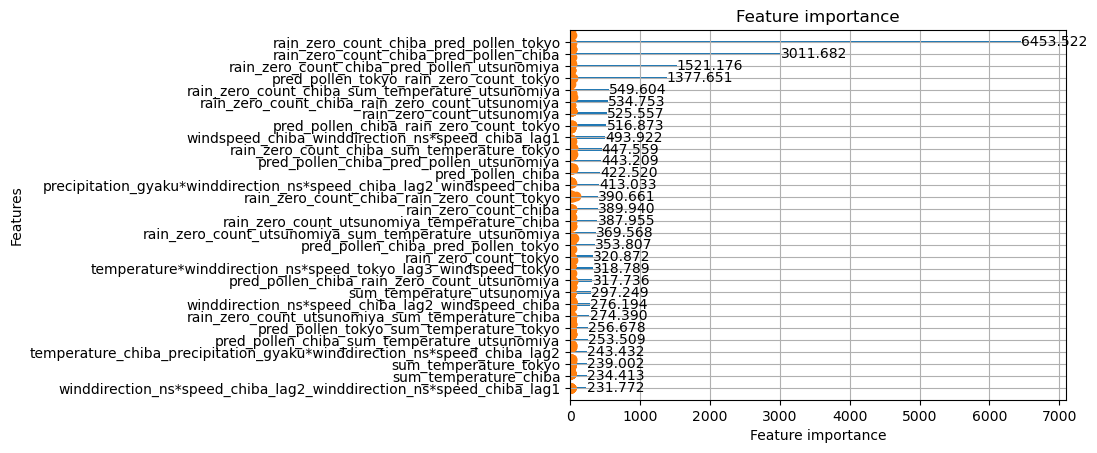

In [4025]:
lgb_chiba_100_seed1_2 = lgbm_o("chiba",df_train_test_x_c_100,df_train_test_y_c,df_test_x_c_100,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_c_2_100_seed1", seed=select_seed )

### ---Ave.

MAE
lgbm 9.993531861219171


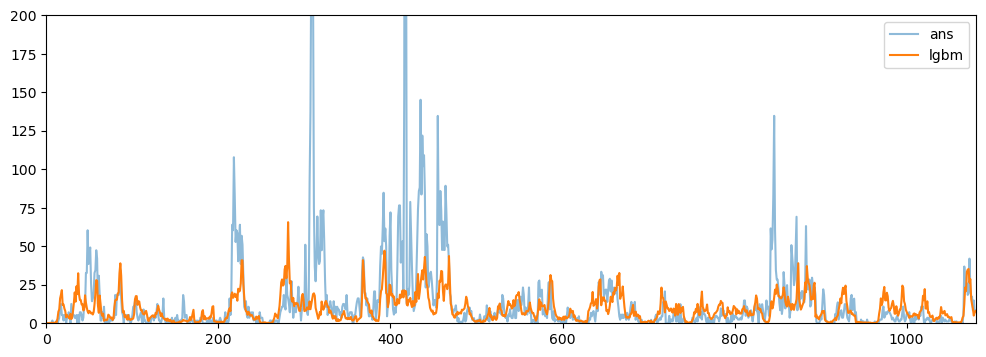

In [4026]:
r = 1

df_pred["pollen_"+region_list[r]+"_lgbm_100_seed1"] = (df_pred["pollen_"+region_list[r]+"_lgbm_c_0_100_seed1"]+df_pred["pollen_"+region_list[r]+"_lgbm_c_1_100_seed1"]+df_pred["pollen_"+region_list[r]+"_lgbm_c_2_100_seed1"])/3

plt.figure(figsize=(12,4))
plt.plot(np.array(df_train_test_y_c["pollen_"+region_list[r]]), alpha=0.5, label="ans")
plt.plot(df_pred["pollen_"+region_list[r]+"_lgbm_100_seed1"], label="lgbm")
plt.legend()
plt.xlim(0,len(df_pred))
plt.ylim(0,200)

print("MAE")
print("lgbm",mean_absolute_error(df_pred["pollen_"+region_list[r]+"_lgbm_100_seed1"], np.array(df_train_test_y_c["pollen_"+region_list[r]])))

In [4027]:
#sub
r = 1

### lgbm
df_submission["pollen_"+region_list[r]] = (df_sub["pollen_"+region_list[r]+"_lgbm_c_0_100_seed1"]+df_sub["pollen_"+region_list[r]+"_lgbm_c_1_100_seed1"]+df_sub["pollen_"+region_list[r]+"_lgbm_c_2_100_seed1"])/3


#4の倍数にそろえる
#for i in range(1000):
#    df_submission["pollen_chiba"][(df_submission["pollen_chiba"] > i*4-2) & (df_submission["pollen_chiba"] <= i*4+2)] = i*4

## tokyo

In [4029]:
tokyo_importance = lgb_tokyo_0[0] + lgb_tokyo_1[0] + lgb_tokyo_2[0]
tokyo_importance = tokyo_importance.sort_values(by="importance", ascending=False)
tokyo_importance_100 = tokyo_importance.index[0:feature_number_t]

In [4030]:
# 閾値3以下を分割(Statified k-fold)
X = df_train_traval_t_under.copy()
y= df_train_traval_t_under["pollen_tokyo_cat"]
skf = StratifiedKFold(n_splits=3, random_state=select_seed, shuffle=True)
skf.get_n_splits(X, y)

df_train_idx = pd.DataFrame()
df_valid_idx = pd.DataFrame()

print(skf)
for i, (train_index) in enumerate(skf.split(X, y)):
    df_train_idx[i] = train_index

StratifiedKFold(n_splits=3, random_state=3, shuffle=True)


In [4031]:
df_train_traval_t_0 = df_train_traval_t_under.loc[df_train_idx[0][1].tolist()]
df_train_traval_t_1 = df_train_traval_t_under.loc[df_train_idx[1][1].tolist()]
df_train_traval_t_2 = df_train_traval_t_under.loc[df_train_idx[2][1].tolist()]

df_train_traval_t_0 =pd.concat([df_train_traval_t_0, df_train_traval_t_1, df_train_traval_t_over], axis = 0)
df_train_traval_t_1 =pd.concat([df_train_traval_t_1, df_train_traval_t_2, df_train_traval_t_over], axis = 0)
df_train_traval_t_2 =pd.concat([df_train_traval_t_2, df_train_traval_t_0, df_train_traval_t_over], axis = 0)

### ---0

In [4032]:
#train_travalをtrainとvalidに分割
df_traval_y_t_0 = df_train_traval_t_0[{"pollen_tokyo", "pollen_tokyo_cat"}]
df_traval_x_t_0 = df_train_traval_t_0.drop({"pollen_tokyo" ,"pollen_tokyo_cat", 
                                 "day", "month" 
                                }, axis=1)

df_test_x_t = df_test_lgbm_t.drop({"pollen_tokyo",
                                 "day", "month",
                                }, axis=1)
df_train_test_y_t = df_train_test_t[{"pollen_tokyo", "pollen_tokyo_cat"}]
df_train_test_x_t = df_train_test_t.drop({"pollen_tokyo", "pollen_tokyo_cat",
                                 "day", "month",
                                }, axis=1)

#交互作用作成
from sklearn.preprocessing import PolynomialFeatures

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_t_0)
interaction_features = poly.get_feature_names(df_traval_x_t_0.columns)
df_traval_x_t_0 = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_test_x_t)
interaction_features = poly.get_feature_names(df_test_x_t.columns)
df_test_x_t = pd.DataFrame(X_poly, columns=interaction_features)

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_train_test_x_t)
interaction_features = poly.get_feature_names(df_train_test_x_t.columns)
df_train_test_x_t = pd.DataFrame(X_poly, columns=interaction_features)

df_traval_x_t_0_100 = df_traval_x_t_0[tokyo_importance_100]
df_test_x_t_100 = df_test_x_t[tokyo_importance_100]
df_train_test_x_t_100 = df_train_test_x_t[tokyo_importance_100]

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_t_0_100, df_traval_y_t_0, test_size=0.3, random_state=select_seed)

[I 2023-01-09 21:33:42,809] A new study created in memory with name: no-name-9fc60c35-143d-4408-a2f8-977a5a975868
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.425008:  14%|######4                                      | 1/7 [00:04<00:28,  4.69s/it]

Early stopping, best iteration is:
[510]	valid_0's huber: 0.00200282	valid_1's huber: 0.425008
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.425008:  29%|############8                                | 2/7 [00:07<00:17,  3.51s/it]

Early stopping, best iteration is:
[246]	valid_0's huber: 0.0413483	valid_1's huber: 0.426435
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.425008:  43%|###################2                         | 3/7 [00:09<00:11,  2.82s/it]

Early stopping, best iteration is:
[361]	valid_0's huber: 0.0168592	valid_1's huber: 0.435409
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.425008:  57%|#########################7                   | 4/7 [00:12<00:09,  3.06s/it]

Early stopping, best iteration is:
[388]	valid_0's huber: 0.0089023	valid_1's huber: 0.427052
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.425008:  71%|################################1            | 5/7 [00:15<00:05,  2.96s/it]

Early stopping, best iteration is:
[386]	valid_0's huber: 0.0108978	valid_1's huber: 0.427169
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.425008:  86%|######################################5      | 6/7 [00:18<00:02,  2.82s/it]

Early stopping, best iteration is:
[288]	valid_0's huber: 0.0290126	valid_1's huber: 0.430249
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.425008: 100%|#############################################| 7/7 [00:20<00:00,  2.92s/it]


Early stopping, best iteration is:
[345]	valid_0's huber: 0.0171409	valid_1's huber: 0.428494


num_leaves, val_score: 0.425008:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:   5%|##5                                               | 1/20 [00:08<02:33,  8.10s/it]

Early stopping, best iteration is:
[370]	valid_0's huber: 0.000212585	valid_1's huber: 0.431985
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  10%|#####                                             | 2/20 [00:14<02:02,  6.82s/it]

Early stopping, best iteration is:
[199]	valid_0's huber: 0.00274909	valid_1's huber: 0.436496
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  15%|#######5                                          | 3/20 [00:17<01:29,  5.24s/it]

Early stopping, best iteration is:
[469]	valid_0's huber: 0.0152941	valid_1's huber: 0.430107
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  20%|##########                                        | 4/20 [00:21<01:14,  4.67s/it]

Early stopping, best iteration is:
[279]	valid_0's huber: 0.0129535	valid_1's huber: 0.428296
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  25%|############5                                     | 5/20 [00:27<01:18,  5.22s/it]

Early stopping, best iteration is:
[139]	valid_0's huber: 0.00453166	valid_1's huber: 0.443792
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  30%|###############                                   | 6/20 [00:39<01:44,  7.43s/it]

Early stopping, best iteration is:
[187]	valid_0's huber: 0.00121609	valid_1's huber: 0.442334
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  35%|#################5                                | 7/20 [00:51<01:56,  8.95s/it]

Early stopping, best iteration is:
[187]	valid_0's huber: 0.00121609	valid_1's huber: 0.442334
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  40%|####################                              | 8/20 [01:01<01:53,  9.44s/it]

Early stopping, best iteration is:
[144]	valid_0's huber: 0.00258768	valid_1's huber: 0.447766
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  45%|######################5                           | 9/20 [01:09<01:39,  9.00s/it]

Early stopping, best iteration is:
[323]	valid_0's huber: 0.000394041	valid_1's huber: 0.43407
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  50%|########################5                        | 10/20 [01:12<01:11,  7.17s/it]

Early stopping, best iteration is:
[471]	valid_0's huber: 0.0623651	valid_1's huber: 0.432832
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  55%|##########################9                      | 11/20 [01:23<01:15,  8.37s/it]

Early stopping, best iteration is:
[144]	valid_0's huber: 0.00258768	valid_1's huber: 0.447766
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  60%|#############################4                   | 12/20 [01:27<00:54,  6.83s/it]

Early stopping, best iteration is:
[533]	valid_0's huber: 0.0378532	valid_1's huber: 0.428967
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  65%|###############################8                 | 13/20 [01:28<00:35,  5.02s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.437472	valid_1's huber: 0.507305
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  70%|##################################3              | 14/20 [01:35<00:33,  5.62s/it]

Early stopping, best iteration is:
[331]	valid_0's huber: 0.00101134	valid_1's huber: 0.425744
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  75%|####################################7            | 15/20 [01:42<00:30,  6.18s/it]

Early stopping, best iteration is:
[152]	valid_0's huber: 0.00270349	valid_1's huber: 0.440893
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  80%|#######################################2         | 16/20 [01:46<00:21,  5.45s/it]

Early stopping, best iteration is:
[207]	valid_0's huber: 0.0232144	valid_1's huber: 0.4333
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  85%|#########################################6       | 17/20 [01:54<00:19,  6.39s/it]

Early stopping, best iteration is:
[203]	valid_0's huber: 0.00139365	valid_1's huber: 0.438758
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  90%|############################################1    | 18/20 [02:04<00:14,  7.39s/it]

Early stopping, best iteration is:
[151]	valid_0's huber: 0.00218487	valid_1's huber: 0.441311
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008:  95%|##############################################5  | 19/20 [02:15<00:08,  8.38s/it]

Early stopping, best iteration is:
[144]	valid_0's huber: 0.00258768	valid_1's huber: 0.447766
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.425008: 100%|#################################################| 20/20 [02:18<00:00,  6.91s/it]


Early stopping, best iteration is:
[168]	valid_0's huber: 0.0540602	valid_1's huber: 0.427846


bagging, val_score: 0.425008:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.425008:  10%|#####3                                               | 1/10 [00:03<00:34,  3.78s/it]

Early stopping, best iteration is:
[351]	valid_0's huber: 0.011303	valid_1's huber: 0.436445
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.425008:  20%|##########6                                          | 2/10 [00:08<00:33,  4.16s/it]

Early stopping, best iteration is:
[428]	valid_0's huber: 0.00478071	valid_1's huber: 0.433358
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.425008:  30%|###############9                                     | 3/10 [00:14<00:37,  5.30s/it]

Early stopping, best iteration is:
[738]	valid_0's huber: 0.000220138	valid_1's huber: 0.431297
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.425008:  40%|#####################2                               | 4/10 [00:18<00:27,  4.54s/it]

Early stopping, best iteration is:
[297]	valid_0's huber: 0.021968	valid_1's huber: 0.433249
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.425008:  50%|##########################5                          | 5/10 [00:21<00:21,  4.24s/it]

Early stopping, best iteration is:
[343]	valid_0's huber: 0.0152554	valid_1's huber: 0.449156
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.425008:  60%|###############################8                     | 6/10 [00:24<00:14,  3.59s/it]

Early stopping, best iteration is:
[168]	valid_0's huber: 0.110011	valid_1's huber: 0.464304
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.425008:  70%|#####################################                | 7/10 [00:27<00:09,  3.33s/it]

Early stopping, best iteration is:
[220]	valid_0's huber: 0.0602042	valid_1's huber: 0.458312
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.425008:  80%|##########################################4          | 8/10 [00:34<00:09,  4.61s/it]

Early stopping, best iteration is:
[826]	valid_0's huber: 9.31469e-05	valid_1's huber: 0.434619
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.425008:  90%|###############################################7     | 9/10 [00:37<00:04,  4.19s/it]

Early stopping, best iteration is:
[284]	valid_0's huber: 0.0245234	valid_1's huber: 0.431835
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.425008: 100%|####################################################| 10/10 [00:40<00:00,  4.10s/it]


Early stopping, best iteration is:
[282]	valid_0's huber: 0.0296427	valid_1's huber: 0.44407


feature_fraction_stage2, val_score: 0.425008:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.425008:  33%|############6                         | 1/3 [00:04<00:08,  4.16s/it]

Early stopping, best iteration is:
[449]	valid_0's huber: 0.00421357	valid_1's huber: 0.430833
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.425008:  67%|#########################3            | 2/3 [00:07<00:03,  3.84s/it]

Early stopping, best iteration is:
[361]	valid_0's huber: 0.0117897	valid_1's huber: 0.42936
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.425008: 100%|######################################| 3/3 [00:11<00:00,  3.97s/it]


Early stopping, best iteration is:
[398]	valid_0's huber: 0.00773946	valid_1's huber: 0.427422


regularization_factors, val_score: 0.425008:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:   5%|#9                                    | 1/20 [00:04<01:32,  4.87s/it]

Early stopping, best iteration is:
[340]	valid_0's huber: 0.0142937	valid_1's huber: 0.426338
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  10%|###8                                  | 2/20 [00:08<01:13,  4.08s/it]

Early stopping, best iteration is:
[274]	valid_0's huber: 0.0298972	valid_1's huber: 0.425224
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  15%|#####7                                | 3/20 [00:11<01:04,  3.78s/it]

Early stopping, best iteration is:
[232]	valid_0's huber: 0.0479596	valid_1's huber: 0.429488
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  20%|#######6                              | 4/20 [00:16<01:09,  4.32s/it]

Early stopping, best iteration is:
[457]	valid_0's huber: 0.0040594	valid_1's huber: 0.437024
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  25%|#########5                            | 5/20 [00:21<01:03,  4.23s/it]

Early stopping, best iteration is:
[333]	valid_0's huber: 0.0149651	valid_1's huber: 0.426164
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  30%|###########4                          | 6/20 [00:24<00:54,  3.93s/it]

Early stopping, best iteration is:
[247]	valid_0's huber: 0.0401626	valid_1's huber: 0.425827
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  35%|#############3                        | 7/20 [00:27<00:48,  3.76s/it]

Early stopping, best iteration is:
[258]	valid_0's huber: 0.0343682	valid_1's huber: 0.426045
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  40%|###############2                      | 8/20 [00:32<00:49,  4.13s/it]

Early stopping, best iteration is:
[405]	valid_0's huber: 0.00719294	valid_1's huber: 0.42591
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  45%|#################1                    | 9/20 [00:36<00:43,  3.94s/it]

Early stopping, best iteration is:
[269]	valid_0's huber: 0.0501941	valid_1's huber: 0.437794
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  50%|##################5                  | 10/20 [00:40<00:41,  4.11s/it]

Early stopping, best iteration is:
[359]	valid_0's huber: 0.0115953	valid_1's huber: 0.425025
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  55%|####################3                | 11/20 [00:46<00:41,  4.57s/it]

Early stopping, best iteration is:
[510]	valid_0's huber: 0.00200282	valid_1's huber: 0.425008
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  60%|######################2              | 12/20 [00:51<00:38,  4.84s/it]

Early stopping, best iteration is:
[510]	valid_0's huber: 0.00200282	valid_1's huber: 0.425008
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  65%|########################             | 13/20 [00:57<00:35,  5.04s/it]

Early stopping, best iteration is:
[510]	valid_0's huber: 0.00200282	valid_1's huber: 0.425008
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  70%|#########################9           | 14/20 [01:02<00:31,  5.17s/it]

Early stopping, best iteration is:
[510]	valid_0's huber: 0.00200282	valid_1's huber: 0.425008
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  75%|###########################7         | 15/20 [01:08<00:26,  5.27s/it]

Early stopping, best iteration is:
[510]	valid_0's huber: 0.00200282	valid_1's huber: 0.425008
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  80%|#############################6       | 16/20 [01:13<00:21,  5.36s/it]

Early stopping, best iteration is:
[510]	valid_0's huber: 0.00200282	valid_1's huber: 0.425008
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  85%|###############################4     | 17/20 [01:19<00:16,  5.39s/it]

Early stopping, best iteration is:
[510]	valid_0's huber: 0.00200282	valid_1's huber: 0.425008
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  90%|#################################3   | 18/20 [01:24<00:10,  5.42s/it]

Early stopping, best iteration is:
[510]	valid_0's huber: 0.00200282	valid_1's huber: 0.425008
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008:  95%|###################################1 | 19/20 [01:29<00:05,  5.08s/it]

Early stopping, best iteration is:
[345]	valid_0's huber: 0.0133808	valid_1's huber: 0.429575
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425008: 100%|#####################################| 20/20 [01:34<00:00,  4.73s/it]


Early stopping, best iteration is:
[510]	valid_0's huber: 0.00200282	valid_1's huber: 0.425008


min_data_in_leaf, val_score: 0.425008:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.425008:  20%|#########                                    | 1/5 [00:03<00:14,  3.62s/it]

Early stopping, best iteration is:
[380]	valid_0's huber: 0.0127956	valid_1's huber: 0.436956
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.425008:  40%|##################                           | 2/5 [00:06<00:10,  3.39s/it]

Early stopping, best iteration is:
[300]	valid_0's huber: 0.0228667	valid_1's huber: 0.428705
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.425008:  60%|###########################                  | 3/5 [00:10<00:07,  3.69s/it]

Early stopping, best iteration is:
[375]	valid_0's huber: 0.00830946	valid_1's huber: 0.429393
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.425008:  80%|####################################         | 4/5 [00:13<00:03,  3.34s/it]

Early stopping, best iteration is:
[280]	valid_0's huber: 0.0432464	valid_1's huber: 0.441344
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.425008: 100%|#############################################| 5/5 [00:19<00:00,  3.87s/it]

Early stopping, best iteration is:
[542]	valid_0's huber: 0.00103461	valid_1's huber: 0.426422
Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 3, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 8.989267999828902


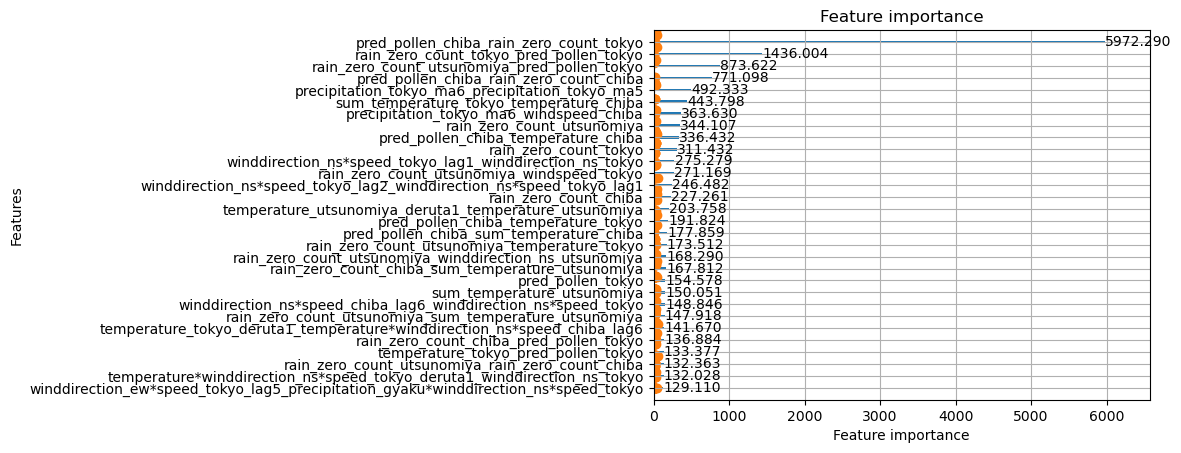

In [4033]:
lgb_tokyo_100_seed1_0 = lgbm_o("tokyo",df_train_test_x_t_100,df_train_test_y_t,df_test_x_t_100,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_t_0_100_seed1", seed=select_seed )

### ---1

In [4034]:
#train_travalをtrainとvalidに分割
df_traval_y_t_1 = df_train_traval_t_1[{"pollen_tokyo", "pollen_tokyo_cat"}]
df_traval_x_t_1 = df_train_traval_t_1.drop({"pollen_tokyo" ,"pollen_tokyo_cat", 
                                 "day", "month" 
                                }, axis=1)

#交互作用作成
from sklearn.preprocessing import PolynomialFeatures

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_t_1)
interaction_features = poly.get_feature_names(df_traval_x_t_1.columns)
df_traval_x_t_1 = pd.DataFrame(X_poly, columns=interaction_features)

df_traval_x_t_1_100 = df_traval_x_t_1[tokyo_importance_100]

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_t_1_100, df_traval_y_t_1, test_size=0.3, random_state=select_seed)

[I 2023-01-09 21:39:09,275] A new study created in memory with name: no-name-b318fe66-5ef1-4b22-b959-32dbab516106
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.443103:  14%|######4                                      | 1/7 [00:02<00:13,  2.28s/it]

Early stopping, best iteration is:
[351]	valid_0's huber: 0.0147991	valid_1's huber: 0.443103
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.443103:  29%|############8                                | 2/7 [00:05<00:12,  2.57s/it]

Early stopping, best iteration is:
[260]	valid_0's huber: 0.0349322	valid_1's huber: 0.44375
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.443038:  43%|###################2                         | 3/7 [00:08<00:11,  2.78s/it]

Early stopping, best iteration is:
[230]	valid_0's huber: 0.0461292	valid_1's huber: 0.443038
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.443038:  57%|#########################7                   | 4/7 [00:10<00:07,  2.53s/it]

Early stopping, best iteration is:
[239]	valid_0's huber: 0.0467721	valid_1's huber: 0.447772
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.443038:  71%|################################1            | 5/7 [00:12<00:05,  2.59s/it]

Early stopping, best iteration is:
[321]	valid_0's huber: 0.0177321	valid_1's huber: 0.447975
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.443038:  86%|######################################5      | 6/7 [00:16<00:02,  2.83s/it]

Early stopping, best iteration is:
[327]	valid_0's huber: 0.0158774	valid_1's huber: 0.444007
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.442248: 100%|#############################################| 7/7 [00:19<00:00,  2.72s/it]


Early stopping, best iteration is:
[567]	valid_0's huber: 0.00182212	valid_1's huber: 0.442248


num_leaves, val_score: 0.442248:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.442248:   5%|##5                                               | 1/20 [00:03<01:02,  3.30s/it]

Early stopping, best iteration is:
[317]	valid_0's huber: 0.000973565	valid_1's huber: 0.448059
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.442248:  10%|#####                                             | 2/20 [00:10<01:36,  5.35s/it]

Early stopping, best iteration is:
[255]	valid_0's huber: 0.000528214	valid_1's huber: 0.449385
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.442248:  15%|#######5                                          | 3/20 [00:14<01:23,  4.92s/it]

Early stopping, best iteration is:
[156]	valid_0's huber: 0.00251974	valid_1's huber: 0.445934
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.442248:  20%|##########                                        | 4/20 [00:16<01:03,  3.95s/it]

Early stopping, best iteration is:
[245]	valid_0's huber: 0.00766506	valid_1's huber: 0.443434
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  25%|############5                                     | 5/20 [00:20<00:57,  3.81s/it]

Early stopping, best iteration is:
[325]	valid_0's huber: 0.000617025	valid_1's huber: 0.440489
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  30%|###############                                   | 6/20 [00:26<01:01,  4.38s/it]

Early stopping, best iteration is:
[219]	valid_0's huber: 0.000844644	valid_1's huber: 0.447274
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  35%|#################5                                | 7/20 [00:29<00:53,  4.14s/it]

Early stopping, best iteration is:
[232]	valid_0's huber: 0.00109932	valid_1's huber: 0.447552
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  40%|####################                              | 8/20 [00:32<00:45,  3.80s/it]

Early stopping, best iteration is:
[116]	valid_0's huber: 0.0176385	valid_1's huber: 0.450057
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  45%|######################5                           | 9/20 [00:40<00:56,  5.18s/it]

Early stopping, best iteration is:
[255]	valid_0's huber: 0.000528214	valid_1's huber: 0.449385
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  50%|########################5                        | 10/20 [00:49<01:03,  6.33s/it]

Early stopping, best iteration is:
[255]	valid_0's huber: 0.000528214	valid_1's huber: 0.449385
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  55%|##########################9                      | 11/20 [00:52<00:45,  5.08s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.0402114	valid_1's huber: 0.456244
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  60%|#############################4                   | 12/20 [00:54<00:33,  4.23s/it]

Early stopping, best iteration is:
[768]	valid_0's huber: 0.0563191	valid_1's huber: 0.452207
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  65%|###############################8                 | 13/20 [00:59<00:30,  4.40s/it]

Early stopping, best iteration is:
[437]	valid_0's huber: 0.000386513	valid_1's huber: 0.444507
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  70%|##################################3              | 14/20 [01:03<00:25,  4.29s/it]

Early stopping, best iteration is:
[185]	valid_0's huber: 0.00197542	valid_1's huber: 0.444594
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  75%|####################################7            | 15/20 [01:05<00:18,  3.79s/it]

Early stopping, best iteration is:
[294]	valid_0's huber: 0.00471685	valid_1's huber: 0.445188
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  80%|#######################################2         | 16/20 [01:09<00:14,  3.75s/it]

Early stopping, best iteration is:
[682]	valid_0's huber: 0.000255632	valid_1's huber: 0.441448
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  85%|#########################################6       | 17/20 [01:11<00:10,  3.36s/it]

Early stopping, best iteration is:
[604]	valid_0's huber: 0.0406037	valid_1's huber: 0.451068
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  90%|############################################1    | 18/20 [01:17<00:08,  4.05s/it]

Early stopping, best iteration is:
[192]	valid_0's huber: 0.00174643	valid_1's huber: 0.44522
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489:  95%|##############################################5  | 19/20 [01:21<00:04,  4.14s/it]

Early stopping, best iteration is:
[244]	valid_0's huber: 0.00124415	valid_1's huber: 0.448621
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.440489: 100%|#################################################| 20/20 [01:26<00:00,  4.31s/it]


Early stopping, best iteration is:
[682]	valid_0's huber: 0.000255632	valid_1's huber: 0.441448


bagging, val_score: 0.440489:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.440489:  10%|#####3                                               | 1/10 [00:02<00:20,  2.30s/it]

Early stopping, best iteration is:
[202]	valid_0's huber: 0.025884	valid_1's huber: 0.46829
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.440489:  20%|##########6                                          | 2/10 [00:06<00:26,  3.34s/it]

Early stopping, best iteration is:
[382]	valid_0's huber: 0.00145897	valid_1's huber: 0.458228
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.440489:  30%|###############9                                     | 3/10 [00:08<00:20,  2.99s/it]

Early stopping, best iteration is:
[188]	valid_0's huber: 0.0139282	valid_1's huber: 0.45466
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.440489:  40%|#####################2                               | 4/10 [00:12<00:18,  3.16s/it]

Early stopping, best iteration is:
[293]	valid_0's huber: 0.00193654	valid_1's huber: 0.449165
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.440489:  50%|##########################5                          | 5/10 [00:13<00:12,  2.57s/it]

Early stopping, best iteration is:
[74]	valid_0's huber: 0.162545	valid_1's huber: 0.475054
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.440489:  60%|###############################8                     | 6/10 [00:17<00:11,  2.84s/it]

Early stopping, best iteration is:
[311]	valid_0's huber: 0.00389951	valid_1's huber: 0.462548
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.440489:  70%|#####################################                | 7/10 [00:22<00:10,  3.51s/it]

Early stopping, best iteration is:
[496]	valid_0's huber: 0.00138115	valid_1's huber: 0.461583
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.440489:  80%|##########################################4          | 8/10 [00:24<00:06,  3.01s/it]

Early stopping, best iteration is:
[120]	valid_0's huber: 0.0826526	valid_1's huber: 0.473022
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.440489:  90%|###############################################7     | 9/10 [00:26<00:02,  2.91s/it]

Early stopping, best iteration is:
[240]	valid_0's huber: 0.0198095	valid_1's huber: 0.470364
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.440489: 100%|####################################################| 10/10 [00:30<00:00,  3.02s/it]


Early stopping, best iteration is:
[288]	valid_0's huber: 0.0025056	valid_1's huber: 0.456567


feature_fraction_stage2, val_score: 0.440489:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.440489:  33%|############6                         | 1/3 [00:03<00:07,  3.73s/it]

Early stopping, best iteration is:
[276]	valid_0's huber: 0.00128259	valid_1's huber: 0.441468
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.440489:  67%|#########################3            | 2/3 [00:06<00:02,  2.92s/it]

Early stopping, best iteration is:
[155]	valid_0's huber: 0.0169142	valid_1's huber: 0.444629
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.440486: 100%|######################################| 3/3 [00:09<00:00,  3.18s/it]


Early stopping, best iteration is:
[268]	valid_0's huber: 0.00147968	valid_1's huber: 0.440486


regularization_factors, val_score: 0.440486:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.438328:   5%|#9                                    | 1/20 [00:03<01:14,  3.92s/it]

Early stopping, best iteration is:
[286]	valid_0's huber: 0.00106563	valid_1's huber: 0.438328
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.438328:  10%|###8                                  | 2/20 [00:08<01:13,  4.08s/it]

Early stopping, best iteration is:
[316]	valid_0's huber: 0.000725509	valid_1's huber: 0.441834
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.438328:  15%|#####7                                | 3/20 [00:11<01:06,  3.92s/it]

Early stopping, best iteration is:
[243]	valid_0's huber: 0.00212736	valid_1's huber: 0.447394
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  20%|#######6                              | 4/20 [00:16<01:05,  4.08s/it]

Early stopping, best iteration is:
[326]	valid_0's huber: 0.000526297	valid_1's huber: 0.436482
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  25%|#########5                            | 5/20 [00:19<00:56,  3.75s/it]

Early stopping, best iteration is:
[196]	valid_0's huber: 0.00668466	valid_1's huber: 0.442289
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  30%|###########4                          | 6/20 [00:22<00:49,  3.54s/it]

Early stopping, best iteration is:
[189]	valid_0's huber: 0.00779046	valid_1's huber: 0.44791
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  35%|#############3                        | 7/20 [00:26<00:47,  3.63s/it]

Early stopping, best iteration is:
[268]	valid_0's huber: 0.00147969	valid_1's huber: 0.440486
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  40%|###############2                      | 8/20 [00:30<00:46,  3.86s/it]

Early stopping, best iteration is:
[310]	valid_0's huber: 0.000666829	valid_1's huber: 0.440218
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  45%|#################1                    | 9/20 [00:34<00:42,  3.83s/it]

Early stopping, best iteration is:
[268]	valid_0's huber: 0.0014797	valid_1's huber: 0.440486
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  50%|##################5                  | 10/20 [00:38<00:39,  3.92s/it]

Early stopping, best iteration is:
[282]	valid_0's huber: 0.00261897	valid_1's huber: 0.445513
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  55%|####################3                | 11/20 [00:42<00:34,  3.87s/it]

Early stopping, best iteration is:
[256]	valid_0's huber: 0.00175838	valid_1's huber: 0.439455
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  60%|######################2              | 12/20 [00:45<00:30,  3.78s/it]

Early stopping, best iteration is:
[245]	valid_0's huber: 0.00222075	valid_1's huber: 0.441868
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  65%|########################             | 13/20 [00:48<00:23,  3.32s/it]

Early stopping, best iteration is:
[362]	valid_0's huber: 0.01859	valid_1's huber: 0.45484
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  70%|#########################9           | 14/20 [00:51<00:20,  3.44s/it]

Early stopping, best iteration is:
[248]	valid_0's huber: 0.00224287	valid_1's huber: 0.442465
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  75%|###########################7         | 15/20 [00:55<00:17,  3.58s/it]

Early stopping, best iteration is:
[278]	valid_0's huber: 0.00115584	valid_1's huber: 0.440883
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  80%|#############################6       | 16/20 [00:59<00:14,  3.53s/it]

Early stopping, best iteration is:
[227]	valid_0's huber: 0.00341778	valid_1's huber: 0.440802
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  85%|###############################4     | 17/20 [01:02<00:10,  3.50s/it]

Early stopping, best iteration is:
[221]	valid_0's huber: 0.00347079	valid_1's huber: 0.446799
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  90%|#################################3   | 18/20 [01:06<00:07,  3.64s/it]

Early stopping, best iteration is:
[267]	valid_0's huber: 0.0022648	valid_1's huber: 0.443459
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482:  95%|###################################1 | 19/20 [01:10<00:03,  3.83s/it]

Early stopping, best iteration is:
[310]	valid_0's huber: 0.00068571	valid_1's huber: 0.438906
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.436482: 100%|#####################################| 20/20 [01:14<00:00,  3.73s/it]


Early stopping, best iteration is:
[268]	valid_0's huber: 0.00147984	valid_1's huber: 0.440486


min_data_in_leaf, val_score: 0.436482:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.436482:  20%|#########                                    | 1/5 [00:04<00:16,  4.20s/it]

Early stopping, best iteration is:
[317]	valid_0's huber: 0.0008944	valid_1's huber: 0.439957
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.436482:  40%|##################                           | 2/5 [00:10<00:15,  5.13s/it]

Early stopping, best iteration is:
[448]	valid_0's huber: 3.09204e-05	valid_1's huber: 0.444238
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.436482:  60%|###########################                  | 3/5 [00:14<00:09,  4.76s/it]

Early stopping, best iteration is:
[263]	valid_0's huber: 0.000831124	valid_1's huber: 0.438704
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.436482:  80%|####################################         | 4/5 [00:18<00:04,  4.48s/it]

Early stopping, best iteration is:
[355]	valid_0's huber: 0.0021767	valid_1's huber: 0.447956
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.436482: 100%|#############################################| 5/5 [00:20<00:00,  4.19s/it]

Early stopping, best iteration is:
[428]	valid_0's huber: 0.0126933	valid_1's huber: 0.452121
Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 3, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 5.401460619371063e-05, 'lambda_l2': 0.0014643694995403911, 'num_leaves': 65, 'feature_fraction': 0.44800000000000006, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
MAE 8.693059628977208


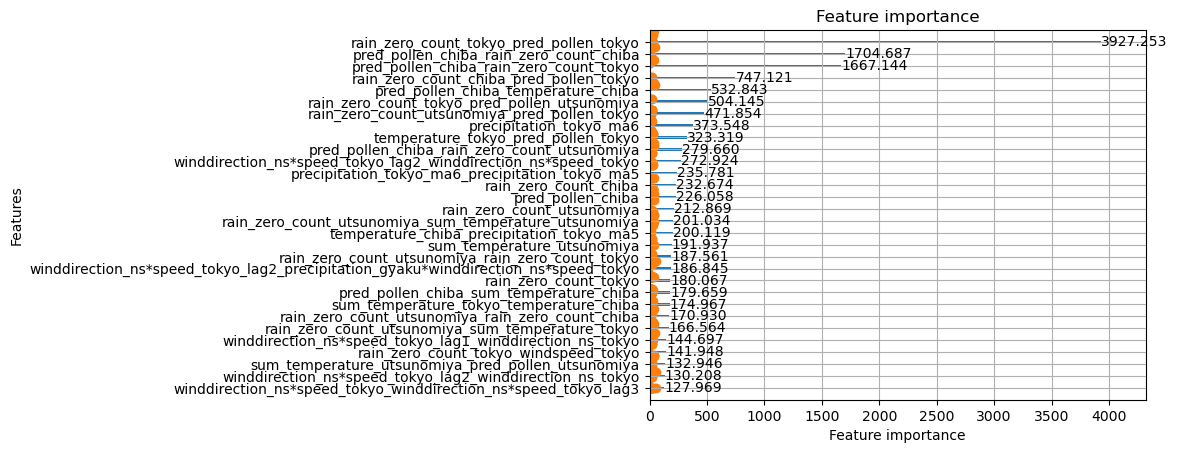

In [4035]:
lgb_tokyo_100_seed1_1 = lgbm_o("tokyo",df_train_test_x_t_100,df_train_test_y_t,df_test_x_t_100,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_t_1_100_seed1", seed=select_seed )

### ---2

In [4036]:
#train_travalをtrainとvalidに分割
df_traval_y_t_2 = df_train_traval_t_2[{"pollen_tokyo", "pollen_tokyo_cat"}]
df_traval_x_t_2 = df_train_traval_t_2.drop({"pollen_tokyo" ,"pollen_tokyo_cat", 
                                 "day", "month" 
                                }, axis=1)

#交互作用作成
from sklearn.preprocessing import PolynomialFeatures

# 交互作用特徴量を生成する
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_traval_x_t_2)
interaction_features = poly.get_feature_names(df_traval_x_t_2.columns)
df_traval_x_t_2 = pd.DataFrame(X_poly, columns=interaction_features)

df_traval_x_t_2_100 = df_traval_x_t_2[tokyo_importance_100]

x_train, x_valid, y_train, y_valid= train_test_split(df_traval_x_t_2_100, df_traval_y_t_2, test_size=0.3, random_state=select_seed)

[I 2023-01-09 21:43:10,851] A new study created in memory with name: no-name-3de806a4-8f0e-451f-956a-7519ae314ac0
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.313130:  14%|######4                                      | 1/7 [00:05<00:31,  5.21s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000587379	valid_1's huber: 0.31313
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.307812:  29%|############8                                | 2/7 [00:13<00:34,  6.85s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000471415	valid_1's huber: 0.307812
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.307812:  43%|###################2                         | 3/7 [00:19<00:26,  6.72s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000458523	valid_1's huber: 0.319856
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.307812:  57%|#########################7                   | 4/7 [00:24<00:18,  6.00s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000632655	valid_1's huber: 0.316372
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.307812:  71%|################################1            | 5/7 [00:33<00:13,  6.86s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000374696	valid_1's huber: 0.312991
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.307812:  86%|######################################5      | 6/7 [00:38<00:06,  6.47s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00044291	valid_1's huber: 0.317859
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.307812: 100%|#############################################| 7/7 [00:46<00:00,  6.64s/it]


Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.000420123	valid_1's huber: 0.312749


num_leaves, val_score: 0.307812:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[577]	valid_0's huber: 5.67246e-05	valid_1's huber: 0.311554


num_leaves, val_score: 0.307812:   5%|##5                                               | 1/20 [00:32<10:11, 32.19s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.9546e-06	valid_1's huber: 0.31102


num_leaves, val_score: 0.307812:  10%|#####                                             | 2/20 [01:27<13:45, 45.88s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.307812:  15%|#######5                                          | 3/20 [01:41<08:47, 31.05s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.88431e-05	valid_1's huber: 0.311791
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.307315:  20%|##########                                        | 4/20 [02:11<08:13, 30.85s/it]

Early stopping, best iteration is:
[707]	valid_0's huber: 4.60801e-05	valid_1's huber: 0.307315
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.307315:  25%|############5                                     | 5/20 [02:31<06:42, 26.80s/it]

Early stopping, best iteration is:
[868]	valid_0's huber: 2.4126e-05	valid_1's huber: 0.308709
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.307315:  30%|###############                                   | 6/20 [02:54<05:59, 25.69s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 8.30699e-06	valid_1's huber: 0.308959
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[729]	valid_0's huber: 1.93656e-05	valid_1's huber: 0.31146


num_leaves, val_score: 0.307315:  35%|#################5                                | 7/20 [03:36<06:42, 30.97s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.307315:  35%|#################5                                | 7/20 [04:09<06:42, 30.97s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.52026e-06	valid_1's huber: 0.309841


num_leaves, val_score: 0.307315:  40%|####################                              | 8/20 [04:09<06:19, 31.59s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.307315:  45%|######################5                           | 9/20 [04:35<05:27, 29.75s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.56781e-06	valid_1's huber: 0.312868
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.307315:  50%|########################5                        | 10/20 [04:37<03:31, 21.15s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.18391	valid_1's huber: 0.377572
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[845]	valid_0's huber: 1.09567e-05	valid_1's huber: 0.313223


num_leaves, val_score: 0.307315:  55%|##########################9                      | 11/20 [05:14<03:54, 26.03s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 5.57966e-06	valid_1's huber: 0.309001


num_leaves, val_score: 0.307315:  60%|#############################4                   | 12/20 [05:54<04:04, 30.50s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.307315:  65%|###############################8                 | 13/20 [06:08<02:57, 25.39s/it]

Early stopping, best iteration is:
[810]	valid_0's huber: 2.00487e-05	valid_1's huber: 0.310803
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 7.0348e-06	valid_1's huber: 0.313936


num_leaves, val_score: 0.307315:  70%|##################################3              | 14/20 [06:48<02:58, 29.70s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.307315:  75%|####################################7            | 15/20 [06:53<01:51, 22.32s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.0049377	valid_1's huber: 0.31852
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.11519e-06	valid_1's huber: 0.308463


num_leaves, val_score: 0.307315:  80%|#######################################2         | 16/20 [07:25<01:41, 25.33s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.307315:  85%|#########################################6       | 17/20 [07:53<01:17, 25.93s/it][I 2023-01-09 21:51:50,405] Trial 23 finished with value: 0.30825898970861354 and parameters: {'num_leaves': 142}. Best is trial 10 with value: 0.30731469777540643.


Early stopping, best iteration is:
[782]	valid_0's huber: 2.14407e-05	valid_1's huber: 0.308259


num_leaves, val_score: 0.307315:  85%|#########################################6       | 17/20 [07:53<01:17, 25.93s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[815]	valid_0's huber: 2.11635e-05	valid_1's huber: 0.309248


num_leaves, val_score: 0.307315:  90%|############################################1    | 18/20 [08:28<00:57, 28.69s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 4.42985e-06	valid_1's huber: 0.309728


num_leaves, val_score: 0.307315:  95%|##############################################5  | 19/20 [09:10<00:32, 32.80s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.307315: 100%|#################################################| 20/20 [09:38<00:00, 28.90s/it]


Early stopping, best iteration is:
[694]	valid_0's huber: 3.53334e-05	valid_1's huber: 0.311733


bagging, val_score: 0.307315:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.25584e-05	valid_1's huber: 0.314337


bagging, val_score: 0.307315:  10%|#####3                                               | 1/10 [00:30<04:33, 30.38s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.307315:  20%|##########6                                          | 2/10 [00:52<03:24, 25.60s/it]

Early stopping, best iteration is:
[575]	valid_0's huber: 0.000108624	valid_1's huber: 0.314907
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[769]	valid_0's huber: 2.59023e-05	valid_1's huber: 0.315173


bagging, val_score: 0.307315:  30%|###############9                                     | 3/10 [01:24<03:17, 28.26s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[864]	valid_0's huber: 9.94238e-05	valid_1's huber: 0.323919


bagging, val_score: 0.307315:  40%|#####################2                               | 4/10 [01:53<02:53, 28.85s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.83059e-05	valid_1's huber: 0.318749


bagging, val_score: 0.307315:  50%|##########################5                          | 5/10 [02:27<02:32, 30.42s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 8.17511e-06	valid_1's huber: 0.306352


bagging, val_score: 0.306352:  60%|###############################8                     | 6/10 [03:02<02:07, 31.97s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.306352:  70%|#####################################                | 7/10 [03:20<01:23, 27.71s/it]

Early stopping, best iteration is:
[496]	valid_0's huber: 0.000745669	valid_1's huber: 0.325469
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.306352:  70%|#####################################                | 7/10 [03:46<01:23, 27.71s/it]

Early stopping, best iteration is:
[896]	valid_0's huber: 0.000403282	valid_1's huber: 0.33554


bagging, val_score: 0.306352:  80%|##########################################4          | 8/10 [03:46<00:53, 26.95s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.306352:  80%|##########################################4          | 8/10 [04:14<00:53, 26.95s/it]

Early stopping, best iteration is:
[762]	valid_0's huber: 9.73798e-05	valid_1's huber: 0.317895


bagging, val_score: 0.306352:  90%|###############################################7     | 9/10 [04:14<00:27, 27.42s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.76224e-06	valid_1's huber: 0.315161


feature_fraction_stage2, val_score: 0.306352:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 7.72601e-06	valid_1's huber: 0.310016


feature_fraction_stage2, val_score: 0.306352:  17%|######3                               | 1/6 [00:32<02:41, 32.23s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.306352:  17%|######3                               | 1/6 [01:06<02:41, 32.23s/it]

Early stopping, best iteration is:
[893]	valid_0's huber: 1.31423e-05	valid_1's huber: 0.310254


feature_fraction_stage2, val_score: 0.306352:  33%|############6                         | 2/6 [01:06<02:14, 33.66s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.306352:  50%|###################                   | 3/6 [01:39<01:40, 33.37s/it][I 2023-01-09 22:00:05,000] Trial 39 finished with value: 0.31070817507176074 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.31001639367864997.


Early stopping, best iteration is:
[792]	valid_0's huber: 2.44464e-05	valid_1's huber: 0.310708


feature_fraction_stage2, val_score: 0.306352:  50%|###################                   | 3/6 [01:39<01:40, 33.37s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.306352:  67%|#########################3            | 4/6 [02:04<00:59, 29.84s/it]

Early stopping, best iteration is:
[673]	valid_0's huber: 5.36617e-05	valid_1's huber: 0.306696
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.306352:  67%|#########################3            | 4/6 [02:39<00:59, 29.84s/it]

Early stopping, best iteration is:
[842]	valid_0's huber: 1.41489e-05	valid_1's huber: 0.312528


feature_fraction_stage2, val_score: 0.306352:  83%|###############################6      | 5/6 [02:39<00:31, 31.84s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.02351e-06	valid_1's huber: 0.309082


regularization_factors, val_score: 0.306352:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.31984e-05	valid_1's huber: 0.305695


regularization_factors, val_score: 0.305695:   5%|#9                                    | 1/20 [00:39<12:32, 39.61s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.305695:   5%|#9                                    | 1/20 [01:13<12:32, 39.61s/it]

Early stopping, best iteration is:
[761]	valid_0's huber: 4.58989e-05	valid_1's huber: 0.310847


regularization_factors, val_score: 0.305695:  10%|###8                                  | 2/20 [01:13<10:51, 36.21s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.305695:  15%|#####7                                | 3/20 [01:21<06:35, 23.24s/it]

Early stopping, best iteration is:
[496]	valid_0's huber: 0.000668085	valid_1's huber: 0.315338
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.305695:  20%|#######6                              | 4/20 [01:26<04:17, 16.11s/it]

Early stopping, best iteration is:
[400]	valid_0's huber: 0.00578171	valid_1's huber: 0.315178
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.305695:  25%|#########5                            | 5/20 [01:40<03:51, 15.41s/it]

Early stopping, best iteration is:
[784]	valid_0's huber: 2.91559e-05	valid_1's huber: 0.307677
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.305573:  25%|#########5                            | 5/20 [01:58<03:51, 15.41s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 2.46839e-05	valid_1's huber: 0.305573


regularization_factors, val_score: 0.305573:  30%|###########4                          | 6/20 [01:58<03:49, 16.37s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 6.69265e-06	valid_1's huber: 0.310791


regularization_factors, val_score: 0.305573:  35%|#############3                        | 7/20 [02:37<05:09, 23.81s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.305573:  35%|#############3                        | 7/20 [03:13<05:09, 23.81s/it]

Early stopping, best iteration is:
[807]	valid_0's huber: 2.66827e-05	valid_1's huber: 0.30898


regularization_factors, val_score: 0.305573:  40%|###############2                      | 8/20 [03:13<05:30, 27.53s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.2019e-06	valid_1's huber: 0.306852


regularization_factors, val_score: 0.305573:  45%|#################1                    | 9/20 [03:48<05:29, 30.00s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.16061e-05	valid_1's huber: 0.311571


regularization_factors, val_score: 0.305573:  50%|##################5                  | 10/20 [04:23<05:13, 31.30s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.305573:  50%|##################5                  | 10/20 [04:46<05:13, 31.30s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.20328e-05	valid_1's huber: 0.308029


regularization_factors, val_score: 0.305573:  55%|####################3                | 11/20 [04:46<04:21, 29.02s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.305573:  55%|####################3                | 11/20 [05:17<04:21, 29.02s/it]

Early stopping, best iteration is:
[796]	valid_0's huber: 3.63212e-05	valid_1's huber: 0.310846


regularization_factors, val_score: 0.305573:  60%|######################2              | 12/20 [05:17<03:55, 29.44s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.40448e-06	valid_1's huber: 0.307564


regularization_factors, val_score: 0.305573:  65%|########################             | 13/20 [05:54<03:42, 31.85s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.305573:  70%|#########################9           | 14/20 [06:24<03:07, 31.20s/it]

Early stopping, best iteration is:
[701]	valid_0's huber: 4.58756e-05	valid_1's huber: 0.312689
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.305573:  70%|#########################9           | 14/20 [06:48<03:07, 31.20s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.56566e-05	valid_1's huber: 0.307558


regularization_factors, val_score: 0.305573:  75%|###########################7         | 15/20 [06:48<02:25, 29.07s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.305573:  75%|###########################7         | 15/20 [07:23<02:25, 29.07s/it]

Early stopping, best iteration is:
[836]	valid_0's huber: 2.18844e-05	valid_1's huber: 0.306003


regularization_factors, val_score: 0.305573:  80%|#############################6       | 16/20 [07:23<02:03, 30.92s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 9.67971e-06	valid_1's huber: 0.303177


regularization_factors, val_score: 0.303177:  85%|###############################4     | 17/20 [08:01<01:38, 32.95s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 7.16347e-06	valid_1's huber: 0.312558


regularization_factors, val_score: 0.303177:  90%|#################################3   | 18/20 [08:39<01:09, 34.54s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 8.17852e-06	valid_1's huber: 0.306315


regularization_factors, val_score: 0.303177:  95%|###################################1 | 19/20 [09:18<00:35, 35.69s/it]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.19624e-05	valid_1's huber: 0.307475


min_data_in_leaf, val_score: 0.303177:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 1.94102e-05	valid_1's huber: 0.311215


min_data_in_leaf, val_score: 0.303177:  20%|#########                                    | 1/5 [00:34<02:19, 34.88s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.303177:  40%|##################                           | 2/5 [00:47<01:05, 21.96s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's huber: 0.00060822	valid_1's huber: 0.321587
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.303177:  60%|###########################                  | 3/5 [01:07<00:41, 20.92s/it]

Early stopping, best iteration is:
[700]	valid_0's huber: 0.000364535	valid_1's huber: 0.311334
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.303177:  80%|####################################         | 4/5 [01:22<00:18, 18.48s/it]

Early stopping, best iteration is:
[252]	valid_0's huber: 2.53419e-05	valid_1's huber: 0.311863
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.303177: 100%|#############################################| 5/5 [01:45<00:00, 21.14s/it]

Early stopping, best iteration is:
[502]	valid_0's huber: 6.87674e-06	valid_1's huber: 0.312592
Best params: {'boosting_type': 'gbdt', 'objective': 'huber', 'metric': 'huber', 'seed': 3, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 1.3660163508097384e-08, 'lambda_l2': 0.02639768661706455, 'num_leaves': 144, 'feature_fraction': 0.8, 'bagging_fraction': 0.9794306326153597, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}


MAE 8.801865623381458


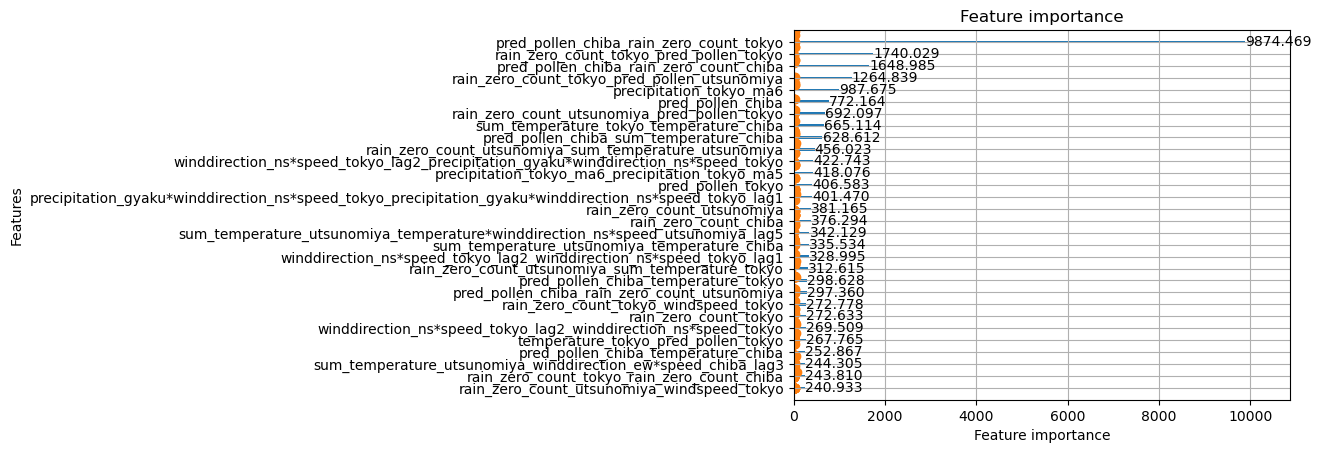

In [4037]:
lgb_tokyo_100_seed1_2 = lgbm_o("tokyo",df_train_test_x_t_100,df_train_test_y_t,df_test_x_t_100,0.5, x_train, x_valid, y_train, y_valid, "_lgbm_t_2_100_seed1", seed=select_seed )

### ---Ave.

MAE
lgbm 8.587903668841628


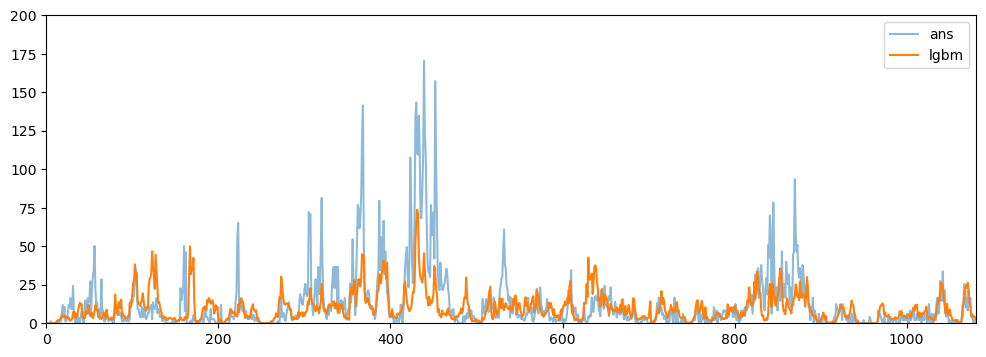

In [4038]:
r = 2

df_pred["pollen_"+region_list[r]+"_lgbm_100_seed1"] = (df_pred["pollen_"+region_list[r]+"_lgbm_t_0_100_seed1"]+df_pred["pollen_"+region_list[r]+"_lgbm_t_1_100_seed1"]+df_pred["pollen_"+region_list[r]+"_lgbm_t_2_100_seed1"])/3

plt.figure(figsize=(12,4))
plt.plot(np.array(df_train_test_y_t["pollen_"+region_list[r]]), alpha=0.5, label="ans")
plt.plot(df_pred["pollen_"+region_list[r]+"_lgbm_100_seed1"], label="lgbm")
plt.legend()
plt.xlim(0,len(df_pred))
plt.ylim(0,200)

print("MAE")
print("lgbm",mean_absolute_error(df_pred["pollen_"+region_list[r]+"_lgbm_100_seed1"], np.array(df_train_test_y_t["pollen_"+region_list[r]])))

In [4039]:
#sub
r = 2

### lgbm
df_submission["pollen_"+region_list[r]] = (df_sub["pollen_"+region_list[r]+"_lgbm_t_0_100_seed1"]+df_sub["pollen_"+region_list[r]+"_lgbm_t_1_100_seed1"]+df_sub["pollen_"+region_list[r]+"_lgbm_t_2_100_seed1"])/3


#4の倍数にそろえる
#for i in range(1000):
#    df_submission["pollen_tokyo"][(df_submission["pollen_tokyo"] > i*4-2) & (df_submission["pollen_tokyo"] <= i*4+2)] = i*4

In [4041]:
df_pred.to_csv("df_pred_seed"+str(select_seed)+".csv", index = False)
df_submission.to_csv("submission_08_seed"+str(select_seed)+".csv", index = False)

In [3721]:
# importanceを計算するのは時間がかかるので、保存しておく
utsunomiya_importance.to_csv("utsunomiya_importance.csv", index = True)
chiba_importance.to_csv("chiba_importance.csv", index = True)
tokyo_importance.to_csv("tokyo_importance.csv", index = True)